In [8]:
import numpy as np
import chess
import chess.pgn
import math
import random
from collections import defaultdict, deque
from tensorflow.keras.models import Sequential 
from tensorflow.keras.models import load_model

C_PUCT = 1.5       
model_type = "positional"
model = load_model(f'{model_type}.keras')

import numpy as np
piece_map = {
    chess.PAWN: 0,
    chess.KNIGHT: 1,
    chess.BISHOP: 2,
    chess.ROOK: 3,
    chess.QUEEN: 4,
    chess.KING: 5
}
def board2tensor_1d(board):
    tensor = np.zeros((12, 64), dtype=np.float32)
    for sq in chess.SQUARES:
        piece = board.piece_at(sq)
        if piece:
            base = piece_map[piece.piece_type]
            if piece.color == chess.BLACK:
                base += 6
            tensor[base, sq] = 1.0
    return tensor.flatten()

class MCTSNode:
    def __init__(self, board, parent=None, eval=0.0):
        self.board = board.copy()
        self.parent = parent
        self.children = {}
        self.prior = eval
        self.N = 0
        self.W = 0.0
        self.Q = 0.0
        self.is_expanded = False

    def expand(self):
        legal_moves = list(self.board.generate_legal_moves())

        for move in legal_moves:
            self.board.push(move)
            tensor = board2tensor_1d(self.board).reshape(1, -1)
            eval = model.predict(tensor, verbose=0)[0][0]
            self.children[move] = MCTSNode(self.board, self, eval)
            self.board.pop()

        self.is_expanded = True
        return self.prior

    @staticmethod
    def uct_score(child, parent_N, c_puct=1.5):
        U = c_puct * child.prior * math.sqrt(parent_N + 1e-8) / (1 + child.N)
        return child.Q + U

    def select_child(self):
        parent_N = self.N
        best_move = None
        best_score = -float('inf')

        for move, child in self.children.items():
            score = MCTSNode.uct_score(child, parent_N)
            if score > best_score:
                best_score = score
                best_move = move

        return best_move, self.children[best_move]

    def backpropagate(self, value):
        node = self
        while node is not None:
            node.N += 1
            node.W += value
            node.Q = node.W / node.N
            
            value = -value
            node = node.parent


def mcts_search(root, simulations=800):
    for _ in range(simulations):
        node = root

        # Selection
        while node.is_expanded and not node.board.is_game_over():
            move, node = node.select_child()

        # Expansion
        if not node.board.is_game_over():
            value = node.expand()
        else:
            result = node.board.result()
            if result == "1-0":
                value = 1
            elif result == "0-1":
                value = -1
            else:
                value = 0

        # Backpropagation
        node.backpropagate(value)


In [9]:
from collections import deque

def extract_training_data(root):
    queue = deque([root])
    X, Y = [], []

    while queue:
        node = queue.popleft()

        tensor = board2tensor_1d(node.board)
        X.append(tensor)

        # Q-value jako label
        Y.append(node.Q)

        for child in node.children.values():
            queue.append(child)

    return np.array(X), np.array(Y)


In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
model = load_model(f'{model_type}.keras')
ITERATIONS = 150 
SYMULATIONS = 750

version = 1
historis = []
for iter in range(ITERATIONS):
    root = MCTSNode(chess.Board())
    mcts_search(root, simulations=SYMULATIONS)
    X, Y = extract_training_data(root)

    X = np.array(X)
    Y = np.array(Y).astype(np.float32)
    print("Zebrano przykładów:", X.shape[0])


    X_train, X_val, y_train, y_val = train_test_split(
        X, Y, test_size=0.2, shuffle=True
    )


    model.compile(
        optimizer="adam",
        loss="mse",
        metrics=["mae"]
    )
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=256,
        verbose=1,
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
    )
    historis.append(history)
    if((iter + 1) % 10 == 0):
        model.save(f"models/{model_type}_{version}.keras")
        version += 1





Zebrano przykładów: 17155
Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0016 - mae: 0.0254 - val_loss: 4.0915e-05 - val_mae: 0.0038
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6970e-05 - mae: 0.0038 - val_loss: 3.1716e-05 - val_mae: 0.0030
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8650e-05 - mae: 0.0029 - val_loss: 2.8621e-05 - val_mae: 0.0027
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6656e-05 - mae: 0.0027 - val_loss: 2.7885e-05 - val_mae: 0.0029
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4961e-05 - mae: 0.0025 - val_loss: 2.6010e-05 - val_mae: 0.0022
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4081e-05 - mae: 0.0025 - val_loss: 2.5307e-05 - val_mae: 0.0022
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4238e-05 - mae: 0.0025 - val_loss: 2.7640e-05 - val_mae: 0.0025
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3640e-05 - mae: 0.0025 - val_loss: 2.5328e-05 - v

2025-12-12 00:45:11.741475: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 360 bytes spill stores, 360 bytes spill loads

2025-12-12 00:45:11.903608: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 00:45:12.049779: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 644 bytes spill stores, 644 bytes spill loads

2025-12-12 00:45:12.071631: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 28 bytes spill stores, 28 bytes spill loads

2025-12-12 00:45:12.108456: I external

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 5.4639e-04 - mae: 0.0148 - val_loss: 2.3553e-05 - val_mae: 0.0035
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3135e-05 - mae: 0.0025 - val_loss: 9.9281e-06 - val_mae: 0.0021
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3065e-06 - mae: 0.0019 - val_loss: 6.4997e-06 - val_mae: 0.0016
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9771e-06 - mae: 0.0015 - val_loss: 7.1639e-06 - val_mae: 0.0019
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4910e-06 - mae: 0.0014 - val_loss: 4.9343e-06 - val_mae: 0.0015
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8682e-06 - mae: 0.0016 - val_loss: 4.3820e-06 - val_mae: 0.0014
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1429e-06 - mae: 0.0014 - val_loss: 5.1741e-06 - val_mae: 0.0016
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8157e-06 - mae: 0.0014 - val_loss: 4.7188e-06 - val_mae: 0.0016
Epoch 9/10
54/54 ━

2025-12-12 00:55:23.820989: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 00:55:23.933279: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 00:55:24.172983: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-12 00:55:24.189331: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 496 bytes spill stores, 496 bytes spill loads

2025-12-12 00:55:24.219532: I external/l

52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0013 - mae: 0.0225 - val_loss: 3.9866e-05 - val_mae: 0.0050
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7939e-05 - mae: 0.0032 - val_loss: 1.0356e-05 - val_mae: 0.0022
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.4273e-06 - mae: 0.0020 - val_loss: 7.2473e-06 - val_mae: 0.0018
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3621e-06 - mae: 0.0017 - val_loss: 5.4935e-06 - val_mae: 0.0015
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0598e-06 - mae: 0.0015 - val_loss: 4.5726e-06 - val_mae: 0.0014
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2409e-06 - mae: 0.0013 - val_loss: 3.8482e-06 - val_mae: 0.0013
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7147e-06 - mae: 0.0012 - val_loss: 3.5487e-06 - val_mae: 0.0012
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4922e-06 - mae: 0.0012 - val_loss: 3.0542e-06 - val_mae: 0.0011
Epoch 9/10
52/52 ━━━━━

2025-12-12 01:05:36.560837: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 01:05:36.991294: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 148 bytes spill stores, 148 bytes spill loads

2025-12-12 01:05:37.027179: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 436 bytes spill stores, 436 bytes spill loads

2025-12-12 01:05:37.039586: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 644 bytes spill stores, 644 bytes spill loads

2025-12-12 01:05:37.070312: I external/l

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0016 - mae: 0.0252 - val_loss: 3.8358e-05 - val_mae: 0.0047
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9914e-05 - mae: 0.0031 - val_loss: 1.3019e-05 - val_mae: 0.0023
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0676e-05 - mae: 0.0021 - val_loss: 1.0305e-05 - val_mae: 0.0020
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.6757e-06 - mae: 0.0018 - val_loss: 9.1657e-06 - val_mae: 0.0018
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5727e-06 - mae: 0.0016 - val_loss: 8.4952e-06 - val_mae: 0.0017
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2210e-06 - mae: 0.0016 - val_loss: 8.0258e-06 - val_mae: 0.0017
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5510e-06 - mae: 0.0015 - val_loss: 7.5748e-06 - val_mae: 0.0015
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1711e-06 - mae: 0.0014 - val_loss: 7.0753e-06 - val_mae: 0.0015
Epoch 9/10
54/54 ━━━━━

2025-12-12 01:26:21.065322: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 44 bytes spill stores, 44 bytes spill loads

2025-12-12 01:26:21.068444: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 132 bytes spill stores, 132 bytes spill loads

2025-12-12 01:26:21.072954: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 108 bytes spill stores, 108 bytes spill loads

2025-12-12 01:26:21.175282: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 516 bytes spill stores, 516 bytes spill loads

2025-12-12 01:26:21.180733: I external

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0031 - mae: 0.0373

2025-12-12 01:26:22.643107: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 01:26:22.704016: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-12 01:26:22.731578: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 01:26:22.840541: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-12 01:26:22.863169: I external/loc

55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0013 - mae: 0.0220 - val_loss: 2.3011e-05 - val_mae: 0.0035
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5545e-05 - mae: 0.0029 - val_loss: 9.0672e-06 - val_mae: 0.0021
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3740e-06 - mae: 0.0018 - val_loss: 6.2239e-06 - val_mae: 0.0017
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6711e-06 - mae: 0.0016 - val_loss: 5.1928e-06 - val_mae: 0.0015
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5734e-06 - mae: 0.0014 - val_loss: 4.1442e-06 - val_mae: 0.0013
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9083e-06 - mae: 0.0012 - val_loss: 3.5546e-06 - val_mae: 0.0012
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3733e-06 - mae: 0.0011 - val_loss: 3.1509e-06 - val_mae: 0.0011
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0615e-06 - mae: 0.0010 - val_loss: 2.8058e-06 - val_mae: 0.0010
Epoch 9/10
55/55 ━━━━━

2025-12-12 01:38:10.995379: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 01:38:11.141449: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 52 bytes spill stores, 52 bytes spill loads

2025-12-12 01:38:11.187832: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 01:38:11.234766: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-12 01:38:11.333303: I external/loc

61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 8.6234e-04 - mae: 0.0177 - val_loss: 2.7089e-05 - val_mae: 0.0042
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0287e-05 - mae: 0.0023 - val_loss: 6.5981e-06 - val_mae: 0.0018
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1527e-06 - mae: 0.0016 - val_loss: 5.1871e-06 - val_mae: 0.0016
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7134e-06 - mae: 0.0014 - val_loss: 4.0336e-06 - val_mae: 0.0013
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8793e-06 - mae: 0.0012 - val_loss: 3.0917e-06 - val_mae: 0.0012
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2898e-06 - mae: 0.0011 - val_loss: 2.8124e-06 - val_mae: 0.0011
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0054e-06 - mae: 0.0010 - val_loss: 2.4454e-06 - val_mae: 0.0010
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6693e-06 - mae: 9.0545e-04 - val_loss: 2.3454e-06 - val_mae: 0.0010
Epoch 9/10
61/

2025-12-12 01:48:51.759014: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 01:48:51.892869: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 8 bytes spill stores, 16 bytes spill loads

2025-12-12 01:48:52.020776: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 01:48:52.146442: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-12 01:48:52.150923: I external/loca

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0038 - mae: 0.0406

2025-12-12 01:48:53.758481: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 01:48:53.799244: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-12 01:48:53.812600: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 01:48:53.954893: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-12 01:48:53.964975: I external/loc

55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0015 - mae: 0.0236 - val_loss: 2.6946e-05 - val_mae: 0.0035
Epoch 2/10


2025-12-12 01:48:54.341104: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 1488 bytes spill stores, 1444 bytes spill loads



55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8966e-05 - mae: 0.0029 - val_loss: 1.2572e-05 - val_mae: 0.0022
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1072e-05 - mae: 0.0021 - val_loss: 1.0106e-05 - val_mae: 0.0019
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0667e-06 - mae: 0.0019 - val_loss: 8.4968e-06 - val_mae: 0.0018
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.9270e-06 - mae: 0.0017 - val_loss: 7.2981e-06 - val_mae: 0.0015
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0585e-06 - mae: 0.0015 - val_loss: 6.8181e-06 - val_mae: 0.0015
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1632e-06 - mae: 0.0016 - val_loss: 7.1353e-06 - val_mae: 0.0016
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3718e-06 - mae: 0.0014 - val_loss: 7.2359e-06 - val_mae: 0.0016
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8553e-06 - mae: 0.0013 - val_loss: 5.7870e-06 - val_mae: 0.0012
Epoch 10/10
55/55 ━

2025-12-12 01:59:03.669645: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 360 bytes spill stores, 360 bytes spill loads

2025-12-12 01:59:03.711761: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 01:59:03.838889: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 644 bytes spill stores, 644 bytes spill loads

2025-12-12 01:59:03.905933: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 496 bytes spill stores, 496 bytes spill loads

2025-12-12 01:59:03.910411: I extern

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 6.6586e-04 - mae: 0.0167 - val_loss: 1.5122e-05 - val_mae: 0.0030
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.7879e-06 - mae: 0.0020 - val_loss: 5.8498e-06 - val_mae: 0.0017
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2320e-06 - mae: 0.0014 - val_loss: 3.3952e-06 - val_mae: 0.0012
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9543e-06 - mae: 0.0012 - val_loss: 2.7534e-06 - val_mae: 0.0012
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3796e-06 - mae: 0.0010 - val_loss: 1.8717e-06 - val_mae: 9.3057e-04
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9266e-06 - mae: 9.3730e-04 - val_loss: 2.0829e-06 - val_mae: 0.0010
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6819e-06 - mae: 8.6251e-04 - val_loss: 1.9579e-06 - val_mae: 9.9718e-04
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5304e-06 - mae: 8.1791e-04 - val_loss: 1.5282e-06 - val_mae: 8.216

2025-12-12 02:10:57.003743: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 02:10:57.012021: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 02:10:57.122541: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-12 02:10:57.176621: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 3248 bytes spill stores, 3224 bytes spill loads

2025-12-12 02:10:57.190629: I external/l

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 7.3747e-04 - mae: 0.0168 - val_loss: 1.8251e-05 - val_mae: 0.0031
Epoch 2/10
 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.7569e-05 - mae: 0.0031

2025-12-12 02:10:57.562092: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 1488 bytes spill stores, 1444 bytes spill loads



62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1311e-05 - mae: 0.0024 - val_loss: 8.3454e-06 - val_mae: 0.0020
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0208e-06 - mae: 0.0018 - val_loss: 6.2087e-06 - val_mae: 0.0017
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3419e-06 - mae: 0.0015 - val_loss: 4.4623e-06 - val_mae: 0.0014
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0614e-06 - mae: 0.0012 - val_loss: 5.9399e-06 - val_mae: 0.0019
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9126e-06 - mae: 0.0012 - val_loss: 3.2075e-06 - val_mae: 0.0011
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2651e-06 - mae: 0.0010 - val_loss: 2.6067e-06 - val_mae: 9.7321e-04
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9989e-06 - mae: 9.7500e-04 - val_loss: 2.4986e-06 - val_mae: 9.8161e-04
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7636e-06 - mae: 9.0817e-04 - val_loss: 2.2771e-06 - val_mae: 9.3649e-04

2025-12-12 02:43:45.016787: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 40 bytes spill stores, 40 bytes spill loads

2025-12-12 02:43:45.082490: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 132 bytes spill stores, 132 bytes spill loads

2025-12-12 02:43:45.110756: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 108 bytes spill stores, 108 bytes spill loads

2025-12-12 02:43:45.154165: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 232 bytes spill stores, 232 bytes spill loads

2025-12-12 02:43:45.186056: I external

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 9.5234e-04 - mae: 0.0190 - val_loss: 2.5487e-05 - val_mae: 0.0039
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3279e-05 - mae: 0.0027 - val_loss: 8.8488e-06 - val_mae: 0.0020
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8025e-06 - mae: 0.0018 - val_loss: 6.7653e-06 - val_mae: 0.0017
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0755e-06 - mae: 0.0015 - val_loss: 4.8076e-06 - val_mae: 0.0014
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0672e-06 - mae: 0.0013 - val_loss: 4.2747e-06 - val_mae: 0.0013
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5450e-06 - mae: 0.0012 - val_loss: 3.6709e-06 - val_mae: 0.0012
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1267e-06 - mae: 0.0011 - val_loss: 3.2211e-06 - val_mae: 0.0011
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9655e-06 - mae: 0.0010 - val_loss: 3.1817e-06 - val_mae: 0.0012
Epoch 9/10
54/54 ━

2025-12-12 02:54:03.167597: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 02:54:03.255115: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 02:54:03.291610: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-12 02:54:03.385246: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-12 02:54:03.400027: I external/local

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0010 - mae: 0.0197 - val_loss: 3.0660e-05 - val_mae: 0.0043
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3473e-05 - mae: 0.0026 - val_loss: 8.6895e-06 - val_mae: 0.0020
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4605e-06 - mae: 0.0018 - val_loss: 6.1448e-06 - val_mae: 0.0016
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8791e-06 - mae: 0.0015 - val_loss: 4.8086e-06 - val_mae: 0.0014
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8414e-06 - mae: 0.0013 - val_loss: 4.2024e-06 - val_mae: 0.0013
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3509e-06 - mae: 0.0012 - val_loss: 3.7343e-06 - val_mae: 0.0012
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8713e-06 - mae: 0.0011 - val_loss: 3.3518e-06 - val_mae: 0.0011
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6624e-06 - mae: 0.0010 - val_loss: 2.9738e-06 - val_mae: 0.0010
Epoch 9/10
54/54 ━━━━━

2025-12-12 03:04:34.061889: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 03:04:34.272241: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-12 03:04:34.399884: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-12 03:04:34.434009: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 436 bytes spill stores, 436 bytes spill loads

2025-12-12 03:04:34.511666: I extern

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0027 - mae: 0.0345

2025-12-12 03:04:36.102297: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 03:04:36.109286: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 03:04:36.160102: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-12 03:04:36.276458: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-12 03:04:36.351734: I external/loc

55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0011 - mae: 0.0203 - val_loss: 1.8613e-05 - val_mae: 0.0031
Epoch 2/10


2025-12-12 03:04:36.650107: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 1488 bytes spill stores, 1444 bytes spill loads



55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0483e-05 - mae: 0.0023 - val_loss: 7.0984e-06 - val_mae: 0.0018
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0280e-06 - mae: 0.0016 - val_loss: 5.4480e-06 - val_mae: 0.0016
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8181e-06 - mae: 0.0013 - val_loss: 4.1717e-06 - val_mae: 0.0013
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9989e-06 - mae: 0.0012 - val_loss: 3.5177e-06 - val_mae: 0.0012
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6204e-06 - mae: 0.0011 - val_loss: 2.9327e-06 - val_mae: 0.0011
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3481e-06 - mae: 0.0010 - val_loss: 2.8903e-06 - val_mae: 0.0011
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0406e-06 - mae: 9.1434e-04 - val_loss: 2.6395e-06 - val_mae: 0.0010
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8199e-06 - mae: 8.4420e-04 - val_loss: 2.6997e-06 - val_mae: 9.7069e-04
Epoch 1

2025-12-12 03:37:36.315004: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 03:37:36.535760: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 132 bytes spill stores, 132 bytes spill loads

2025-12-12 03:37:36.577797: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 03:37:36.613360: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-12 03:37:36.628137: I external/l

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0015 - mae: 0.0239 - val_loss: 2.9290e-05 - val_mae: 0.0037
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9855e-05 - mae: 0.0031 - val_loss: 1.3577e-05 - val_mae: 0.0024
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0619e-05 - mae: 0.0021 - val_loss: 1.1682e-05 - val_mae: 0.0020
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.9193e-06 - mae: 0.0018 - val_loss: 9.3959e-06 - val_mae: 0.0018
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7257e-06 - mae: 0.0016 - val_loss: 8.7829e-06 - val_mae: 0.0016
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6272e-06 - mae: 0.0014 - val_loss: 7.7033e-06 - val_mae: 0.0015
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1387e-06 - mae: 0.0014 - val_loss: 7.2140e-06 - val_mae: 0.0014
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6825e-06 - mae: 0.0013 - val_loss: 6.5265e-06 - val_mae: 0.0013
Epoch 9/10
55/55 ━━━━━

2025-12-12 03:47:48.146996: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 52 bytes spill stores, 52 bytes spill loads

2025-12-12 03:47:48.158983: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 152 bytes spill stores, 152 bytes spill loads

2025-12-12 03:47:48.231587: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 204 bytes spill stores, 204 bytes spill loads

2025-12-12 03:47:48.240299: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 96 bytes spill stores, 96 bytes spill loads

2025-12-12 03:47:48.254479: I external/l

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0011 - mae: 0.0214 - val_loss: 2.2901e-05 - val_mae: 0.0036
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2760e-05 - mae: 0.0027 - val_loss: 7.8987e-06 - val_mae: 0.0020
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4001e-06 - mae: 0.0017 - val_loss: 5.3777e-06 - val_mae: 0.0016
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8674e-06 - mae: 0.0014 - val_loss: 4.2577e-06 - val_mae: 0.0014
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1534e-06 - mae: 0.0012 - val_loss: 3.5638e-06 - val_mae: 0.0012
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5505e-06 - mae: 0.0011 - val_loss: 3.3759e-06 - val_mae: 0.0012
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2758e-06 - mae: 0.0010 - val_loss: 2.9982e-06 - val_mae: 0.0011
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9502e-06 - mae: 9.2466e-04 - val_loss: 2.5278e-06 - val_mae: 9.4338e-04
Epoch 9/10
53/

2025-12-12 04:09:52.275092: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 04:09:52.288007: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 04:09:52.425488: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-12 04:09:52.519297: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-12 04:09:52.547350: I external/loc

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0014 - mae: 0.0236 - val_loss: 5.1399e-05 - val_mae: 0.0061
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4888e-05 - mae: 0.0027 - val_loss: 8.1677e-06 - val_mae: 0.0020
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7523e-06 - mae: 0.0017 - val_loss: 5.3951e-06 - val_mae: 0.0016
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0299e-06 - mae: 0.0014 - val_loss: 4.0740e-06 - val_mae: 0.0014
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2259e-06 - mae: 0.0013 - val_loss: 3.7355e-06 - val_mae: 0.0013
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7117e-06 - mae: 0.0012 - val_loss: 6.5146e-06 - val_mae: 0.0020
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5619e-06 - mae: 0.0014 - val_loss: 4.8075e-06 - val_mae: 0.0017
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8747e-06 - mae: 0.0012 - val_loss: 2.8118e-06 - val_mae: 0.0011
Epoch 9/10
52/52 ━━━━━

2025-12-12 04:20:24.742423: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 04:20:24.938659: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-12 04:20:25.024267: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 140 bytes spill stores, 140 bytes spill loads

2025-12-12 04:20:25.175317: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 64 bytes spill stores, 64 bytes spill loads

2025-12-12 04:20:25.224608: I external/l

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 9.1627e-04 - mae: 0.0185 - val_loss: 4.6650e-05 - val_mae: 0.0056
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4661e-05 - mae: 0.0027 - val_loss: 8.0135e-06 - val_mae: 0.0019
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0260e-06 - mae: 0.0017 - val_loss: 5.8222e-06 - val_mae: 0.0016
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2020e-06 - mae: 0.0014 - val_loss: 4.1931e-06 - val_mae: 0.0013
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2019e-06 - mae: 0.0013 - val_loss: 3.4064e-06 - val_mae: 0.0012
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7332e-06 - mae: 0.0012 - val_loss: 3.8937e-06 - val_mae: 0.0014
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3683e-06 - mae: 0.0011 - val_loss: 3.1218e-06 - val_mae: 0.0012
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0063e-06 - mae: 9.8118e-04 - val_loss: 2.3969e-06 - val_mae: 9.8430e-04
Epoch 9/10

2025-12-12 05:03:31.644572: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 05:03:31.715940: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 05:03:31.864807: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 52 bytes spill stores, 52 bytes spill loads

2025-12-12 05:03:31.958647: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-12 05:03:31.998560: I external/loc

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0012 - mae: 0.0220 - val_loss: 3.3080e-05 - val_mae: 0.0046
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2913e-05 - mae: 0.0026 - val_loss: 9.5005e-06 - val_mae: 0.0018
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3828e-06 - mae: 0.0016 - val_loss: 7.1922e-06 - val_mae: 0.0015
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7977e-06 - mae: 0.0013 - val_loss: 6.2223e-06 - val_mae: 0.0014
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1000e-06 - mae: 0.0012 - val_loss: 5.3591e-06 - val_mae: 0.0012
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5534e-06 - mae: 0.0011 - val_loss: 4.8530e-06 - val_mae: 0.0011
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0930e-06 - mae: 9.8670e-04 - val_loss: 4.4701e-06 - val_mae: 0.0011
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8474e-06 - mae: 9.3118e-04 - val_loss: 4.1156e-06 - val_mae: 0.0010
Epoch 9/10
53/

2025-12-12 05:15:40.503144: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 44 bytes spill stores, 44 bytes spill loads

2025-12-12 05:15:40.567382: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 136 bytes spill stores, 136 bytes spill loads

2025-12-12 05:15:40.581526: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 96 bytes spill stores, 96 bytes spill loads

2025-12-12 05:15:40.646833: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 516 bytes spill stores, 516 bytes spill loads

2025-12-12 05:15:40.691282: I external/l

64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 6.9340e-04 - mae: 0.0161 - val_loss: 1.6287e-05 - val_mae: 0.0028
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1551e-05 - mae: 0.0023 - val_loss: 7.7949e-06 - val_mae: 0.0018
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1575e-06 - mae: 0.0016 - val_loss: 5.8582e-06 - val_mae: 0.0015
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4091e-06 - mae: 0.0014 - val_loss: 5.2136e-06 - val_mae: 0.0014
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4393e-06 - mae: 0.0012 - val_loss: 4.5734e-06 - val_mae: 0.0012
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0598e-06 - mae: 0.0011 - val_loss: 3.8820e-06 - val_mae: 0.0011
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6892e-06 - mae: 0.0010 - val_loss: 4.3486e-06 - val_mae: 0.0013
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4192e-06 - mae: 9.5536e-04 - val_loss: 3.5314e-06 - val_mae: 0.0010
Epoch 9/10
64/

2025-12-12 05:26:44.135366: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 68 bytes spill stores, 68 bytes spill loads

2025-12-12 05:26:44.157473: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads



57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 7.1207e-04 - mae: 0.0165 - val_loss: 1.6852e-05 - val_mae: 0.0029
Epoch 2/10
 1/57 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.3796e-05 - mae: 0.0026

2025-12-12 05:26:44.367612: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 444 bytes spill stores, 444 bytes spill loads



57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1392e-05 - mae: 0.0024 - val_loss: 9.3064e-06 - val_mae: 0.0021
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6441e-06 - mae: 0.0016 - val_loss: 5.6184e-06 - val_mae: 0.0016
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8405e-06 - mae: 0.0014 - val_loss: 5.4064e-06 - val_mae: 0.0016
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9931e-06 - mae: 0.0012 - val_loss: 8.7031e-06 - val_mae: 0.0025
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8574e-06 - mae: 0.0012 - val_loss: 3.0599e-06 - val_mae: 0.0011
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0160e-06 - mae: 9.7740e-04 - val_loss: 2.4775e-06 - val_mae: 9.5141e-04
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6935e-06 - mae: 9.1451e-04 - val_loss: 2.6195e-06 - val_mae: 0.0010
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0735e-06 - mae: 9.8151e-04 - val_loss: 2.3318e-06 - val_mae: 9.2228e-04

2025-12-12 05:36:57.902331: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 32 bytes spill stores, 32 bytes spill loads



54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0012 - mae: 0.0205 - val_loss: 1.0202e-04 - val_mae: 0.0042
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.6914e-05 - mae: 0.0031 - val_loss: 8.8018e-05 - val_mae: 0.0023
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.6124e-05 - mae: 0.0026 - val_loss: 9.3590e-05 - val_mae: 0.0023
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1886e-05 - mae: 0.0023 - val_loss: 1.0374e-04 - val_mae: 0.0023
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5913e-05 - mae: 0.0021 - val_loss: 1.2802e-04 - val_mae: 0.0044
Zebrano przykładów: 17441
Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0013 - mae: 0.0220 - val_loss: 5.2955e-05 - val_mae: 0.0062
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8055e-05 - mae: 0.0030 - val_loss: 1.2308e-05 - val_mae: 0.0023
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0079e-05 - mae: 0.0020 - val_loss: 9.6358e-06 - val_mae: 0.0019

2025-12-12 05:57:28.150586: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 05:57:28.170482: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 05:57:28.243264: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-12 05:57:28.335398: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-12 05:57:28.369297: I external/loc

52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0012 - mae: 0.0219 - val_loss: 3.5110e-05 - val_mae: 0.0047
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4033e-05 - mae: 0.0027 - val_loss: 8.8485e-06 - val_mae: 0.0019
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1756e-06 - mae: 0.0017 - val_loss: 7.0673e-06 - val_mae: 0.0017
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8713e-06 - mae: 0.0015 - val_loss: 6.1524e-06 - val_mae: 0.0015
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4539e-06 - mae: 0.0014 - val_loss: 5.4392e-06 - val_mae: 0.0014
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9523e-06 - mae: 0.0013 - val_loss: 4.6389e-06 - val_mae: 0.0013
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4127e-06 - mae: 0.0012 - val_loss: 4.6478e-06 - val_mae: 0.0013
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2137e-06 - mae: 0.0011 - val_loss: 4.3069e-06 - val_mae: 0.0013
Epoch 9/10
52/52 ━━━━━

2025-12-12 06:07:59.271311: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 06:07:59.338229: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 208 bytes spill stores, 208 bytes spill loads

2025-12-12 06:07:59.340277: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 112 bytes spill stores, 112 bytes spill loads

2025-12-12 06:07:59.610874: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 496 bytes spill stores, 496 bytes spill loads

2025-12-12 06:07:59.619355: I external/l

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 7.4530e-04 - mae: 0.0171 - val_loss: 2.6526e-05 - val_mae: 0.0040
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0928e-05 - mae: 0.0023 - val_loss: 5.9965e-06 - val_mae: 0.0016
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7623e-06 - mae: 0.0015 - val_loss: 4.4318e-06 - val_mae: 0.0014
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4698e-06 - mae: 0.0013 - val_loss: 3.5954e-06 - val_mae: 0.0013
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6360e-06 - mae: 0.0011 - val_loss: 2.8125e-06 - val_mae: 0.0011
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2711e-06 - mae: 0.0011 - val_loss: 2.6394e-06 - val_mae: 0.0011
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8705e-06 - mae: 9.6319e-04 - val_loss: 2.3247e-06 - val_mae: 0.0010
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8580e-06 - mae: 9.7980e-04 - val_loss: 2.0662e-06 - val_mae: 9.2131e-04
Epoch 

2025-12-12 06:17:54.803832: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 06:17:55.184856: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 636 bytes spill stores, 636 bytes spill loads

2025-12-12 06:17:55.201857: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 824 bytes spill stores, 824 bytes spill loads

2025-12-12 06:17:55.210252: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 492 bytes spill stores, 492 bytes spill loads

2025-12-12 06:17:55.218890: I external/l

52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 9.5057e-04 - mae: 0.0197 - val_loss: 3.2454e-05 - val_mae: 0.0047
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1168e-05 - mae: 0.0024 - val_loss: 5.4881e-06 - val_mae: 0.0016
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2636e-06 - mae: 0.0015 - val_loss: 3.8345e-06 - val_mae: 0.0014
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8827e-06 - mae: 0.0012 - val_loss: 3.0061e-06 - val_mae: 0.0012
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2962e-06 - mae: 0.0011 - val_loss: 2.4936e-06 - val_mae: 0.0011
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8903e-06 - mae: 9.8035e-04 - val_loss: 2.3830e-06 - val_mae: 0.0010
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5178e-06 - mae: 8.6878e-04 - val_loss: 1.9995e-06 - val_mae: 9.3330e-04
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3458e-06 - mae: 8.1127e-04 - val_loss: 1.7932e-06 - val_mae: 8.6950e-0

2025-12-12 06:28:32.371114: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 360 bytes spill stores, 360 bytes spill loads

2025-12-12 06:28:32.515632: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 44 bytes spill stores, 44 bytes spill loads

2025-12-12 06:28:32.541239: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 06:28:32.649919: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 644 bytes spill stores, 644 bytes spill loads

2025-12-12 06:28:32.665487: I external

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 9.4981e-04 - mae: 0.0197 - val_loss: 2.0968e-05 - val_mae: 0.0031
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6614e-05 - mae: 0.0028 - val_loss: 1.3063e-05 - val_mae: 0.0022
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.9913e-06 - mae: 0.0019 - val_loss: 9.7015e-06 - val_mae: 0.0018
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3794e-06 - mae: 0.0016 - val_loss: 9.0020e-06 - val_mae: 0.0016
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2692e-06 - mae: 0.0014 - val_loss: 8.2687e-06 - val_mae: 0.0015
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5868e-06 - mae: 0.0013 - val_loss: 7.8472e-06 - val_mae: 0.0014
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2793e-06 - mae: 0.0013 - val_loss: 8.0035e-06 - val_mae: 0.0014
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1106e-06 - mae: 0.0012 - val_loss: 8.4502e-06 - val_mae: 0.0016
Epoch 9/10
56/56 ━

2025-12-12 07:01:04.978760: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 07:01:05.007117: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 07:01:05.114324: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-12 07:01:05.164102: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 3248 bytes spill stores, 3224 bytes spill loads

2025-12-12 07:01:05.199332: I external/l

58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 8.3270e-04 - mae: 0.0173 - val_loss: 2.5864e-05 - val_mae: 0.0040
Epoch 2/10
39/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.9594e-05 - mae: 0.0033 

2025-12-12 07:01:05.512347: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 1488 bytes spill stores, 1444 bytes spill loads



58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3032e-05 - mae: 0.0026 - val_loss: 8.7933e-06 - val_mae: 0.0021
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5967e-06 - mae: 0.0018 - val_loss: 6.1119e-06 - val_mae: 0.0017
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8668e-06 - mae: 0.0016 - val_loss: 5.4855e-06 - val_mae: 0.0016
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0911e-06 - mae: 0.0014 - val_loss: 4.4935e-06 - val_mae: 0.0014
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4454e-06 - mae: 0.0013 - val_loss: 3.9905e-06 - val_mae: 0.0013
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9886e-06 - mae: 0.0012 - val_loss: 3.6617e-06 - val_mae: 0.0013
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7808e-06 - mae: 0.0011 - val_loss: 3.3163e-06 - val_mae: 0.0012
Epoch 9/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8242e-06 - mae: 0.0012 - val_loss: 3.6199e-06 - val_mae: 0.0013
Epoch 10/10
58/58 ━

2025-12-12 07:21:58.495282: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 12 bytes spill stores, 12 bytes spill loads

2025-12-12 07:21:58.600597: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 28 bytes spill stores, 28 bytes spill loads

2025-12-12 07:21:58.657214: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 88 bytes spill stores, 88 bytes spill loads

2025-12-12 07:21:58.703486: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 204 bytes spill stores, 204 bytes spill loads

2025-12-12 07:21:58.723064: I external/loc

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0010 - mae: 0.0203 - val_loss: 4.1991e-05 - val_mae: 0.0056
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1185e-05 - mae: 0.0024 - val_loss: 5.1194e-06 - val_mae: 0.0016
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5557e-06 - mae: 0.0015 - val_loss: 4.0259e-06 - val_mae: 0.0014
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2588e-06 - mae: 0.0012 - val_loss: 3.2670e-06 - val_mae: 0.0012
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5479e-06 - mae: 0.0011 - val_loss: 2.6753e-06 - val_mae: 0.0011
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1548e-06 - mae: 0.0010 - val_loss: 2.4557e-06 - val_mae: 0.0010
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8844e-06 - mae: 9.3486e-04 - val_loss: 2.3119e-06 - val_mae: 9.8577e-04
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6975e-06 - mae: 8.7823e-04 - val_loss: 2.5360e-06 - val_mae: 0.0011
Epoch 9/10

2025-12-12 07:55:14.313404: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 32 bytes spill stores, 32 bytes spill loads

2025-12-12 07:55:14.334796: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 12 bytes spill stores, 16 bytes spill loads



58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0011 - mae: 0.0193 - val_loss: 5.8105e-05 - val_mae: 0.0050
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1660e-04 - mae: 0.0038 - val_loss: 1.2731e-05 - val_mae: 0.0024
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0936e-04 - mae: 0.0032 - val_loss: 8.0762e-06 - val_mae: 0.0018
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0352e-04 - mae: 0.0025 - val_loss: 3.1545e-05 - val_mae: 0.0046
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1171e-04 - mae: 0.0038 - val_loss: 2.1254e-05 - val_mae: 0.0037
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0180e-04 - mae: 0.0029 - val_loss: 1.0751e-05 - val_mae: 0.0021
Zebrano przykładów: 19558
Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0013 - mae: 0.0214 - val_loss: 2.5514e-05 - val_mae: 0.0040
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1227e-05 - mae: 0.0024 - val_loss: 7.4301e-06 - val_mae: 0.0019

2025-12-12 08:47:39.820680: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 8 bytes spill stores, 8 bytes spill loads

2025-12-12 08:47:39.980358: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 44 bytes spill stores, 44 bytes spill loads

2025-12-12 08:47:39.997004: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 136 bytes spill stores, 136 bytes spill loads

2025-12-12 08:47:40.205505: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311_0', 480 bytes spill stores, 480 bytes spill loads



52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0023 - mae: 0.0319

2025-12-12 08:47:41.312880: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 08:47:41.335328: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 08:47:41.405649: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-12 08:47:41.509501: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-12 08:47:41.540641: I external/loc

52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 9.3954e-04 - mae: 0.0194 - val_loss: 2.6963e-05 - val_mae: 0.0039
Epoch 2/10
42/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1042e-05 - mae: 0.0035 

2025-12-12 08:47:41.839793: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 1488 bytes spill stores, 1444 bytes spill loads



52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2503e-05 - mae: 0.0025 - val_loss: 8.7989e-06 - val_mae: 0.0018
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6779e-06 - mae: 0.0015 - val_loss: 6.3117e-06 - val_mae: 0.0015
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1477e-06 - mae: 0.0012 - val_loss: 5.0722e-06 - val_mae: 0.0013
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4577e-06 - mae: 0.0011 - val_loss: 4.4738e-06 - val_mae: 0.0012
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0517e-06 - mae: 0.0010 - val_loss: 3.7024e-06 - val_mae: 0.0011
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7117e-06 - mae: 9.3299e-04 - val_loss: 3.3718e-06 - val_mae: 0.0010
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4341e-06 - mae: 8.4823e-04 - val_loss: 3.2170e-06 - val_mae: 9.7710e-04
Epoch 9/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3389e-06 - mae: 8.2238e-04 - val_loss: 2.7671e-06 - val_mae: 8.9975e-04

2025-12-12 08:58:16.880097: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 08:58:16.884807: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 08:58:16.992337: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-12 08:58:17.121109: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-12 08:58:17.160680: I external/local

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 9.7181e-04 - mae: 0.0197 - val_loss: 2.8463e-05 - val_mae: 0.0036
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0156e-05 - mae: 0.0029 - val_loss: 1.5161e-05 - val_mae: 0.0023
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1953e-05 - mae: 0.0020 - val_loss: 1.2430e-05 - val_mae: 0.0019
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0463e-05 - mae: 0.0019 - val_loss: 1.1414e-05 - val_mae: 0.0019
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.4172e-06 - mae: 0.0017 - val_loss: 1.2193e-05 - val_mae: 0.0019
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.7528e-06 - mae: 0.0016 - val_loss: 1.0161e-05 - val_mae: 0.0016
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.8672e-06 - mae: 0.0017 - val_loss: 1.0618e-05 - val_mae: 0.0017
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.3593e-06 - mae: 0.0016 - val_loss: 1.4342e-05 - val_mae: 0.0023
Epoch 9/10
55/55 ━

2025-12-12 09:08:47.497205: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 208 bytes spill stores, 208 bytes spill loads

2025-12-12 09:08:47.540399: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 64 bytes spill stores, 64 bytes spill loads

2025-12-12 09:08:47.550664: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 112 bytes spill stores, 112 bytes spill loads

2025-12-12 09:08:47.621123: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 468 bytes spill stores, 468 bytes spill loads

2025-12-12 09:08:47.631662: I external

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0012 - mae: 0.0213 - val_loss: 4.4159e-05 - val_mae: 0.0055
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5654e-05 - mae: 0.0028 - val_loss: 1.0275e-05 - val_mae: 0.0021
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.9663e-06 - mae: 0.0019 - val_loss: 8.3457e-06 - val_mae: 0.0019
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3053e-06 - mae: 0.0017 - val_loss: 7.9353e-06 - val_mae: 0.0019
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1182e-06 - mae: 0.0015 - val_loss: 7.0778e-06 - val_mae: 0.0016
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3857e-06 - mae: 0.0013 - val_loss: 6.0645e-06 - val_mae: 0.0015
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9234e-06 - mae: 0.0013 - val_loss: 5.1415e-06 - val_mae: 0.0013
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7215e-06 - mae: 0.0012 - val_loss: 5.2761e-06 - val_mae: 0.0013
Epoch 9/10
55/55 ━━━━━

2025-12-12 09:18:45.194531: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 52 bytes spill stores, 52 bytes spill loads

2025-12-12 09:18:45.263636: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 112 bytes spill stores, 112 bytes spill loads

2025-12-12 09:18:45.299426: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 452 bytes spill stores, 452 bytes spill loads

2025-12-12 09:18:45.328157: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 448 bytes spill stores, 448 bytes spill loads

2025-12-12 09:18:45.335134: I external

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0029 - mae: 0.0356

2025-12-12 09:18:46.580987: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 48 bytes spill stores, 48 bytes spill loads

2025-12-12 09:18:46.600982: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 09:18:46.795673: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-12 09:18:46.795720: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-12 09:18:46.984026: I external/loc

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0012 - mae: 0.0211 - val_loss: 3.0158e-05 - val_mae: 0.0046
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.4911e-06 - mae: 0.0022 - val_loss: 5.2921e-06 - val_mae: 0.0016
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7719e-06 - mae: 0.0014 - val_loss: 4.0131e-06 - val_mae: 0.0014
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8643e-06 - mae: 0.0012 - val_loss: 3.2572e-06 - val_mae: 0.0012
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1943e-06 - mae: 0.0011 - val_loss: 2.7823e-06 - val_mae: 0.0011
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8177e-06 - mae: 9.6375e-04 - val_loss: 2.3930e-06 - val_mae: 0.0010
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5137e-06 - mae: 8.8173e-04 - val_loss: 2.2342e-06 - val_mae: 9.5509e-04
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3176e-06 - mae: 8.1781e-04 - val_loss: 1.8931e-06 - val_mae: 8.7403e-04
Ep

2025-12-12 09:41:21.162401: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 136 bytes spill stores, 136 bytes spill loads

2025-12-12 09:41:21.163724: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 44 bytes spill stores, 44 bytes spill loads

2025-12-12 09:41:21.205827: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 96 bytes spill stores, 96 bytes spill loads

2025-12-12 09:41:21.308652: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 516 bytes spill stores, 516 bytes spill loads

2025-12-12 09:41:21.341569: I external/l

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0014 - mae: 0.0232 - val_loss: 1.3340e-05 - val_mae: 0.0027
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1600e-05 - mae: 0.0025 - val_loss: 6.0246e-06 - val_mae: 0.0017
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6830e-06 - mae: 0.0015 - val_loss: 4.3548e-06 - val_mae: 0.0014
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6134e-06 - mae: 0.0013 - val_loss: 3.5785e-06 - val_mae: 0.0013
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9434e-06 - mae: 0.0012 - val_loss: 3.0505e-06 - val_mae: 0.0012
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4516e-06 - mae: 0.0011 - val_loss: 2.9086e-06 - val_mae: 0.0011
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3429e-06 - mae: 0.0011 - val_loss: 2.7701e-06 - val_mae: 0.0011
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0075e-06 - mae: 9.7429e-04 - val_loss: 2.4156e-06 - val_mae: 0.0010
Epoch 9/10
54/54 ━

2025-12-12 09:51:58.765711: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 28 bytes spill stores, 28 bytes spill loads

2025-12-12 09:51:58.790491: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 108 bytes spill stores, 108 bytes spill loads

2025-12-12 09:51:58.884484: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 200 bytes spill stores, 200 bytes spill loads

2025-12-12 09:51:58.898525: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 436 bytes spill stores, 436 bytes spill loads

2025-12-12 09:51:58.909992: I external

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 9.0184e-04 - mae: 0.0185 - val_loss: 3.9965e-05 - val_mae: 0.0051
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4176e-05 - mae: 0.0025 - val_loss: 9.2110e-06 - val_mae: 0.0018
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0515e-06 - mae: 0.0016 - val_loss: 7.7953e-06 - val_mae: 0.0016
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7438e-06 - mae: 0.0015 - val_loss: 7.3094e-06 - val_mae: 0.0016
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5100e-06 - mae: 0.0014 - val_loss: 5.9083e-06 - val_mae: 0.0013
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6074e-06 - mae: 0.0012 - val_loss: 6.1085e-06 - val_mae: 0.0014
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2230e-06 - mae: 0.0012 - val_loss: 5.8969e-06 - val_mae: 0.0012
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1664e-06 - mae: 0.0012 - val_loss: 5.7026e-06 - val_mae: 0.0013
Epoch 9/10
55/55 ━

2025-12-12 10:02:10.994912: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 360 bytes spill stores, 360 bytes spill loads

2025-12-12 10:02:11.076279: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 10:02:11.163530: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 644 bytes spill stores, 644 bytes spill loads

2025-12-12 10:02:11.237613: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 10:02:11.242569: I external

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0012 - mae: 0.0220 - val_loss: 2.6767e-05 - val_mae: 0.0040
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1525e-05 - mae: 0.0024 - val_loss: 6.2377e-06 - val_mae: 0.0017
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5755e-06 - mae: 0.0015 - val_loss: 4.6692e-06 - val_mae: 0.0015
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2347e-06 - mae: 0.0013 - val_loss: 3.7599e-06 - val_mae: 0.0013
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5796e-06 - mae: 0.0011 - val_loss: 3.0440e-06 - val_mae: 0.0012
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0692e-06 - mae: 0.0010 - val_loss: 2.8800e-06 - val_mae: 0.0011
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8190e-06 - mae: 9.5521e-04 - val_loss: 2.7171e-06 - val_mae: 0.0011
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5311e-06 - mae: 8.7727e-04 - val_loss: 2.4565e-06 - val_mae: 0.0011
Epoch 9/10
53/

2025-12-12 11:17:11.432629: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 40 bytes spill stores, 40 bytes spill loads

2025-12-12 11:17:11.449725: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 204 bytes spill stores, 204 bytes spill loads

2025-12-12 11:17:11.484883: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 108 bytes spill stores, 108 bytes spill loads

2025-12-12 11:17:11.543771: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 232 bytes spill stores, 232 bytes spill loads

2025-12-12 11:17:11.548878: I external

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0011 - mae: 0.0204 - val_loss: 3.5524e-05 - val_mae: 0.0047
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2513e-05 - mae: 0.0024 - val_loss: 6.9476e-06 - val_mae: 0.0017
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3876e-06 - mae: 0.0016 - val_loss: 5.5915e-06 - val_mae: 0.0015
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1301e-06 - mae: 0.0015 - val_loss: 4.5740e-06 - val_mae: 0.0013
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2997e-06 - mae: 0.0013 - val_loss: 4.0576e-06 - val_mae: 0.0013
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6637e-06 - mae: 0.0012 - val_loss: 3.8039e-06 - val_mae: 0.0012
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3633e-06 - mae: 0.0011 - val_loss: 3.6204e-06 - val_mae: 0.0011
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2190e-06 - mae: 0.0011 - val_loss: 3.3613e-06 - val_mae: 0.0011
Epoch 9/10
55/55 ━━━━━

2025-12-12 11:39:10.435623: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 11:39:10.526220: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 11:39:10.716935: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 88 bytes spill stores, 88 bytes spill loads

2025-12-12 11:39:10.867143: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 644 bytes spill stores, 644 bytes spill loads

2025-12-12 11:39:10.894256: I external/local

58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0011 - mae: 0.0200 - val_loss: 2.1331e-05 - val_mae: 0.0032
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2277e-05 - mae: 0.0025 - val_loss: 1.0702e-05 - val_mae: 0.0020
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2368e-06 - mae: 0.0017 - val_loss: 8.3795e-06 - val_mae: 0.0017
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7505e-06 - mae: 0.0015 - val_loss: 6.8229e-06 - val_mae: 0.0016
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9437e-06 - mae: 0.0013 - val_loss: 5.5346e-06 - val_mae: 0.0013
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4734e-06 - mae: 0.0012 - val_loss: 5.2538e-06 - val_mae: 0.0014
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1748e-06 - mae: 0.0012 - val_loss: 4.9507e-06 - val_mae: 0.0013
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9051e-06 - mae: 0.0011 - val_loss: 4.2071e-06 - val_mae: 0.0011
Epoch 9/10
58/58 ━━━━━

2025-12-12 12:02:08.683914: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 44 bytes spill stores, 44 bytes spill loads

2025-12-12 12:02:08.722055: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 108 bytes spill stores, 108 bytes spill loads

2025-12-12 12:02:08.862628: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 440 bytes spill stores, 440 bytes spill loads

2025-12-12 12:02:08.863032: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 228 bytes spill stores, 228 bytes spill loads

2025-12-12 12:02:08.869053: I external

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0012 - mae: 0.0208 - val_loss: 3.3264e-05 - val_mae: 0.0042
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8372e-05 - mae: 0.0030 - val_loss: 1.4415e-05 - val_mae: 0.0025
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1386e-05 - mae: 0.0023 - val_loss: 1.1109e-05 - val_mae: 0.0021
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.6772e-06 - mae: 0.0019 - val_loss: 8.5599e-06 - val_mae: 0.0018
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.4539e-06 - mae: 0.0018 - val_loss: 9.3012e-06 - val_mae: 0.0019
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7314e-06 - mae: 0.0016 - val_loss: 8.2697e-06 - val_mae: 0.0019
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0669e-06 - mae: 0.0015 - val_loss: 8.0553e-06 - val_mae: 0.0018
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7625e-06 - mae: 0.0015 - val_loss: 6.1323e-06 - val_mae: 0.0015
Epoch 9/10
63/63 ━━━━━

2025-12-12 13:26:24.660465: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 13:26:24.686439: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-12 13:26:24.701951: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 13:26:24.794467: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-12 13:26:24.843437: I external/loc

52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0011 - mae: 0.0202 - val_loss: 1.3804e-05 - val_mae: 0.0027
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0290e-05 - mae: 0.0023 - val_loss: 5.4649e-06 - val_mae: 0.0017
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4162e-06 - mae: 0.0015 - val_loss: 3.6938e-06 - val_mae: 0.0013
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2000e-06 - mae: 0.0013 - val_loss: 3.1653e-06 - val_mae: 0.0013
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4938e-06 - mae: 0.0011 - val_loss: 2.6128e-06 - val_mae: 0.0011
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1105e-06 - mae: 0.0010 - val_loss: 2.8307e-06 - val_mae: 0.0012
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9119e-06 - mae: 9.7411e-04 - val_loss: 1.9908e-06 - val_mae: 9.4582e-04
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6408e-06 - mae: 9.0338e-04 - val_loss: 2.1425e-06 - val_mae: 9.9054e-04
Epoch 

2025-12-12 13:57:36.407913: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 13:57:36.753153: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 28 bytes spill stores, 28 bytes spill loads

2025-12-12 13:57:36.763728: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 13:57:36.899387: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 436 bytes spill stores, 436 bytes spill loads

2025-12-12 13:57:36.903124: I external/local

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0019 - mae: 0.0291

2025-12-12 13:57:38.770322: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 13:57:38.813818: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 360 bytes spill stores, 360 bytes spill loads

2025-12-12 13:57:38.985450: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-12 13:57:39.008558: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-12 13:57:39.209903: I external/l

53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 7.7722e-04 - mae: 0.0173 - val_loss: 1.7245e-05 - val_mae: 0.0032
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.8417e-06 - mae: 0.0021 - val_loss: 5.0692e-06 - val_mae: 0.0015
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6531e-06 - mae: 0.0014 - val_loss: 3.7400e-06 - val_mae: 0.0013
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5909e-06 - mae: 0.0012 - val_loss: 2.8412e-06 - val_mae: 0.0011
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9598e-06 - mae: 0.0010 - val_loss: 2.6070e-06 - val_mae: 0.0010
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5715e-06 - mae: 9.0683e-04 - val_loss: 2.3136e-06 - val_mae: 9.7253e-04
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3444e-06 - mae: 8.3885e-04 - val_loss: 2.1004e-06 - val_mae: 8.7923e-04
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2245e-06 - mae: 7.9890e-04 - val_loss: 1.9482e-06 - val_mae: 8.380

2025-12-12 14:18:58.015558: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 60 bytes spill stores, 60 bytes spill loads

2025-12-12 14:18:58.038420: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 140 bytes spill stores, 140 bytes spill loads

2025-12-12 14:18:58.088538: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 448 bytes spill stores, 448 bytes spill loads

2025-12-12 14:18:58.100638: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 100 bytes spill stores, 100 bytes spill loads

2025-12-12 14:18:58.115733: I external

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0021 - mae: 0.0312

2025-12-12 14:18:59.419125: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 14:18:59.511764: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 360 bytes spill stores, 360 bytes spill loads

2025-12-12 14:18:59.632197: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-12 14:18:59.666373: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-12 14:18:59.839529: I external/l

53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 8.4333e-04 - mae: 0.0179 - val_loss: 3.4035e-05 - val_mae: 0.0050
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1212e-05 - mae: 0.0023 - val_loss: 6.9862e-06 - val_mae: 0.0016
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5533e-06 - mae: 0.0015 - val_loss: 6.1026e-06 - val_mae: 0.0014
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4460e-06 - mae: 0.0013 - val_loss: 6.4461e-06 - val_mae: 0.0015
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6350e-06 - mae: 0.0012 - val_loss: 4.6886e-06 - val_mae: 0.0012
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7597e-06 - mae: 0.0011 - val_loss: 6.8589e-06 - val_mae: 0.0012
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5786e-06 - mae: 0.0010 - val_loss: 3.7898e-06 - val_mae: 0.0010
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2953e-06 - mae: 9.9090e-04 - val_loss: 4.7037e-06 - val_mae: 0.0014
Epoch 9/10
53/

2025-12-12 14:30:02.152583: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 14:30:02.207097: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 360 bytes spill stores, 360 bytes spill loads

2025-12-12 14:30:02.361919: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-12 14:30:02.371097: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-12 14:30:02.604430: I external/l

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 7.8621e-04 - mae: 0.0173 - val_loss: 2.8899e-05 - val_mae: 0.0046
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.1165e-06 - mae: 0.0020 - val_loss: 4.3556e-06 - val_mae: 0.0014
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2519e-06 - mae: 0.0013 - val_loss: 3.2782e-06 - val_mae: 0.0012
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4378e-06 - mae: 0.0011 - val_loss: 2.7631e-06 - val_mae: 0.0011
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9185e-06 - mae: 9.7545e-04 - val_loss: 2.2933e-06 - val_mae: 9.6176e-04
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6046e-06 - mae: 8.8933e-04 - val_loss: 1.9154e-06 - val_mae: 8.8589e-04
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3864e-06 - mae: 8.4522e-04 - val_loss: 2.0223e-06 - val_mae: 9.5736e-04
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1839e-06 - mae: 7.8040e-04 - val_loss: 1.6138e-06 - val_ma

2025-12-12 14:51:09.394674: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 14:51:09.488202: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 14:51:09.496701: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 52 bytes spill stores, 52 bytes spill loads

2025-12-12 14:51:09.521757: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-12 14:51:09.698982: I external/loc

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0023 - mae: 0.0318

2025-12-12 14:51:11.428517: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 14:51:11.475312: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 14:51:11.562366: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-12 14:51:11.614587: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 3248 bytes spill stores, 3224 bytes spill loads

2025-12-12 14:51:11.686133: I external/l

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 9.1444e-04 - mae: 0.0188 - val_loss: 2.9485e-05 - val_mae: 0.0045
Epoch 2/10
43/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8179e-05 - mae: 0.0033 

2025-12-12 14:51:11.991785: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 1488 bytes spill stores, 1444 bytes spill loads



54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0940e-05 - mae: 0.0024 - val_loss: 6.2715e-06 - val_mae: 0.0017
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8769e-06 - mae: 0.0014 - val_loss: 4.1711e-06 - val_mae: 0.0013
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7297e-06 - mae: 0.0012 - val_loss: 3.2548e-06 - val_mae: 0.0012
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1078e-06 - mae: 0.0010 - val_loss: 2.7808e-06 - val_mae: 0.0011
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7720e-06 - mae: 9.4962e-04 - val_loss: 2.2877e-06 - val_mae: 9.7786e-04
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5362e-06 - mae: 8.8769e-04 - val_loss: 2.0945e-06 - val_mae: 9.2492e-04
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3287e-06 - mae: 8.2598e-04 - val_loss: 1.9285e-06 - val_mae: 8.9780e-04
Epoch 9/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1981e-06 - mae: 7.8301e-04 - val_loss: 1.7690e-06 - val_mae

2025-12-12 15:22:59.821712: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 40 bytes spill stores, 40 bytes spill loads

2025-12-12 15:22:59.848617: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 136 bytes spill stores, 136 bytes spill loads

2025-12-12 15:22:59.927971: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 436 bytes spill stores, 436 bytes spill loads

2025-12-12 15:22:59.929710: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 96 bytes spill stores, 96 bytes spill loads

2025-12-12 15:22:59.935388: I external/l

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0023 - mae: 0.0322

2025-12-12 15:23:01.338822: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 15:23:01.399051: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 15:23:01.446771: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-12 15:23:01.576781: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-12 15:23:01.587457: I external/local

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 9.3680e-04 - mae: 0.0189 - val_loss: 2.5936e-05 - val_mae: 0.0041
Epoch 2/10
42/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4691e-05 - mae: 0.0029 

2025-12-12 15:23:01.881025: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 1488 bytes spill stores, 1444 bytes spill loads



54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.9226e-06 - mae: 0.0022 - val_loss: 6.4217e-06 - val_mae: 0.0017
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0488e-06 - mae: 0.0015 - val_loss: 5.6418e-06 - val_mae: 0.0016
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9049e-06 - mae: 0.0013 - val_loss: 3.9825e-06 - val_mae: 0.0013
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9973e-06 - mae: 0.0012 - val_loss: 3.1804e-06 - val_mae: 0.0011
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5261e-06 - mae: 0.0011 - val_loss: 3.0112e-06 - val_mae: 0.0011
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2153e-06 - mae: 9.9383e-04 - val_loss: 2.6546e-06 - val_mae: 0.0010
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1810e-06 - mae: 0.0010 - val_loss: 2.7383e-06 - val_mae: 0.0011
Epoch 9/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9046e-06 - mae: 9.2999e-04 - val_loss: 2.3477e-06 - val_mae: 9.6006e-04
Epoch 1

2025-12-12 16:07:13.942478: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 16:07:14.008321: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 16:07:14.028675: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-12 16:07:14.150198: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-12 16:07:14.168134: I external/loc

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 9.6627e-04 - mae: 0.0183 - val_loss: 2.1239e-05 - val_mae: 0.0033
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1329e-05 - mae: 0.0023 - val_loss: 9.3915e-06 - val_mae: 0.0019
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6699e-06 - mae: 0.0017 - val_loss: 7.9381e-06 - val_mae: 0.0018
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3427e-06 - mae: 0.0015 - val_loss: 6.5652e-06 - val_mae: 0.0015
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5613e-06 - mae: 0.0013 - val_loss: 6.1196e-06 - val_mae: 0.0015
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9253e-06 - mae: 0.0012 - val_loss: 5.3753e-06 - val_mae: 0.0012
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5678e-06 - mae: 0.0011 - val_loss: 5.2348e-06 - val_mae: 0.0012
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3198e-06 - mae: 0.0011 - val_loss: 4.9976e-06 - val_mae: 0.0011
Epoch 9/10
63/63 ━

2025-12-12 16:16:54.395426: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 44 bytes spill stores, 44 bytes spill loads

2025-12-12 16:16:54.503844: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 96 bytes spill stores, 96 bytes spill loads

2025-12-12 16:16:54.504921: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 136 bytes spill stores, 136 bytes spill loads

2025-12-12 16:16:54.596056: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 452 bytes spill stores, 452 bytes spill loads

2025-12-12 16:16:54.598847: I external/l

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0023 - mae: 0.0320

2025-12-12 16:16:55.882199: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 16:16:55.905497: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 16:16:55.973720: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-12 16:16:56.093240: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-12 16:16:56.136855: I external/local

52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 9.2747e-04 - mae: 0.0190 - val_loss: 2.8573e-05 - val_mae: 0.0043
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1560e-06 - mae: 0.0020 - val_loss: 6.5715e-06 - val_mae: 0.0018
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8387e-06 - mae: 0.0013 - val_loss: 4.7289e-06 - val_mae: 0.0013
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9367e-06 - mae: 0.0012 - val_loss: 3.8403e-06 - val_mae: 0.0012
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3438e-06 - mae: 0.0010 - val_loss: 3.4487e-06 - val_mae: 0.0011
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1073e-06 - mae: 9.7020e-04 - val_loss: 3.2474e-06 - val_mae: 0.0010
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7393e-06 - mae: 8.6730e-04 - val_loss: 3.0284e-06 - val_mae: 9.9166e-04
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6855e-06 - mae: 8.5531e-04 - val_loss: 2.6328e-06 - val_mae: 9.0922e-0

2025-12-12 16:50:41.074853: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 12 bytes spill stores, 12 bytes spill loads

2025-12-12 16:50:41.225650: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 24 bytes spill stores, 24 bytes spill loads

2025-12-12 16:50:41.238736: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 88 bytes spill stores, 88 bytes spill loads

2025-12-12 16:50:41.316421: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 504 bytes spill stores, 504 bytes spill loads

2025-12-12 16:50:41.336370: I external/loc

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0011 - mae: 0.0207 - val_loss: 1.1492e-05 - val_mae: 0.0024
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.1456e-06 - mae: 0.0022 - val_loss: 4.3147e-06 - val_mae: 0.0015
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2101e-06 - mae: 0.0013 - val_loss: 3.1645e-06 - val_mae: 0.0013
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3496e-06 - mae: 0.0011 - val_loss: 2.2980e-06 - val_mae: 0.0011
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8210e-06 - mae: 9.9434e-04 - val_loss: 2.0008e-06 - val_mae: 9.9421e-04
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5297e-06 - mae: 9.0780e-04 - val_loss: 2.1170e-06 - val_mae: 0.0010
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3576e-06 - mae: 8.5614e-04 - val_loss: 1.5622e-06 - val_mae: 8.6968e-04
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1770e-06 - mae: 7.8859e-04 - val_loss: 1.3681e-06 - val_mae: 7.938

2025-12-12 17:01:27.746950: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 32 bytes spill stores, 32 bytes spill loads

2025-12-12 17:01:27.784641: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 24 bytes spill stores, 24 bytes spill loads



53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 9.1549e-04 - mae: 0.0186 - val_loss: 1.7627e-05 - val_mae: 0.0032
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0952e-05 - mae: 0.0024 - val_loss: 6.7296e-06 - val_mae: 0.0018
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4186e-06 - mae: 0.0016 - val_loss: 5.6353e-06 - val_mae: 0.0017
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9864e-06 - mae: 0.0014 - val_loss: 4.0925e-06 - val_mae: 0.0014
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1065e-06 - mae: 0.0012 - val_loss: 3.5733e-06 - val_mae: 0.0013
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6346e-06 - mae: 0.0011 - val_loss: 4.4228e-06 - val_mae: 0.0015
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3222e-06 - mae: 0.0011 - val_loss: 3.0913e-06 - val_mae: 0.0011
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9300e-06 - mae: 9.5644e-04 - val_loss: 2.7518e-06 - val_mae: 0.0011
Epoch 9/10
53/

2025-12-12 17:24:00.863592: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 17:24:00.872236: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 136 bytes spill stores, 136 bytes spill loads

2025-12-12 17:24:00.910742: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 96 bytes spill stores, 96 bytes spill loads

2025-12-12 17:24:00.985594: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 448 bytes spill stores, 448 bytes spill loads

2025-12-12 17:24:01.001999: I external/l

52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 9.2474e-04 - mae: 0.0190 - val_loss: 2.9504e-05 - val_mae: 0.0045
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.4750e-06 - mae: 0.0021 - val_loss: 4.4534e-06 - val_mae: 0.0015
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5658e-06 - mae: 0.0013 - val_loss: 3.3048e-06 - val_mae: 0.0013
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6555e-06 - mae: 0.0011 - val_loss: 2.6787e-06 - val_mae: 0.0011
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1002e-06 - mae: 0.0010 - val_loss: 2.3324e-06 - val_mae: 0.0010
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7598e-06 - mae: 9.2807e-04 - val_loss: 2.0212e-06 - val_mae: 9.5655e-04
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6211e-06 - mae: 9.0002e-04 - val_loss: 2.0325e-06 - val_mae: 9.5120e-04
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4205e-06 - mae: 8.5493e-04 - val_loss: 1.6937e-06 - val_mae: 8.648

2025-12-12 17:34:31.010867: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 360 bytes spill stores, 360 bytes spill loads

2025-12-12 17:34:31.166342: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 436 bytes spill stores, 436 bytes spill loads

2025-12-12 17:34:31.214956: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 52 bytes spill stores, 52 bytes spill loads

2025-12-12 17:34:31.218399: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 496 bytes spill stores, 496 bytes spill loads

2025-12-12 17:34:31.230020: I extern

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0019 - mae: 0.0293

2025-12-12 17:34:32.594271: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 17:34:32.609484: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 68 bytes spill stores, 68 bytes spill loads



53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 7.9160e-04 - mae: 0.0179 - val_loss: 2.9610e-05 - val_mae: 0.0047
Epoch 2/10
 1/53 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.9253e-05 - mae: 0.0047

2025-12-12 17:34:32.830267: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 508 bytes spill stores, 508 bytes spill loads



53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.6096e-06 - mae: 0.0021 - val_loss: 4.3414e-06 - val_mae: 0.0014
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6661e-06 - mae: 0.0013 - val_loss: 3.3251e-06 - val_mae: 0.0012
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8533e-06 - mae: 0.0012 - val_loss: 2.8728e-06 - val_mae: 0.0011
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1763e-06 - mae: 0.0010 - val_loss: 2.4365e-06 - val_mae: 0.0010
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8132e-06 - mae: 9.5400e-04 - val_loss: 2.1927e-06 - val_mae: 9.4203e-04
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5536e-06 - mae: 8.8405e-04 - val_loss: 1.9379e-06 - val_mae: 8.8031e-04
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3678e-06 - mae: 8.2501e-04 - val_loss: 2.0092e-06 - val_mae: 9.1950e-04
Epoch 9/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3138e-06 - mae: 8.2745e-04 - val_loss: 2.2134e-06 - val_mae

2025-12-12 17:55:26.203957: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 17:55:26.294223: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 360 bytes spill stores, 360 bytes spill loads

2025-12-12 17:55:26.453192: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-12 17:55:26.466768: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-12 17:55:26.618292: I external/l

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 9.6096e-04 - mae: 0.0190 - val_loss: 2.5716e-05 - val_mae: 0.0041
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1339e-05 - mae: 0.0025 - val_loss: 6.1319e-06 - val_mae: 0.0016
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0224e-06 - mae: 0.0014 - val_loss: 4.3952e-06 - val_mae: 0.0014
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9163e-06 - mae: 0.0012 - val_loss: 3.4940e-06 - val_mae: 0.0012
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3269e-06 - mae: 0.0011 - val_loss: 3.2867e-06 - val_mae: 0.0011
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9907e-06 - mae: 9.8118e-04 - val_loss: 2.8156e-06 - val_mae: 9.9651e-04
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6697e-06 - mae: 8.8428e-04 - val_loss: 2.5589e-06 - val_mae: 9.1437e-04
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5845e-06 - mae: 8.4457e-04 - val_loss: 2.3856e-06 - val_mae: 9.562

2025-12-12 18:15:36.181518: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 18:15:36.186664: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 18:15:36.207318: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-12 18:15:36.324508: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-12 18:15:36.413403: I external/loc

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 8.4164e-04 - mae: 0.0177 - val_loss: 1.3011e-05 - val_mae: 0.0027
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.7675e-06 - mae: 0.0020 - val_loss: 4.7231e-06 - val_mae: 0.0015
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4438e-06 - mae: 0.0013 - val_loss: 3.8885e-06 - val_mae: 0.0013
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5528e-06 - mae: 0.0011 - val_loss: 4.1389e-06 - val_mae: 0.0012
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9949e-06 - mae: 0.0010 - val_loss: 3.4065e-06 - val_mae: 0.0011
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8865e-06 - mae: 9.9972e-04 - val_loss: 3.2648e-06 - val_mae: 0.0011
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4962e-06 - mae: 8.8007e-04 - val_loss: 2.3670e-06 - val_mae: 9.3520e-04
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4359e-06 - mae: 8.4778e-04 - val_loss: 2.2089e-06 - val_mae: 9.1136e-0

2025-12-12 19:06:16.231878: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 19:06:16.366265: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 96 bytes spill stores, 96 bytes spill loads

2025-12-12 19:06:16.458554: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 44 bytes spill stores, 44 bytes spill loads

2025-12-12 19:06:16.534931: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 196 bytes spill stores, 196 bytes spill loads

2025-12-12 19:06:16.540759: I external/local

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 7.1778e-04 - mae: 0.0169 - val_loss: 1.5453e-05 - val_mae: 0.0029
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.9952e-06 - mae: 0.0020 - val_loss: 6.8424e-06 - val_mae: 0.0017
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9819e-06 - mae: 0.0014 - val_loss: 5.4458e-06 - val_mae: 0.0014
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7001e-06 - mae: 0.0013 - val_loss: 4.8234e-06 - val_mae: 0.0013
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9459e-06 - mae: 0.0011 - val_loss: 3.9313e-06 - val_mae: 0.0012
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5814e-06 - mae: 0.0010 - val_loss: 5.0677e-06 - val_mae: 0.0012
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4536e-06 - mae: 9.9159e-04 - val_loss: 3.4487e-06 - val_mae: 0.0011
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5185e-06 - mae: 0.0010 - val_loss: 4.0653e-06 - val_mae: 0.0012
Epoch 9/10
55/

2025-12-12 19:27:37.751804: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 19:27:37.881786: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 24 bytes spill stores, 24 bytes spill loads

2025-12-12 19:27:37.977797: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 88 bytes spill stores, 88 bytes spill loads

2025-12-12 19:27:38.122931: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 19:27:38.126092: I external/local_x

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 7.5355e-04 - mae: 0.0173 - val_loss: 1.7877e-05 - val_mae: 0.0034
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3482e-06 - mae: 0.0020 - val_loss: 3.7758e-06 - val_mae: 0.0013
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0564e-06 - mae: 0.0012 - val_loss: 3.0297e-06 - val_mae: 0.0012
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1500e-06 - mae: 0.0010 - val_loss: 2.5181e-06 - val_mae: 0.0010
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7602e-06 - mae: 9.4459e-04 - val_loss: 2.0852e-06 - val_mae: 9.0383e-04
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4774e-06 - mae: 8.5987e-04 - val_loss: 1.8737e-06 - val_mae: 8.1606e-04
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2222e-06 - mae: 7.7842e-04 - val_loss: 1.8278e-06 - val_mae: 8.1943e-04
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1276e-06 - mae: 7.4712e-04 - val_loss: 1.6533e-06 - val_ma

2025-12-12 19:47:37.829212: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 19:47:37.951838: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 19:47:37.985277: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 360 bytes spill stores, 360 bytes spill loads

2025-12-12 19:47:38.029385: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 456 bytes spill stores, 456 bytes spill loads

2025-12-12 19:47:38.157042: I external/l

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 8.7898e-04 - mae: 0.0185 - val_loss: 2.7882e-05 - val_mae: 0.0044
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.7730e-06 - mae: 0.0019 - val_loss: 5.8748e-06 - val_mae: 0.0014
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8045e-06 - mae: 0.0012 - val_loss: 4.5888e-06 - val_mae: 0.0013
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3557e-06 - mae: 0.0011 - val_loss: 3.8679e-06 - val_mae: 0.0011
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9195e-06 - mae: 0.0010 - val_loss: 3.5381e-06 - val_mae: 0.0010
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5679e-06 - mae: 9.5927e-04 - val_loss: 3.4505e-06 - val_mae: 9.7393e-04
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4059e-06 - mae: 9.0166e-04 - val_loss: 3.9930e-06 - val_mae: 9.2962e-04
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7369e-06 - mae: 9.1571e-04 - val_loss: 6.3577e-06 - val_mae: 0.001

2025-12-12 19:57:51.896881: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 19:57:51.991538: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 19:57:52.135713: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-12 19:57:52.257652: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 100 bytes spill stores, 100 bytes spill loads

2025-12-12 19:57:52.285474: I external/l

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0017 - mae: 0.0278

2025-12-12 19:57:54.042480: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 19:57:54.115731: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 19:57:54.168553: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-12 19:57:54.346671: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 3248 bytes spill stores, 3224 bytes spill loads

2025-12-12 19:57:54.372305: I external/l

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 6.9155e-04 - mae: 0.0167 - val_loss: 1.8938e-05 - val_mae: 0.0032
Epoch 2/10
42/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5498e-05 - mae: 0.0028 

2025-12-12 19:57:54.659624: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 1488 bytes spill stores, 1444 bytes spill loads



54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1467e-05 - mae: 0.0023 - val_loss: 7.9719e-06 - val_mae: 0.0018
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6225e-06 - mae: 0.0016 - val_loss: 6.7006e-06 - val_mae: 0.0016
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6785e-06 - mae: 0.0015 - val_loss: 6.8828e-06 - val_mae: 0.0017
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8527e-06 - mae: 0.0014 - val_loss: 5.3757e-06 - val_mae: 0.0014
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3344e-06 - mae: 0.0013 - val_loss: 4.8541e-06 - val_mae: 0.0014
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2429e-06 - mae: 0.0013 - val_loss: 5.0356e-06 - val_mae: 0.0014
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7453e-06 - mae: 0.0012 - val_loss: 3.9282e-06 - val_mae: 0.0011
Epoch 9/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2857e-06 - mae: 0.0011 - val_loss: 4.0398e-06 - val_mae: 0.0012
Epoch 10/10
54/54 ━

2025-12-12 20:29:07.159737: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 20:29:07.316270: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 20:29:07.490925: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 132 bytes spill stores, 132 bytes spill loads

2025-12-12 20:29:07.523336: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 236 bytes spill stores, 236 bytes spill loads

2025-12-12 20:29:07.537109: I external/loc

52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0011 - mae: 0.0208 - val_loss: 2.9235e-05 - val_mae: 0.0045
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0429e-05 - mae: 0.0023 - val_loss: 5.0403e-06 - val_mae: 0.0016
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0859e-06 - mae: 0.0014 - val_loss: 3.7589e-06 - val_mae: 0.0013
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0407e-06 - mae: 0.0012 - val_loss: 3.3260e-06 - val_mae: 0.0012
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4733e-06 - mae: 0.0011 - val_loss: 2.9236e-06 - val_mae: 0.0011
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2325e-06 - mae: 0.0010 - val_loss: 2.5286e-06 - val_mae: 0.0010
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9243e-06 - mae: 9.5108e-04 - val_loss: 2.3289e-06 - val_mae: 9.6115e-04
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7563e-06 - mae: 8.9698e-04 - val_loss: 2.3198e-06 - val_mae: 9.4275e-04
Epoch 

2025-12-12 20:38:41.100246: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 20:38:41.190014: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 20:38:41.206455: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-12 20:38:41.324476: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-12 20:38:41.333715: I external/loc

52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 9.3028e-04 - mae: 0.0190 - val_loss: 1.4554e-05 - val_mae: 0.0028
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.9534e-06 - mae: 0.0021 - val_loss: 4.5956e-06 - val_mae: 0.0014
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2179e-06 - mae: 0.0012 - val_loss: 3.5939e-06 - val_mae: 0.0012
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2873e-06 - mae: 0.0011 - val_loss: 3.0024e-06 - val_mae: 0.0010
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8437e-06 - mae: 9.3990e-04 - val_loss: 2.8122e-06 - val_mae: 0.0010
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5816e-06 - mae: 8.6824e-04 - val_loss: 2.7468e-06 - val_mae: 9.9344e-04
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4064e-06 - mae: 8.1898e-04 - val_loss: 2.2903e-06 - val_mae: 8.3814e-04
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3013e-06 - mae: 7.7432e-04 - val_loss: 2.2968e-06 - val_mae: 8

2025-12-12 20:49:15.283983: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 20:49:15.392588: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 52 bytes spill stores, 52 bytes spill loads

2025-12-12 20:49:15.429469: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 20:49:15.577091: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 136 bytes spill stores, 136 bytes spill loads

2025-12-12 20:49:15.626305: I external/local

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 6.4554e-04 - mae: 0.0158 - val_loss: 1.8864e-05 - val_mae: 0.0032
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.7872e-06 - mae: 0.0022 - val_loss: 7.3212e-06 - val_mae: 0.0016
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9328e-06 - mae: 0.0014 - val_loss: 5.6470e-06 - val_mae: 0.0014
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0103e-06 - mae: 0.0013 - val_loss: 5.3255e-06 - val_mae: 0.0013
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3993e-06 - mae: 0.0012 - val_loss: 5.2508e-06 - val_mae: 0.0012
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0564e-06 - mae: 0.0011 - val_loss: 4.6688e-06 - val_mae: 0.0011
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8299e-06 - mae: 0.0011 - val_loss: 4.4528e-06 - val_mae: 0.0012
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8557e-06 - mae: 0.0011 - val_loss: 4.2266e-06 - val_mae: 0.0011
Epoch 9/10
55/55 ━

2025-12-12 20:59:13.262863: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 20:59:13.395592: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 20:59:13.405730: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 28 bytes spill stores, 28 bytes spill loads

2025-12-12 20:59:13.673159: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-12 20:59:13.703312: I external/loc

52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 7.3478e-04 - mae: 0.0168 - val_loss: 2.0385e-05 - val_mae: 0.0037
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.0920e-06 - mae: 0.0021 - val_loss: 4.6370e-06 - val_mae: 0.0015
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2115e-06 - mae: 0.0013 - val_loss: 3.0782e-06 - val_mae: 0.0012
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2644e-06 - mae: 0.0011 - val_loss: 2.4465e-06 - val_mae: 0.0011
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7734e-06 - mae: 9.5438e-04 - val_loss: 2.1135e-06 - val_mae: 9.7714e-04
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4758e-06 - mae: 8.6938e-04 - val_loss: 1.8384e-06 - val_mae: 8.8688e-04
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3128e-06 - mae: 8.3175e-04 - val_loss: 1.8035e-06 - val_mae: 8.8939e-04
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1714e-06 - mae: 7.8453e-04 - val_loss: 1.6615e-06 - val_ma

2025-12-12 21:19:21.120109: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 21:19:21.483803: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 108 bytes spill stores, 108 bytes spill loads

2025-12-12 21:19:21.537107: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 496 bytes spill stores, 496 bytes spill loads

2025-12-12 21:19:21.537134: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 3248 bytes spill stores, 3224 bytes spill loads

2025-12-12 21:19:21.552833: I extern

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 6.2032e-04 - mae: 0.0154 - val_loss: 2.1421e-05 - val_mae: 0.0038
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.4452e-06 - mae: 0.0020 - val_loss: 3.9827e-06 - val_mae: 0.0014
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9648e-06 - mae: 0.0012 - val_loss: 3.0008e-06 - val_mae: 0.0012
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1716e-06 - mae: 0.0011 - val_loss: 2.4412e-06 - val_mae: 0.0011
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9705e-06 - mae: 0.0010 - val_loss: 2.2242e-06 - val_mae: 0.0010
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4616e-06 - mae: 8.7063e-04 - val_loss: 1.8301e-06 - val_mae: 8.8531e-04
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2761e-06 - mae: 8.2217e-04 - val_loss: 1.6515e-06 - val_mae: 8.5850e-04
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1055e-06 - mae: 7.6583e-04 - val_loss: 1.7306e-06 - val_mae: 8.823

2025-12-12 22:10:00.293062: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 52 bytes spill stores, 52 bytes spill loads

2025-12-12 22:10:00.377811: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 88 bytes spill stores, 88 bytes spill loads

2025-12-12 22:10:00.430257: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 440 bytes spill stores, 440 bytes spill loads

2025-12-12 22:10:00.451268: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 436 bytes spill stores, 436 bytes spill loads

2025-12-12 22:10:00.517033: I external/l

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 8.4177e-04 - mae: 0.0179 - val_loss: 1.4053e-05 - val_mae: 0.0027
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.7159e-06 - mae: 0.0022 - val_loss: 6.3539e-06 - val_mae: 0.0017
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0755e-06 - mae: 0.0015 - val_loss: 4.5118e-06 - val_mae: 0.0014
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5203e-06 - mae: 0.0013 - val_loss: 3.9286e-06 - val_mae: 0.0013
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7432e-06 - mae: 0.0011 - val_loss: 3.6937e-06 - val_mae: 0.0013
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4745e-06 - mae: 0.0011 - val_loss: 3.0280e-06 - val_mae: 0.0011
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2077e-06 - mae: 0.0010 - val_loss: 3.3328e-06 - val_mae: 0.0013
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9592e-06 - mae: 9.5713e-04 - val_loss: 2.4871e-06 - val_mae: 9.3740e-04
Epoch 9/10

2025-12-12 22:19:55.083578: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 22:19:55.187682: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 360 bytes spill stores, 360 bytes spill loads

2025-12-12 22:19:55.295771: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-12 22:19:55.325912: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-12 22:19:55.521653: I external/l

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 9.0355e-04 - mae: 0.0187 - val_loss: 2.8728e-05 - val_mae: 0.0047
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.5056e-06 - mae: 0.0020 - val_loss: 5.0704e-06 - val_mae: 0.0014
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0076e-06 - mae: 0.0013 - val_loss: 4.1717e-06 - val_mae: 0.0012
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3323e-06 - mae: 0.0012 - val_loss: 3.6180e-06 - val_mae: 0.0011
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9598e-06 - mae: 0.0011 - val_loss: 3.3871e-06 - val_mae: 0.0010
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4913e-06 - mae: 9.7531e-04 - val_loss: 3.2285e-06 - val_mae: 0.0010
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5941e-06 - mae: 9.5736e-04 - val_loss: 2.9856e-06 - val_mae: 9.6174e-04
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2921e-06 - mae: 8.8864e-04 - val_loss: 2.9060e-06 - val_mae: 0.0010
Ep

2025-12-12 22:41:07.878788: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 40 bytes spill stores, 40 bytes spill loads

2025-12-12 22:41:07.938489: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 96 bytes spill stores, 96 bytes spill loads

2025-12-12 22:41:07.938515: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 136 bytes spill stores, 136 bytes spill loads

2025-12-12 22:41:08.000757: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 436 bytes spill stores, 436 bytes spill loads

2025-12-12 22:41:08.020550: I external/l

61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 8.2629e-04 - mae: 0.0171 - val_loss: 2.7545e-05 - val_mae: 0.0034
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3087e-05 - mae: 0.0022 - val_loss: 1.4192e-05 - val_mae: 0.0020
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0060e-05 - mae: 0.0018 - val_loss: 1.2854e-05 - val_mae: 0.0018
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.9427e-06 - mae: 0.0017 - val_loss: 1.3421e-05 - val_mae: 0.0020
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.0881e-06 - mae: 0.0016 - val_loss: 1.5327e-05 - val_mae: 0.0019
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.5480e-06 - mae: 0.0016 - val_loss: 1.2994e-05 - val_mae: 0.0017
Zebrano przykładów: 18252
Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0011 - mae: 0.0196 - val_loss: 2.1906e-05 - val_mae: 0.0037
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0772e-06 - mae: 0.0021 - val_loss: 4.8736e-06 - val_mae: 0.

2025-12-12 23:23:01.179423: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 23:23:01.181312: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 23:23:01.236948: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-12 23:23:01.325233: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-12 23:23:01.417793: I external/loc

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 6.1233e-04 - mae: 0.0152 - val_loss: 1.0672e-05 - val_mae: 0.0024
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4396e-06 - mae: 0.0018 - val_loss: 3.5048e-06 - val_mae: 0.0013
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8602e-06 - mae: 0.0012 - val_loss: 2.7917e-06 - val_mae: 0.0011
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1923e-06 - mae: 0.0010 - val_loss: 2.4892e-06 - val_mae: 0.0010
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8497e-06 - mae: 9.4762e-04 - val_loss: 2.2802e-06 - val_mae: 0.0010
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6372e-06 - mae: 8.9750e-04 - val_loss: 2.0183e-06 - val_mae: 8.9272e-04
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4104e-06 - mae: 8.3361e-04 - val_loss: 1.8584e-06 - val_mae: 8.6529e-04
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1819e-06 - mae: 7.4290e-04 - val_loss: 1.7573e-06 - val_mae: 8

2025-12-12 23:33:01.801491: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-12 23:33:01.867877: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-12 23:33:01.887922: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-12 23:33:02.045284: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-12 23:33:02.064893: I external/loc

52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 5.5061e-04 - mae: 0.0145 - val_loss: 1.1858e-05 - val_mae: 0.0025
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6379e-06 - mae: 0.0019 - val_loss: 3.8950e-06 - val_mae: 0.0013
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5539e-06 - mae: 0.0011 - val_loss: 2.9225e-06 - val_mae: 0.0011
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8990e-06 - mae: 0.0010 - val_loss: 2.4822e-06 - val_mae: 0.0010
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5041e-06 - mae: 9.0067e-04 - val_loss: 2.1910e-06 - val_mae: 9.2035e-04
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2765e-06 - mae: 8.3603e-04 - val_loss: 1.9037e-06 - val_mae: 8.3787e-04
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0040e-06 - mae: 7.3427e-04 - val_loss: 1.9270e-06 - val_mae: 8.5876e-04
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.5654e-07 - mae: 7.2799e-04 - val_loss: 1.7640e-06 - val_ma

2025-12-13 00:35:16.447803: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 44 bytes spill stores, 44 bytes spill loads

2025-12-13 00:35:16.495960: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 132 bytes spill stores, 132 bytes spill loads

2025-12-13 00:35:16.545940: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 108 bytes spill stores, 108 bytes spill loads

2025-12-13 00:35:16.562074: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 236 bytes spill stores, 236 bytes spill loads

2025-12-13 00:35:16.588438: I external

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0011 - mae: 0.0206 - val_loss: 3.3170e-05 - val_mae: 0.0042
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3480e-05 - mae: 0.0029 - val_loss: 1.5123e-05 - val_mae: 0.0022
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6365e-05 - mae: 0.0023 - val_loss: 1.4125e-05 - val_mae: 0.0021
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4229e-05 - mae: 0.0020 - val_loss: 1.3414e-05 - val_mae: 0.0021
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3802e-05 - mae: 0.0019 - val_loss: 1.0842e-05 - val_mae: 0.0017
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2098e-05 - mae: 0.0018 - val_loss: 9.8246e-06 - val_mae: 0.0016
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1348e-05 - mae: 0.0017 - val_loss: 9.9744e-06 - val_mae: 0.0016
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0997e-05 - mae: 0.0017 - val_loss: 1.0246e-05 - val_mae: 0.0017
Epoch 9/10
55/55 ━━━━━

2025-12-13 01:06:18.282454: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 360 bytes spill stores, 360 bytes spill loads

2025-12-13 01:06:18.417546: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-13 01:06:18.542163: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 448 bytes spill stores, 448 bytes spill loads

2025-12-13 01:06:18.547256: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 496 bytes spill stores, 496 bytes spill loads

2025-12-13 01:06:18.599091: I extern

52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 9.1340e-04 - mae: 0.0189 - val_loss: 1.8199e-05 - val_mae: 0.0035
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3890e-06 - mae: 0.0020 - val_loss: 3.1203e-06 - val_mae: 0.0013
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5634e-06 - mae: 0.0012 - val_loss: 3.0460e-06 - val_mae: 0.0013
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9004e-06 - mae: 0.0010 - val_loss: 1.8612e-06 - val_mae: 9.8687e-04
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5207e-06 - mae: 9.0285e-04 - val_loss: 1.4807e-06 - val_mae: 8.7254e-04
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2757e-06 - mae: 8.2384e-04 - val_loss: 1.4411e-06 - val_mae: 8.6990e-04
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1443e-06 - mae: 7.8981e-04 - val_loss: 1.2212e-06 - val_mae: 7.9391e-04
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0635e-06 - mae: 7.6284e-04 - val_loss: 1.1861e-06 - va

2025-12-13 01:16:30.837175: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 88 bytes spill stores, 88 bytes spill loads

2025-12-13 01:16:30.875818: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 24 bytes spill stores, 24 bytes spill loads

2025-12-13 01:16:30.894307: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 136 bytes spill stores, 136 bytes spill loads

2025-12-13 01:16:30.932473: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 432 bytes spill stores, 432 bytes spill loads

2025-12-13 01:16:30.972199: I external/l

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 6.8600e-04 - mae: 0.0159 - val_loss: 2.0640e-05 - val_mae: 0.0036
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.7102e-06 - mae: 0.0020 - val_loss: 4.1388e-06 - val_mae: 0.0014
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0199e-06 - mae: 0.0012 - val_loss: 2.7993e-06 - val_mae: 0.0011
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2433e-06 - mae: 0.0011 - val_loss: 2.1470e-06 - val_mae: 0.0010
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9163e-06 - mae: 9.8861e-04 - val_loss: 1.9653e-06 - val_mae: 9.7926e-04
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8188e-06 - mae: 9.6970e-04 - val_loss: 1.9525e-06 - val_mae: 0.0010
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5222e-06 - mae: 8.5910e-04 - val_loss: 1.6098e-06 - val_mae: 8.9988e-04
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4355e-06 - mae: 8.5284e-04 - val_loss: 1.3952e-06 - val_mae: 8

2025-12-13 01:27:05.824599: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 52 bytes spill stores, 52 bytes spill loads

2025-12-13 01:27:05.875096: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 88 bytes spill stores, 88 bytes spill loads

2025-12-13 01:27:05.882296: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 152 bytes spill stores, 152 bytes spill loads

2025-12-13 01:27:05.906120: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 240 bytes spill stores, 240 bytes spill loads

2025-12-13 01:27:05.924774: I external/l

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0018 - mae: 0.0282

2025-12-13 01:27:07.147810: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-13 01:27:07.149808: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-13 01:27:07.201459: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-13 01:27:07.331186: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 3248 bytes spill stores, 3224 bytes spill loads

2025-12-13 01:27:07.386677: I external/l

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 7.1933e-04 - mae: 0.0168 - val_loss: 1.7851e-05 - val_mae: 0.0036
Epoch 2/10
40/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.6618e-06 - mae: 0.0023 

2025-12-13 01:27:07.693440: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 1488 bytes spill stores, 1444 bytes spill loads



54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0721e-06 - mae: 0.0016 - val_loss: 2.3971e-06 - val_mae: 0.0011
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9654e-06 - mae: 0.0010 - val_loss: 1.7911e-06 - val_mae: 9.7867e-04
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5459e-06 - mae: 9.0754e-04 - val_loss: 1.3827e-06 - val_mae: 8.5453e-04
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2390e-06 - mae: 8.1457e-04 - val_loss: 1.2532e-06 - val_mae: 8.0633e-04
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0778e-06 - mae: 7.5944e-04 - val_loss: 1.0164e-06 - val_mae: 7.1894e-04
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.7276e-07 - mae: 7.2704e-04 - val_loss: 1.1866e-06 - val_mae: 8.2623e-04
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.6750e-07 - mae: 6.8406e-04 - val_loss: 9.1387e-07 - val_mae: 6.8007e-04
Epoch 9/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3737e-07 - mae: 6.2249e-04 - val_loss: 

2025-12-13 01:39:03.878860: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-12-13 01:39:03.883051: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-13 01:39:03.998411: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-13 01:39:04.048698: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 3248 bytes spill stores, 3216 bytes spill loads

2025-12-13 01:39:04.137859: I external/loc

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 7.5998e-04 - mae: 0.0163 - val_loss: 1.8544e-05 - val_mae: 0.0031
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1910e-05 - mae: 0.0022 - val_loss: 9.3863e-06 - val_mae: 0.0019
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.3813e-06 - mae: 0.0018 - val_loss: 7.8061e-06 - val_mae: 0.0017
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0434e-06 - mae: 0.0016 - val_loss: 7.3521e-06 - val_mae: 0.0016
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3935e-06 - mae: 0.0015 - val_loss: 7.0022e-06 - val_mae: 0.0016
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8863e-06 - mae: 0.0014 - val_loss: 7.1247e-06 - val_mae: 0.0016
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1053e-06 - mae: 0.0015 - val_loss: 6.3985e-06 - val_mae: 0.0015
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6825e-06 - mae: 0.0014 - val_loss: 6.0604e-06 - val_mae: 0.0014
Epoch 9/10
63/63 ━

2025-12-13 01:59:29.782315: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 20 bytes spill stores, 20 bytes spill loads

2025-12-13 01:59:29.797465: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 360 bytes spill stores, 360 bytes spill loads

2025-12-13 01:59:29.948792: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 496 bytes spill stores, 496 bytes spill loads

2025-12-13 01:59:29.986819: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 644 bytes spill stores, 644 bytes spill loads

2025-12-13 01:59:30.145972: I external/l

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 6.3779e-04 - mae: 0.0157 - val_loss: 1.3406e-05 - val_mae: 0.0027
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.9629e-06 - mae: 0.0020 - val_loss: 4.4492e-06 - val_mae: 0.0015
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9495e-06 - mae: 0.0012 - val_loss: 3.5256e-06 - val_mae: 0.0013
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1699e-06 - mae: 0.0011 - val_loss: 2.2764e-06 - val_mae: 0.0010
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6589e-06 - mae: 9.2264e-04 - val_loss: 2.3277e-06 - val_mae: 0.0010
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4003e-06 - mae: 8.6283e-04 - val_loss: 1.9669e-06 - val_mae: 9.4536e-04
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2224e-06 - mae: 7.9998e-04 - val_loss: 1.5894e-06 - val_mae: 8.0628e-04
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0427e-06 - mae: 7.4398e-04 - val_loss: 1.6888e-06 - val_mae: 8

2025-12-13 02:09:59.551636: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 28 bytes spill stores, 28 bytes spill loads

2025-12-13 02:09:59.618363: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 136 bytes spill stores, 136 bytes spill loads

2025-12-13 02:09:59.621831: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 100 bytes spill stores, 100 bytes spill loads

2025-12-13 02:09:59.703473: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 424 bytes spill stores, 424 bytes spill loads

2025-12-13 02:09:59.714834: I external

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 6.2809e-04 - mae: 0.0156 - val_loss: 1.1371e-05 - val_mae: 0.0025
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8412e-06 - mae: 0.0017 - val_loss: 3.6310e-06 - val_mae: 0.0013
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3310e-06 - mae: 0.0012 - val_loss: 2.8138e-06 - val_mae: 0.0011
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7778e-06 - mae: 0.0010 - val_loss: 2.1690e-06 - val_mae: 9.3417e-04
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2134e-06 - mae: 9.2513e-04 - val_loss: 4.6923e-06 - val_mae: 0.0011
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8846e-06 - mae: 9.8753e-04 - val_loss: 1.9210e-06 - val_mae: 8.9579e-04
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1441e-06 - mae: 8.5978e-04 - val_loss: 2.3689e-06 - val_mae: 8.9621e-04
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9788e-06 - mae: 8.4120e-04 - val_loss: 2.4706e-06 - val_ma

2025-12-13 02:42:10.317711: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 52 bytes spill stores, 52 bytes spill loads

2025-12-13 02:42:10.356864: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 96 bytes spill stores, 96 bytes spill loads

2025-12-13 02:42:10.377869: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 136 bytes spill stores, 136 bytes spill loads

2025-12-13 02:42:10.408814: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 448 bytes spill stores, 448 bytes spill loads

2025-12-13 02:42:10.448802: I external/l

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 9.5208e-04 - mae: 0.0191 - val_loss: 2.8735e-05 - val_mae: 0.0042
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.7069e-06 - mae: 0.0021 - val_loss: 8.0835e-06 - val_mae: 0.0016
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2330e-06 - mae: 0.0014 - val_loss: 6.7888e-06 - val_mae: 0.0015
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5019e-06 - mae: 0.0013 - val_loss: 5.6448e-06 - val_mae: 0.0014
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6860e-06 - mae: 0.0011 - val_loss: 5.1433e-06 - val_mae: 0.0012
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4483e-06 - mae: 0.0010 - val_loss: 4.9894e-06 - val_mae: 0.0012
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1943e-06 - mae: 9.6450e-04 - val_loss: 4.5060e-06 - val_mae: 0.0011
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0487e-06 - mae: 9.3735e-04 - val_loss: 4.6283e-06 - val_mae: 0.0011
Epoch 9/10

2025-12-13 02:52:32.716091: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 20 bytes spill stores, 20 bytes spill loads

2025-12-13 02:52:32.765907: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124_0', 132 bytes spill stores, 132 bytes spill loads

2025-12-13 02:52:32.846303: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 28 bytes spill stores, 28 bytes spill loads

2025-12-13 02:52:32.916359: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 436 bytes spill stores, 436 bytes spill loads

2025-12-13 02:52:32.954630: I external

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 7.5839e-04 - mae: 0.0171 - val_loss: 2.3177e-05 - val_mae: 0.0040
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4772e-06 - mae: 0.0018 - val_loss: 3.7548e-06 - val_mae: 0.0013
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6246e-06 - mae: 0.0011 - val_loss: 2.9076e-06 - val_mae: 0.0011
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9675e-06 - mae: 0.0010 - val_loss: 2.7874e-06 - val_mae: 0.0011
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6332e-06 - mae: 9.3185e-04 - val_loss: 2.7418e-06 - val_mae: 0.0011
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3926e-06 - mae: 8.5782e-04 - val_loss: 2.0987e-06 - val_mae: 8.7612e-04
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1252e-06 - mae: 7.6233e-04 - val_loss: 1.9480e-06 - val_mae: 8.4686e-04
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0556e-06 - mae: 7.4253e-04 - val_loss: 1.7258e-06 - val_mae: 7

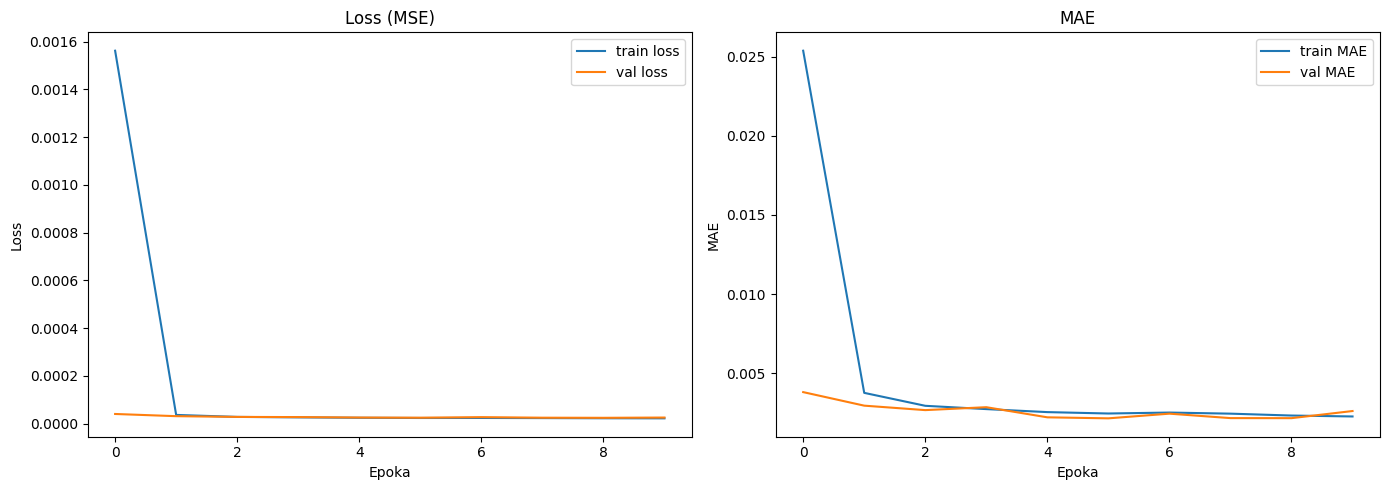

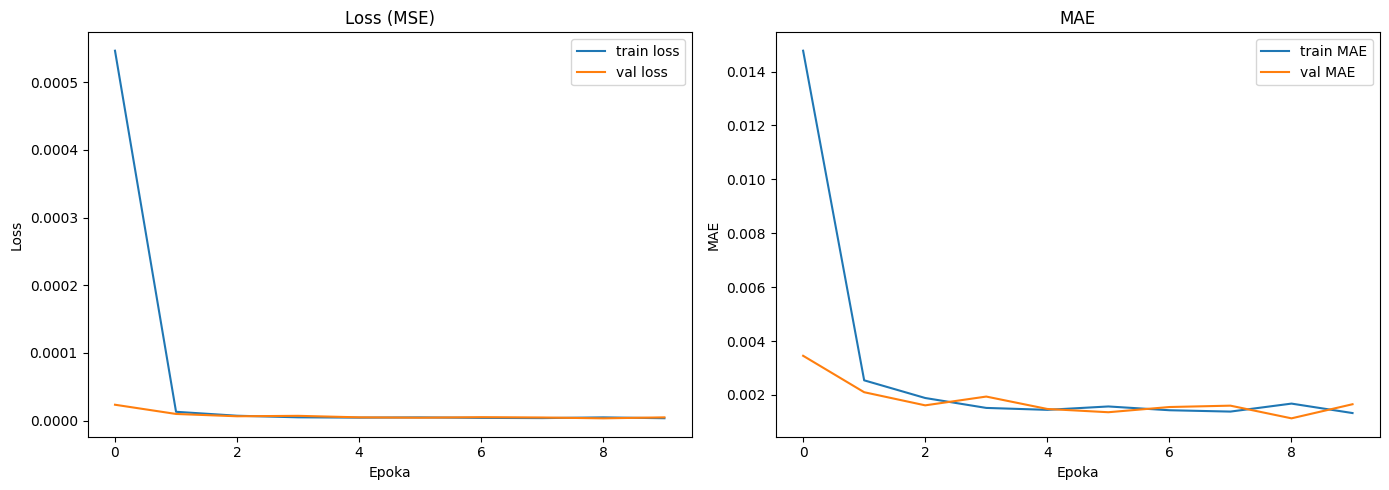

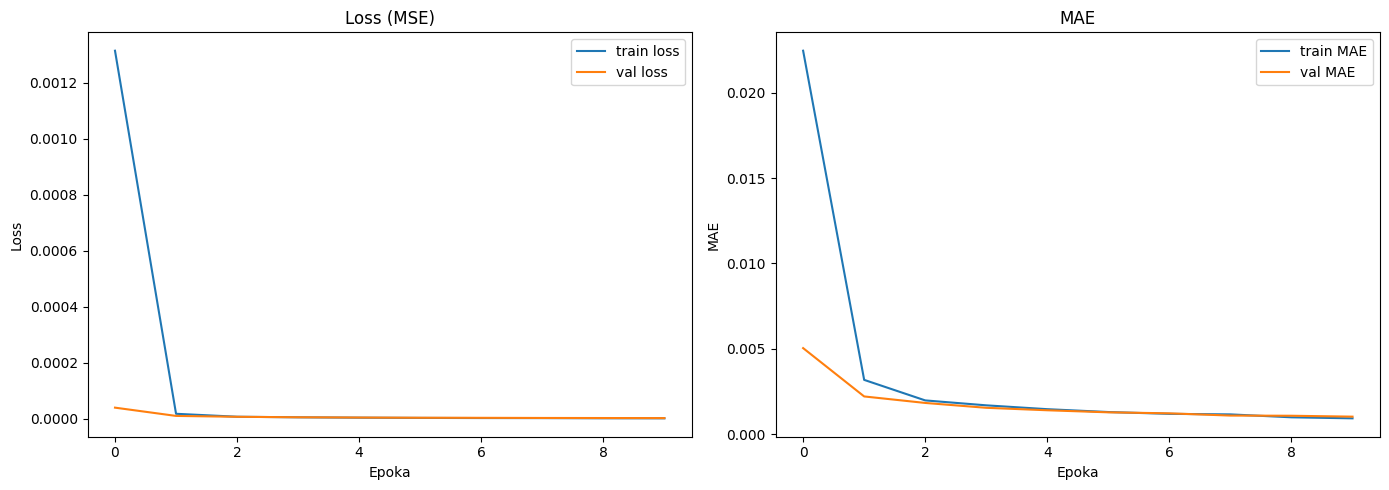

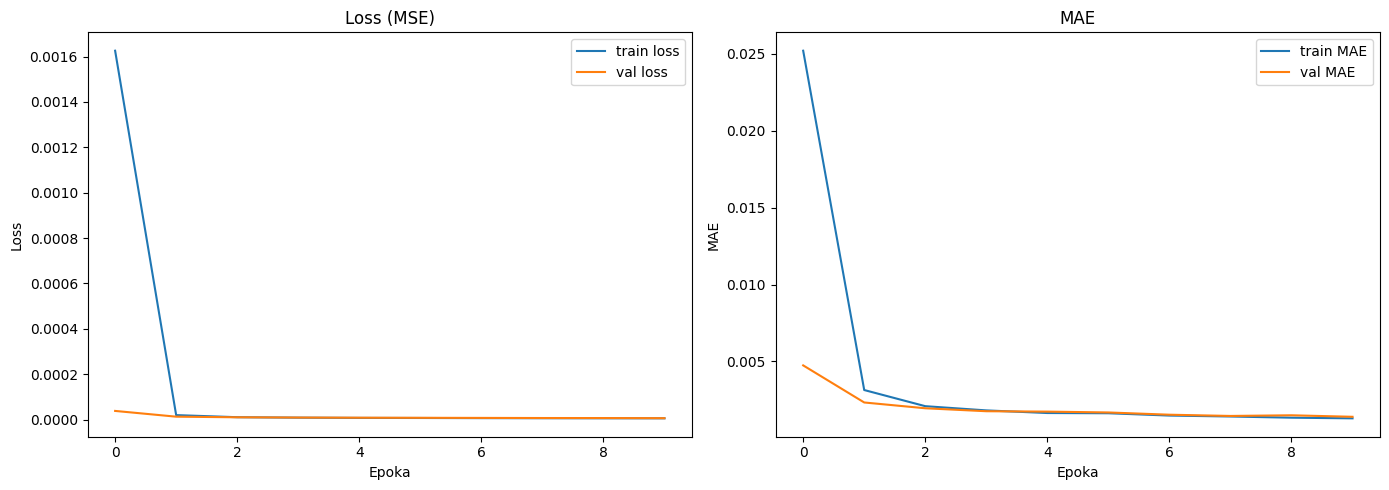

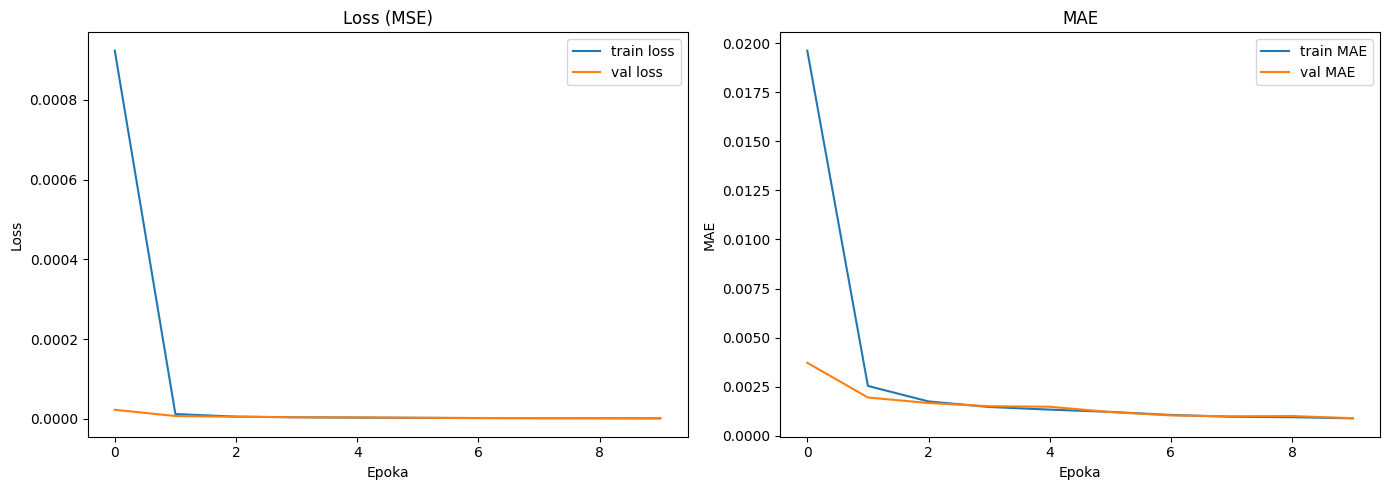

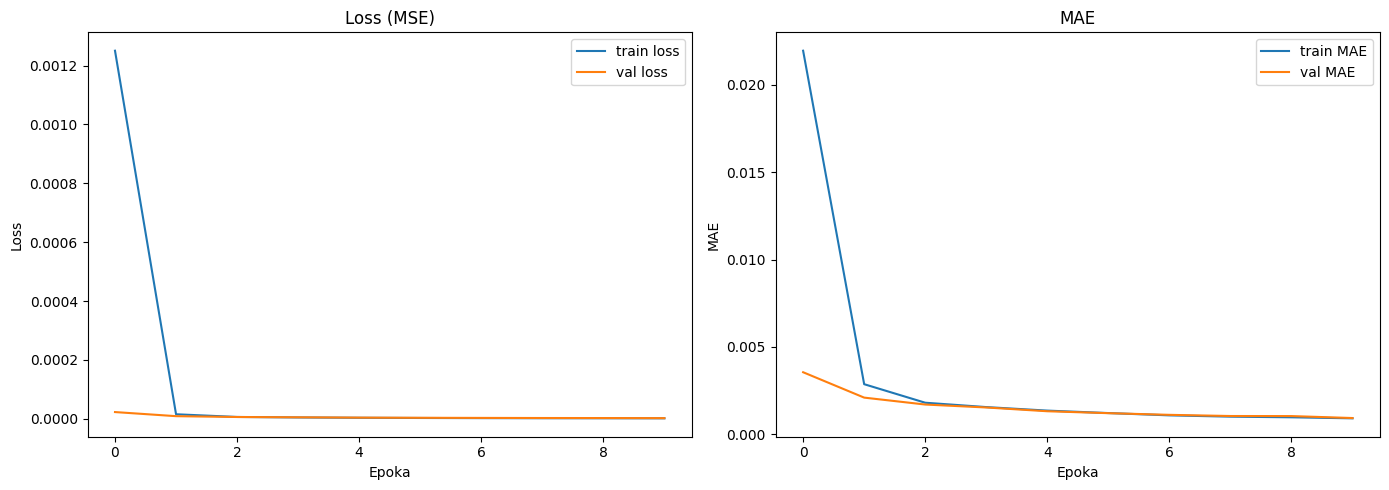

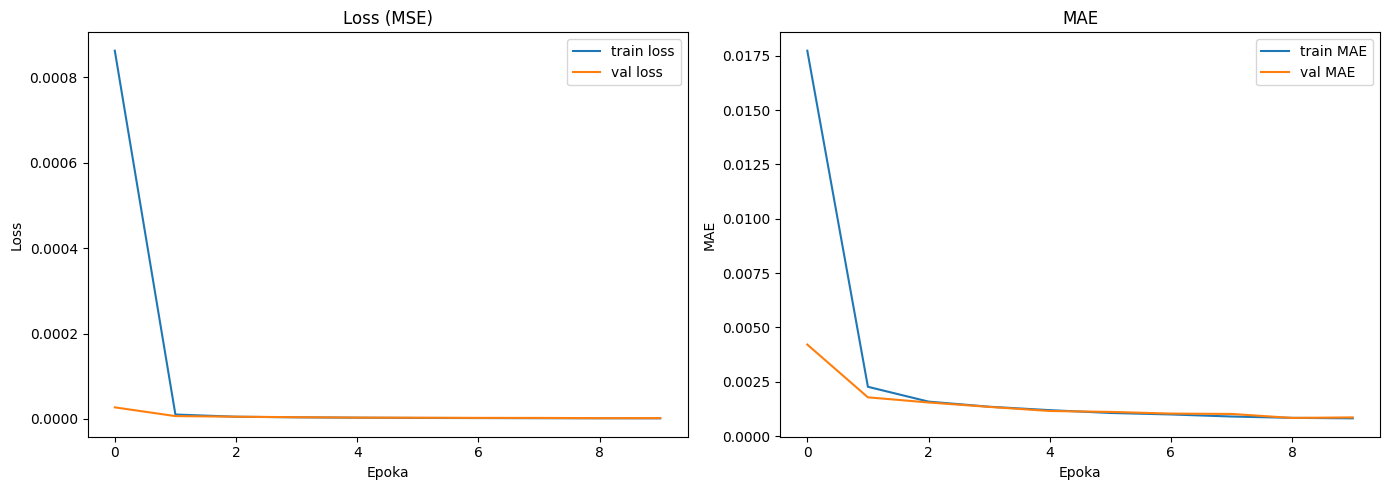

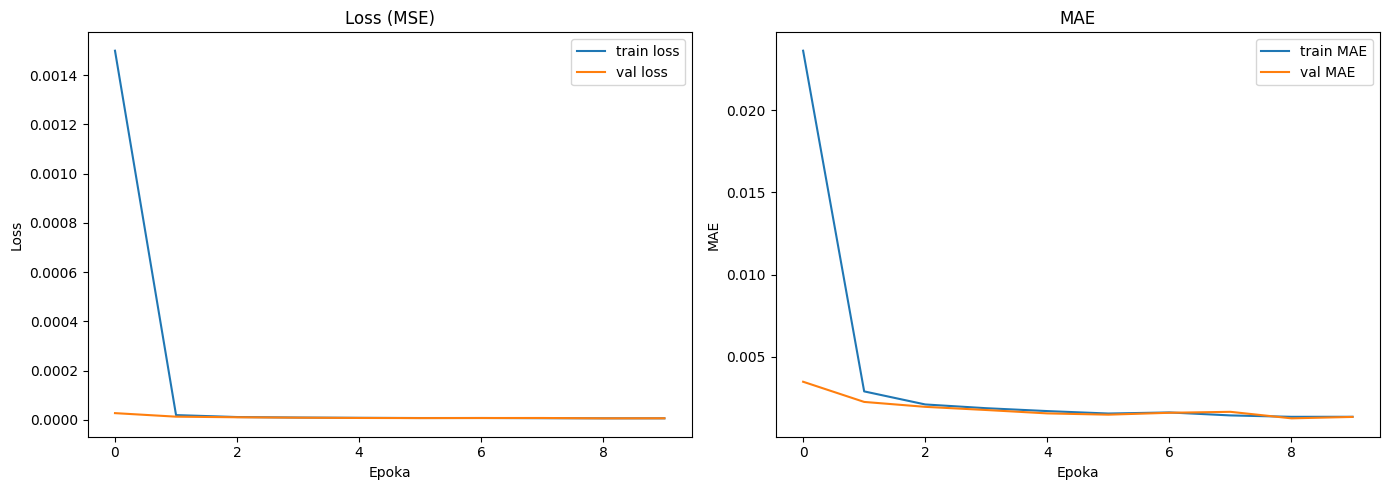

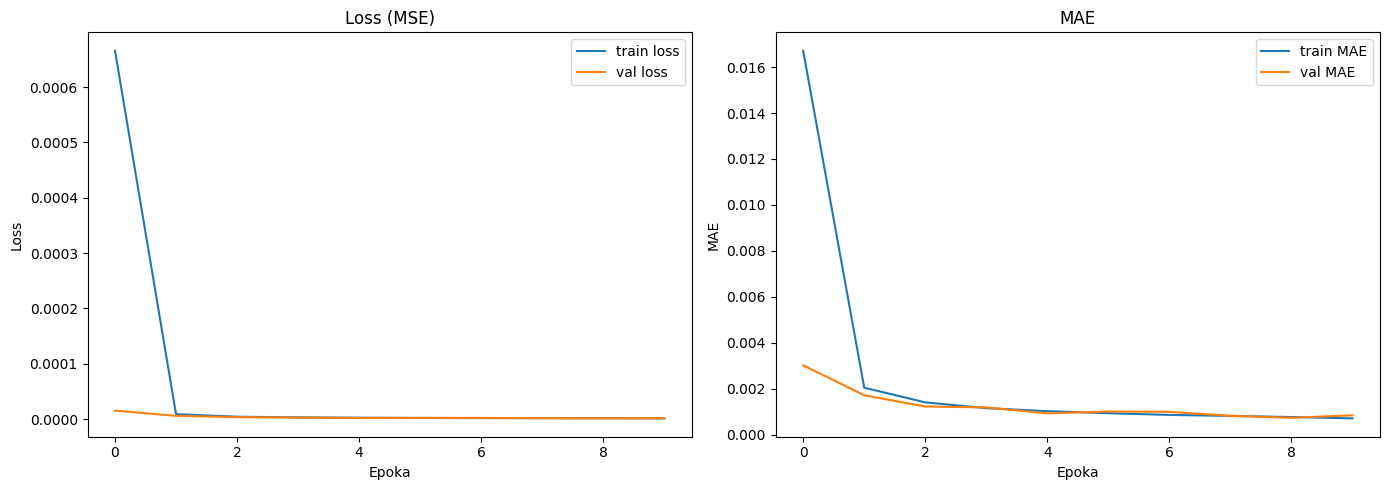

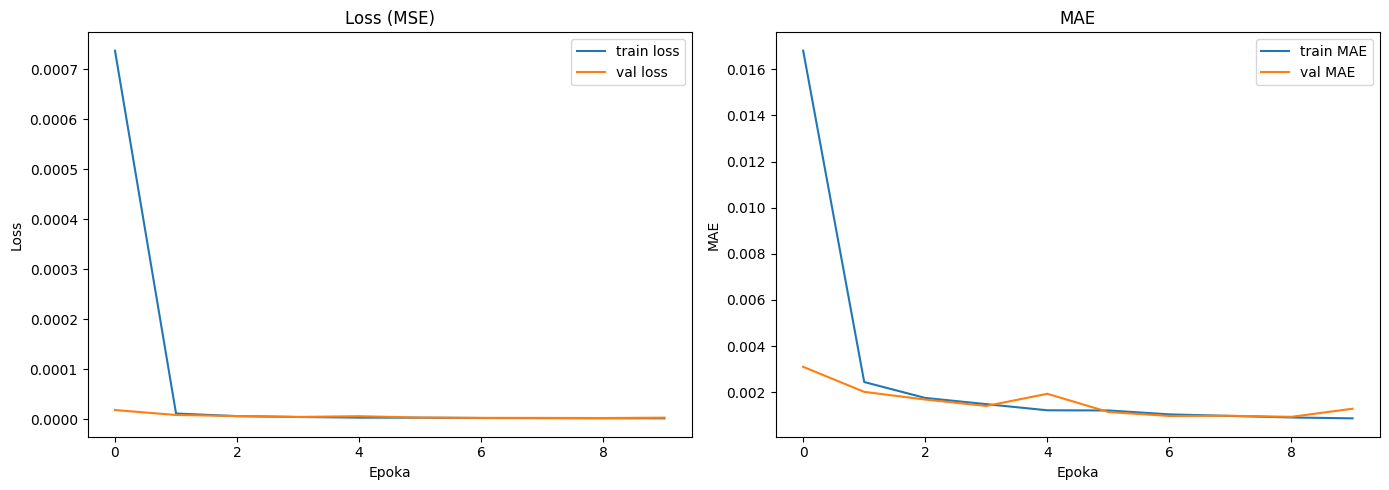

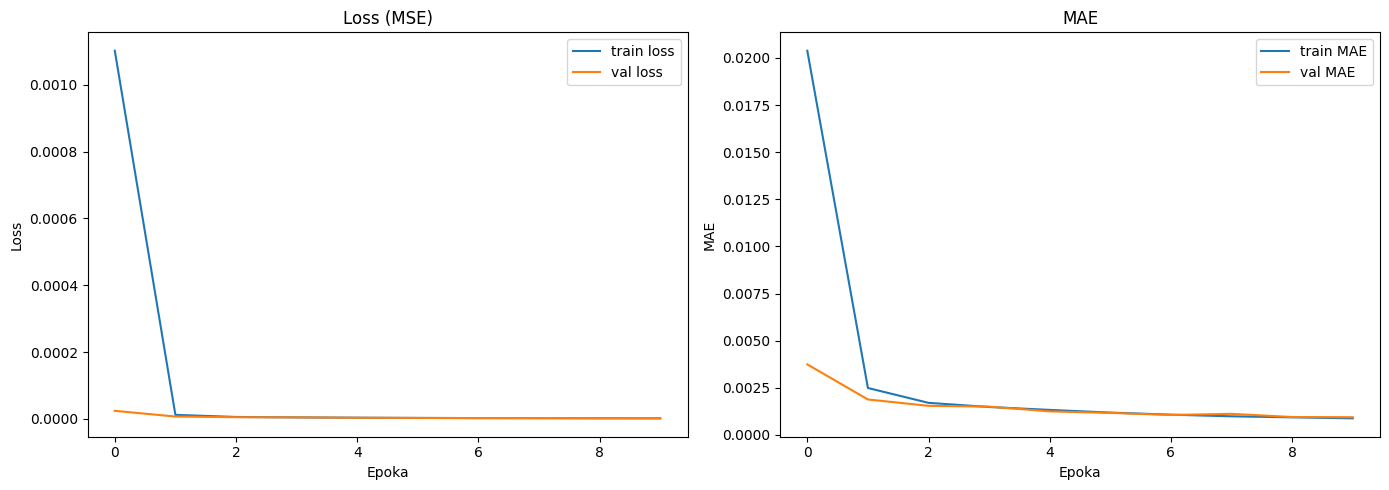

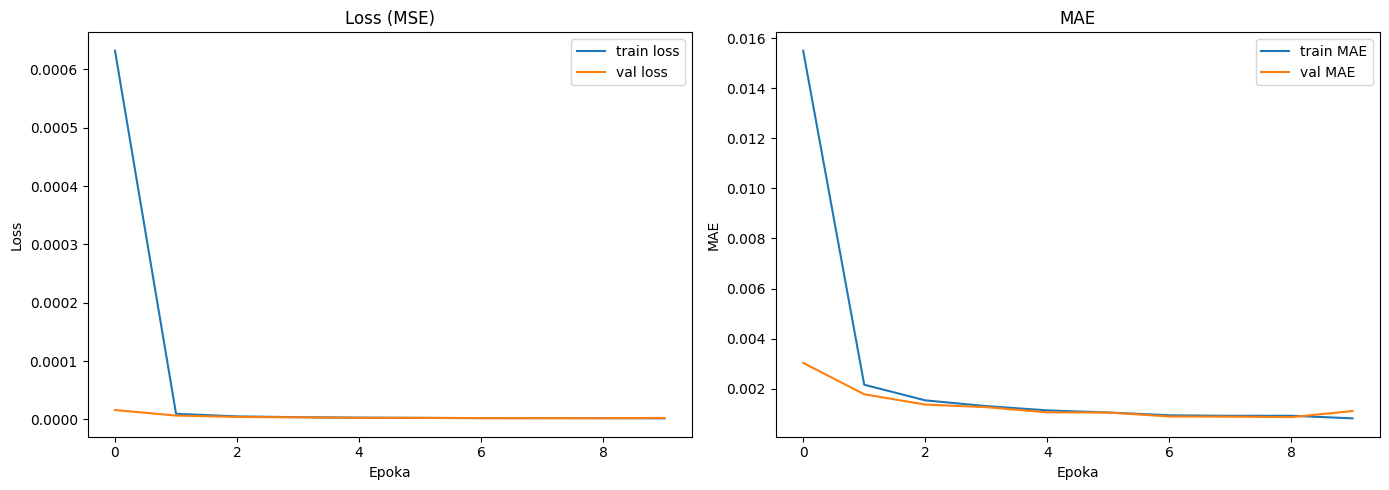

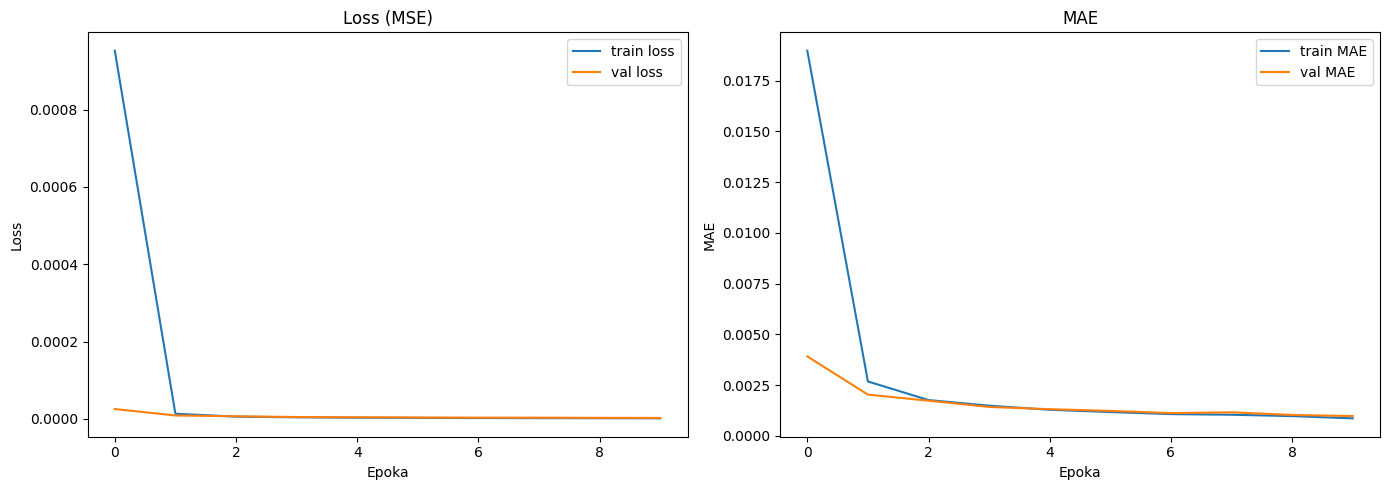

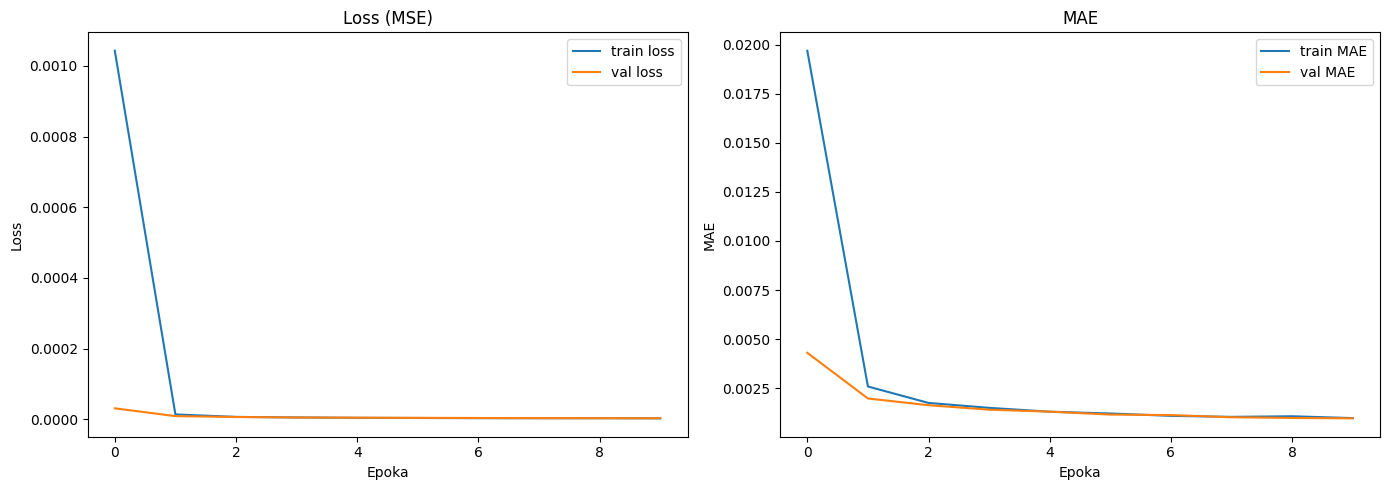

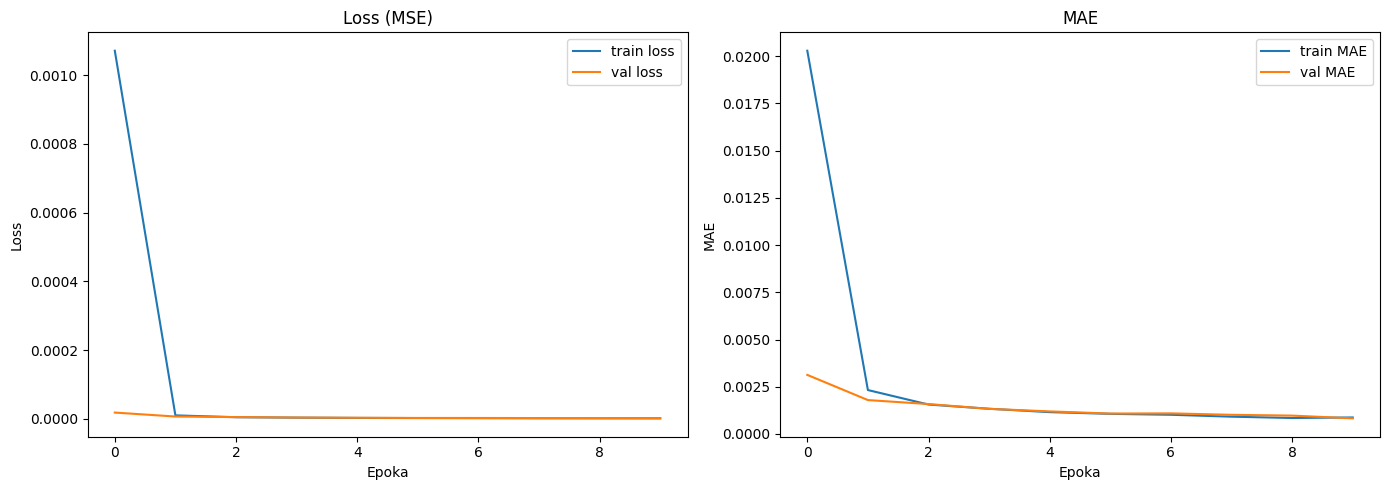

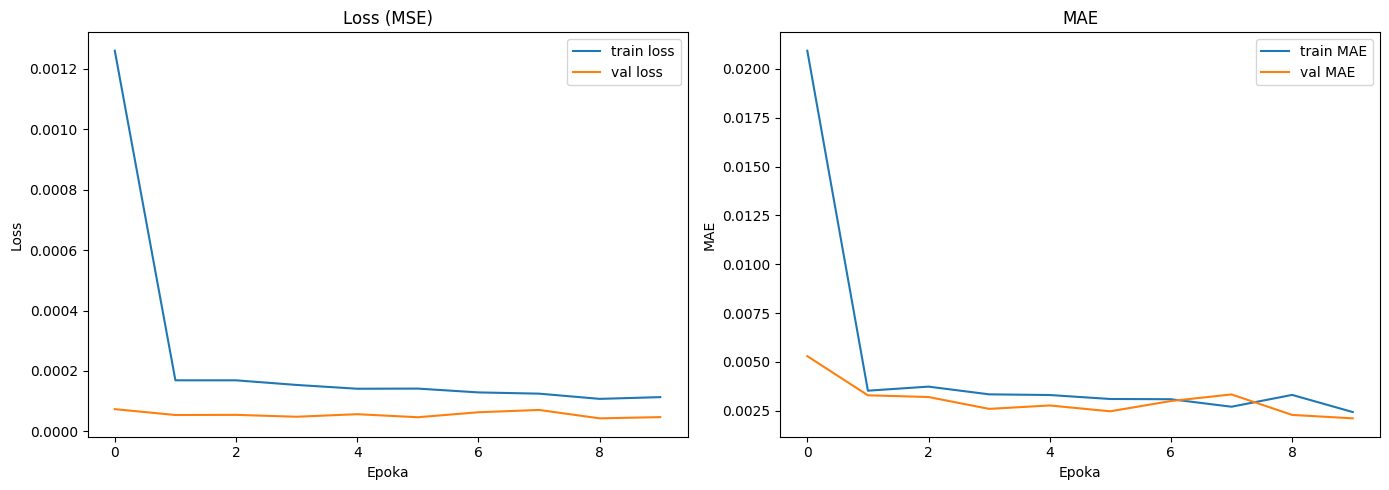

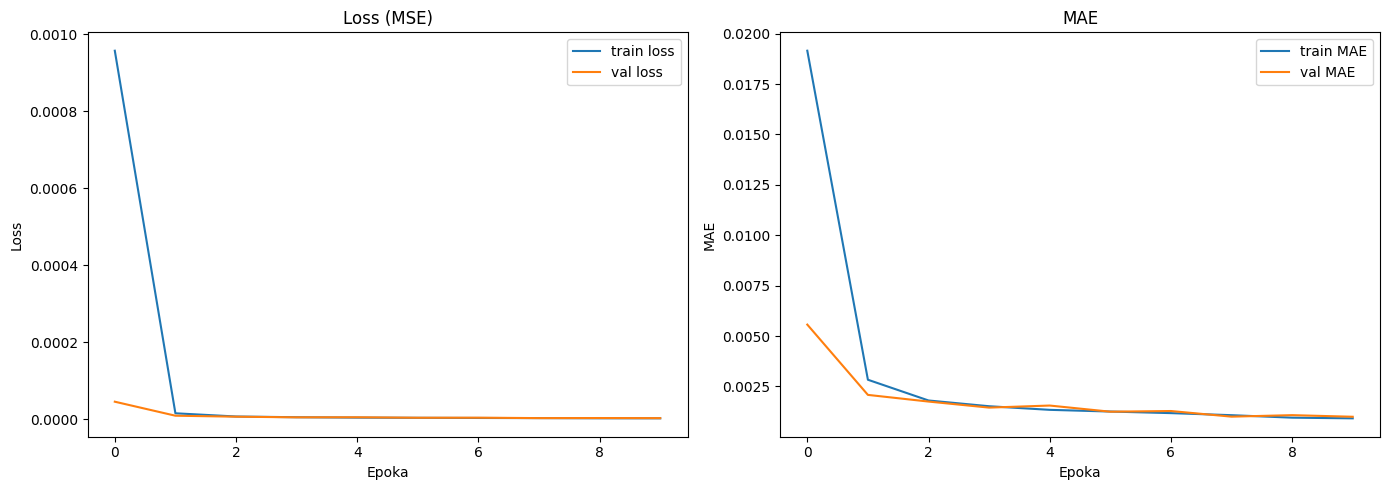

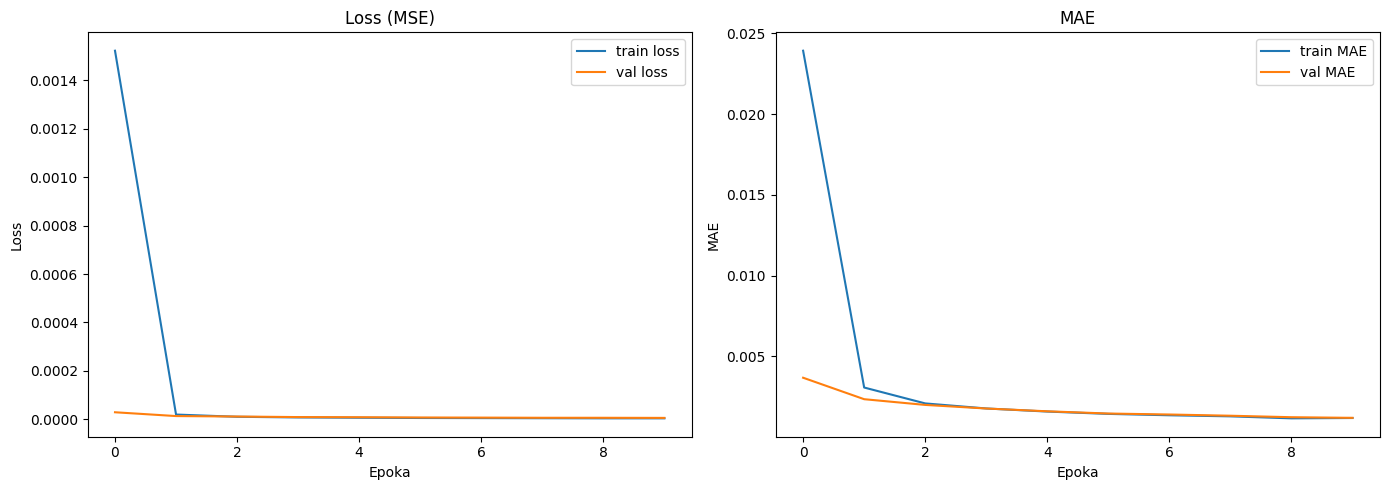

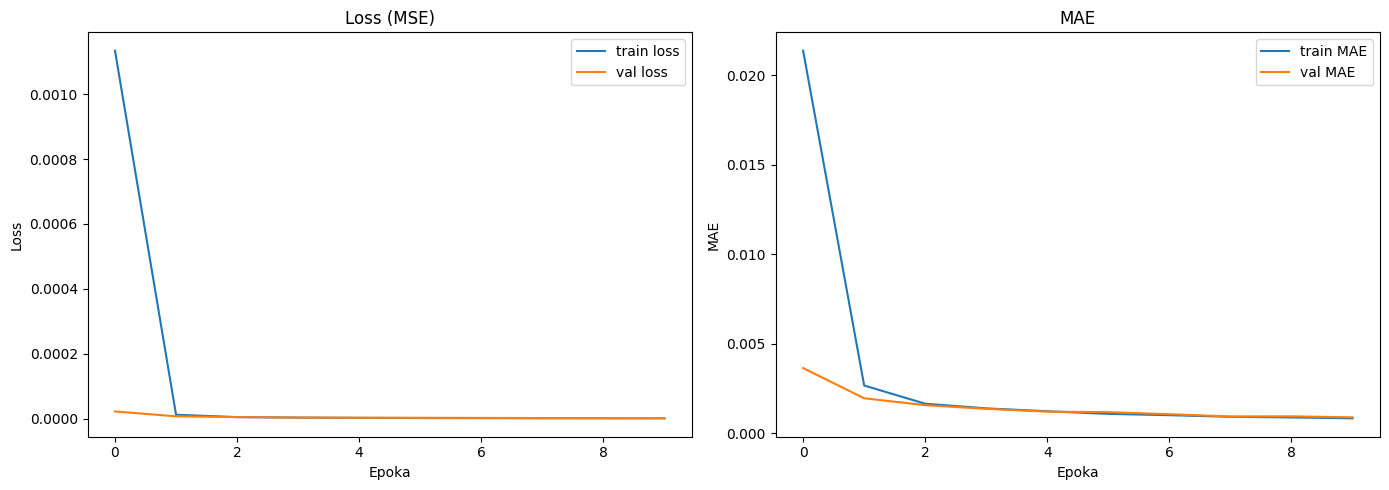

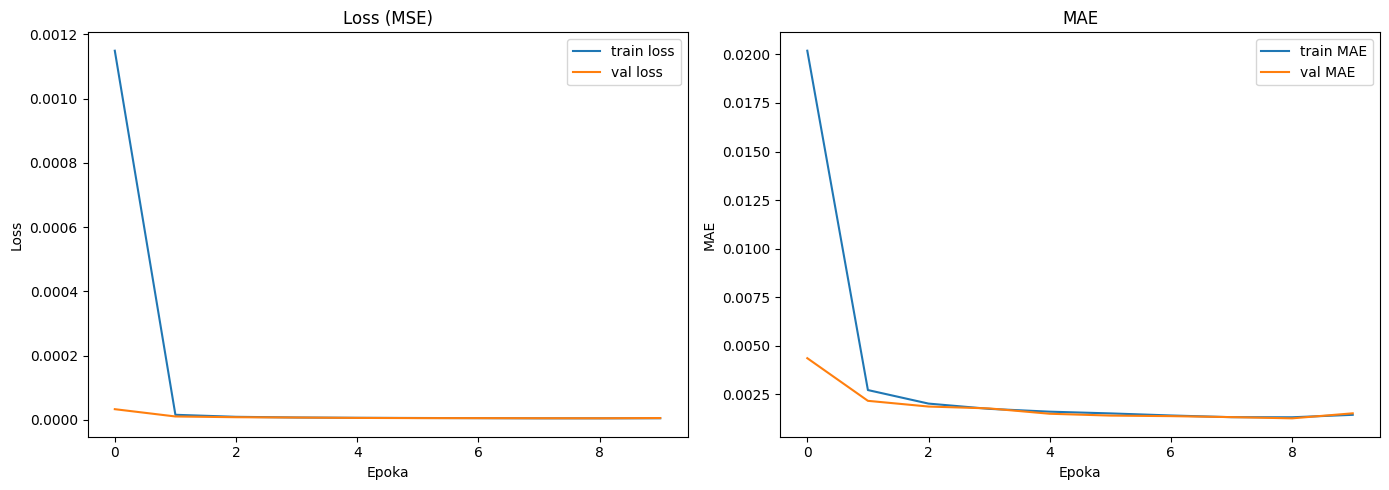

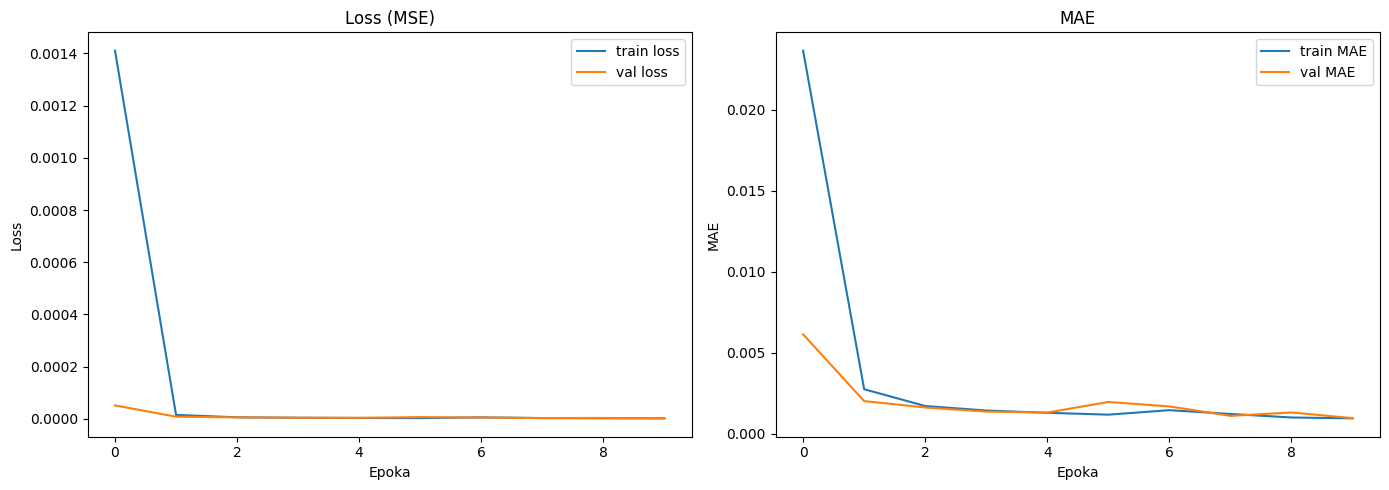

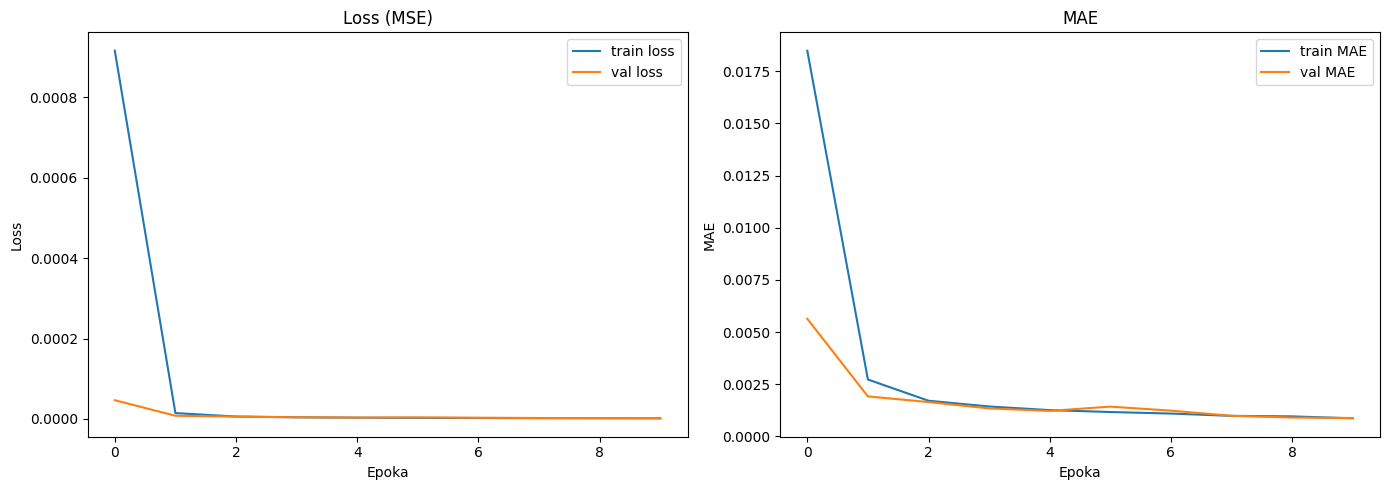

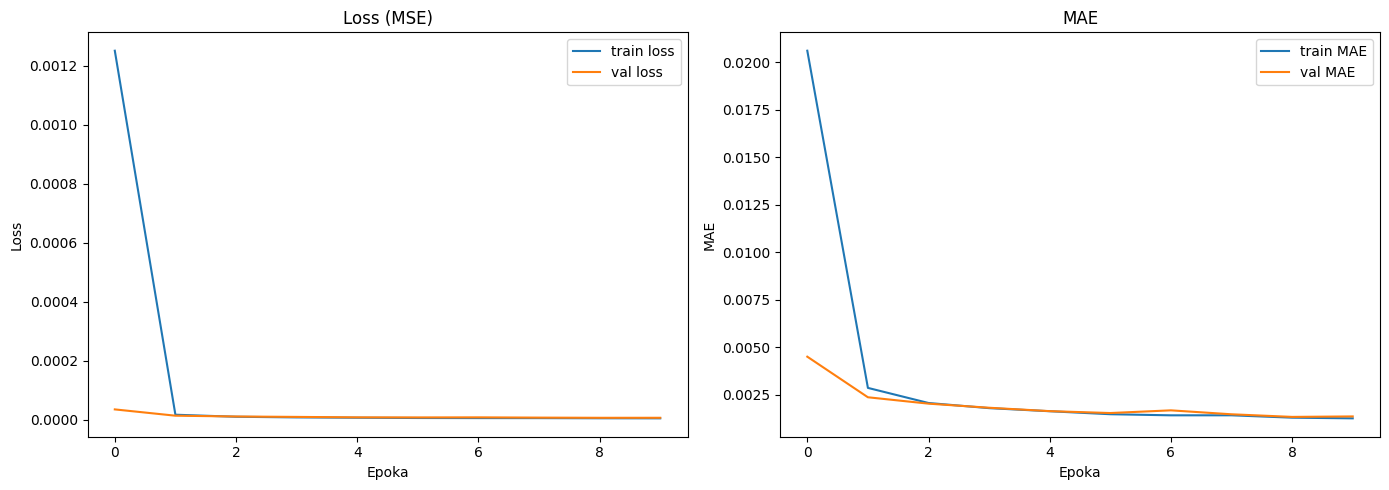

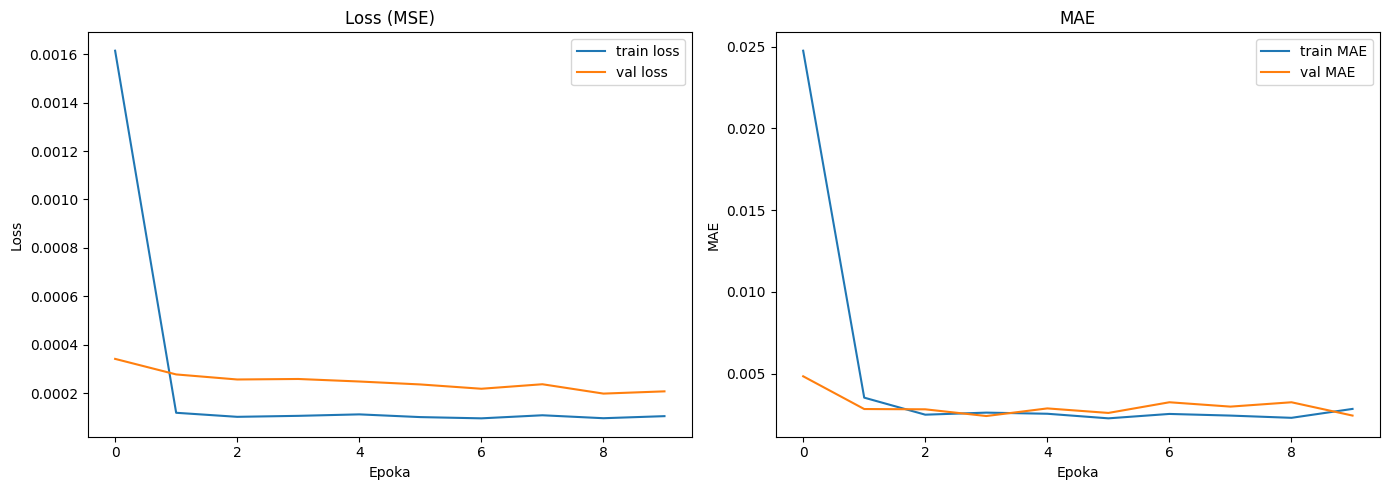

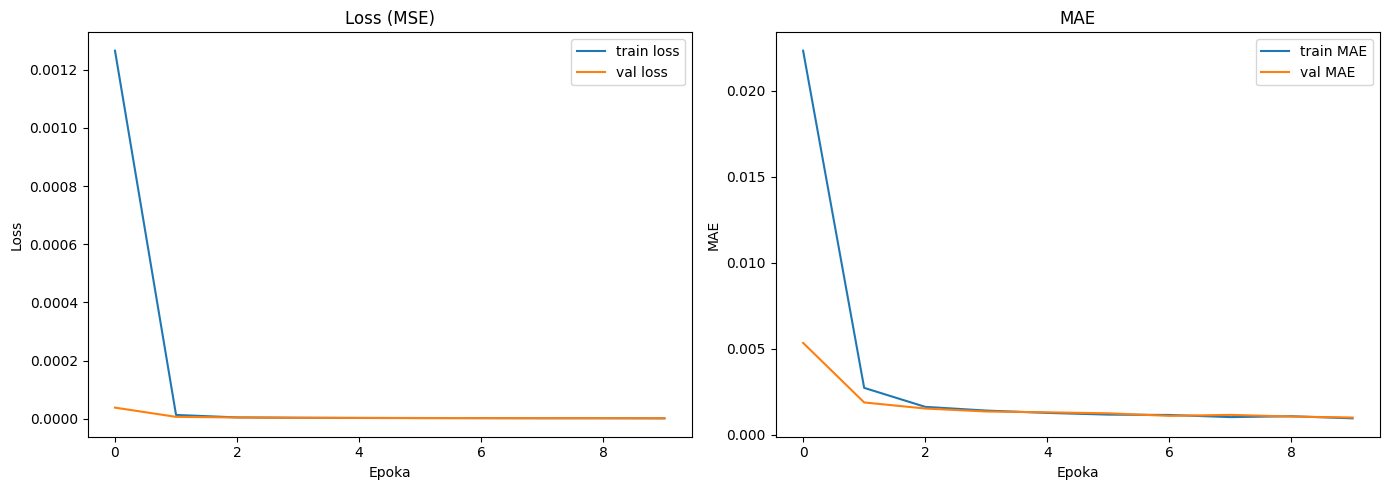

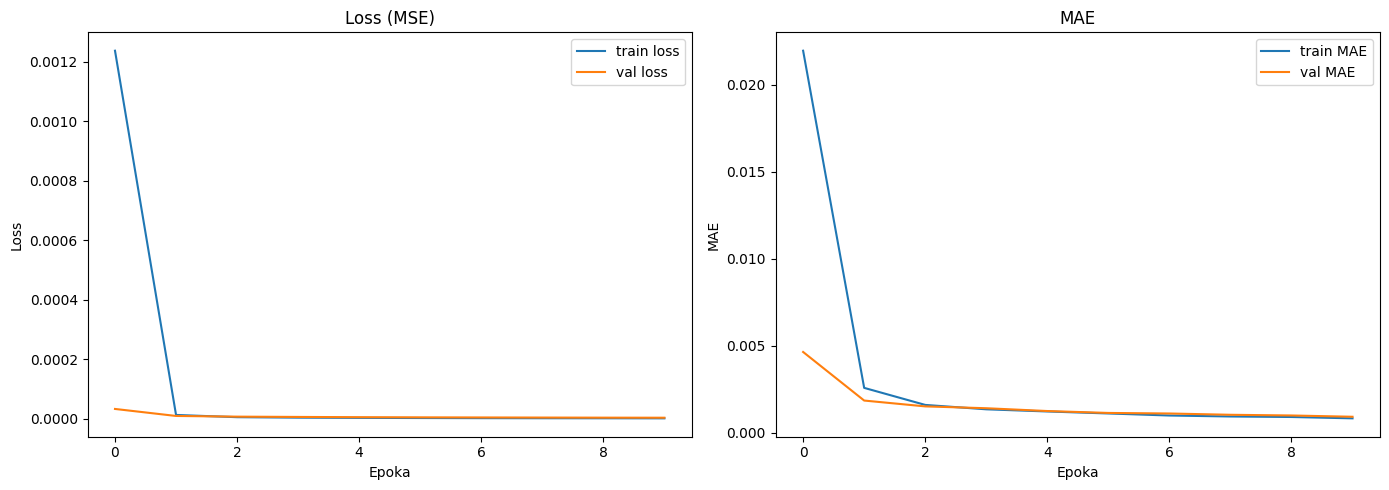

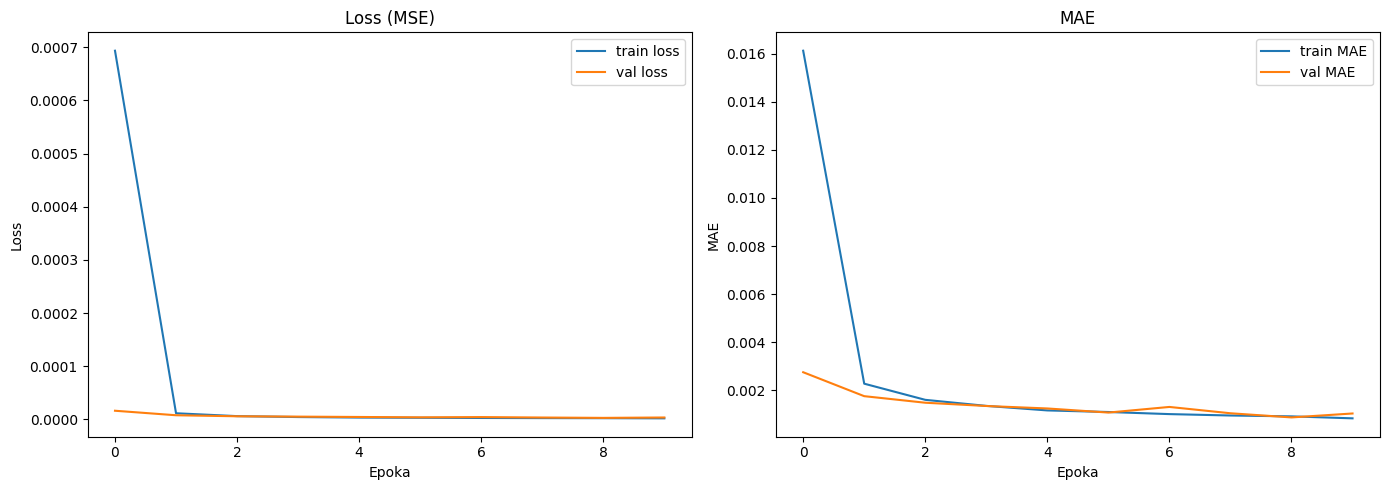

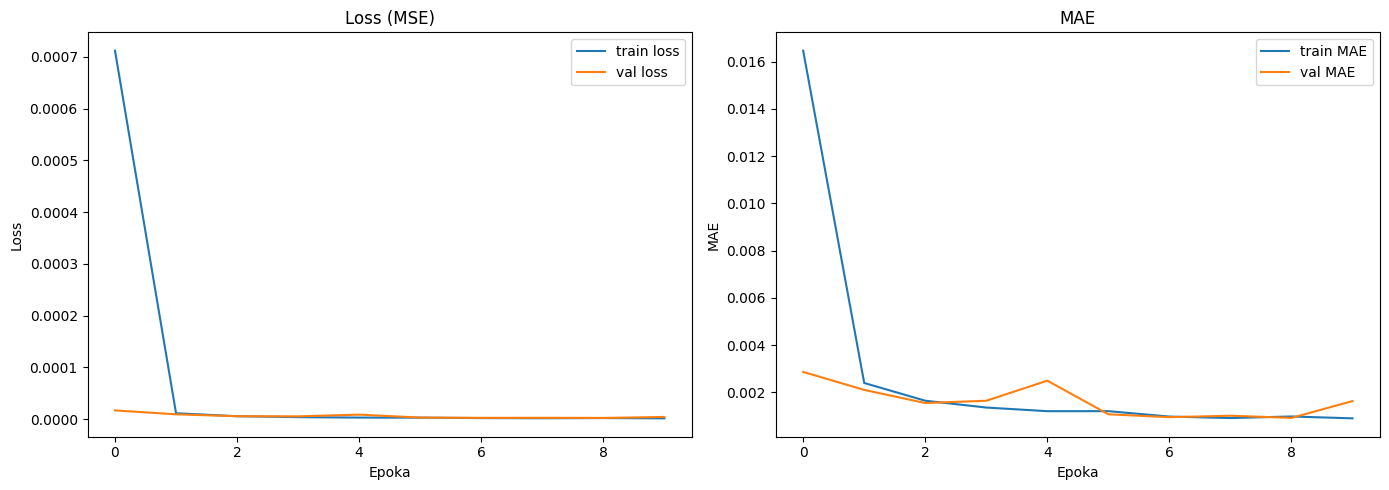

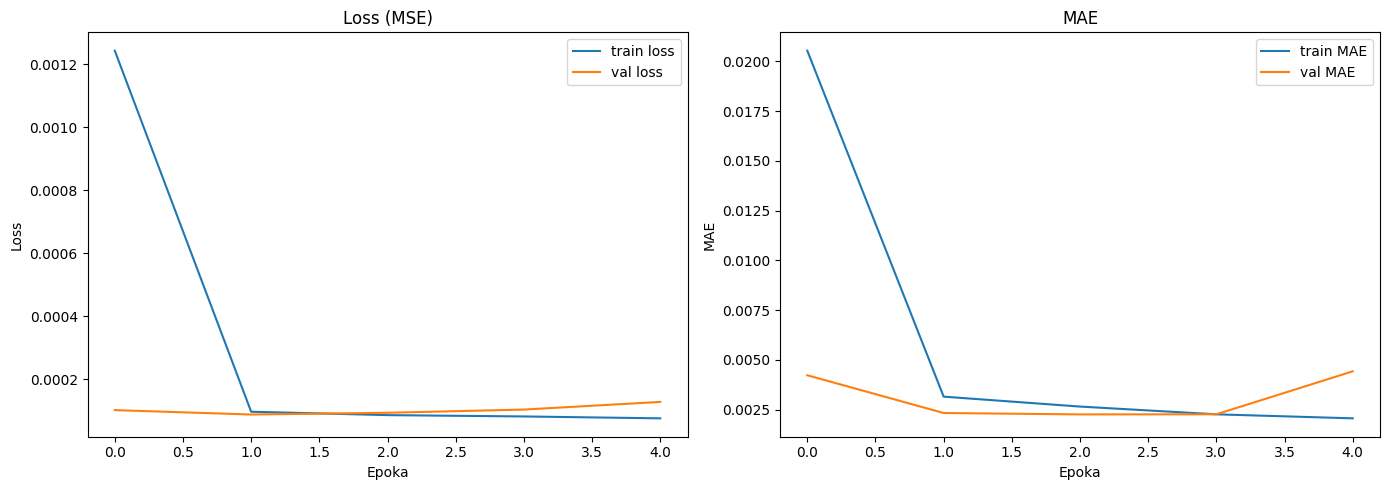

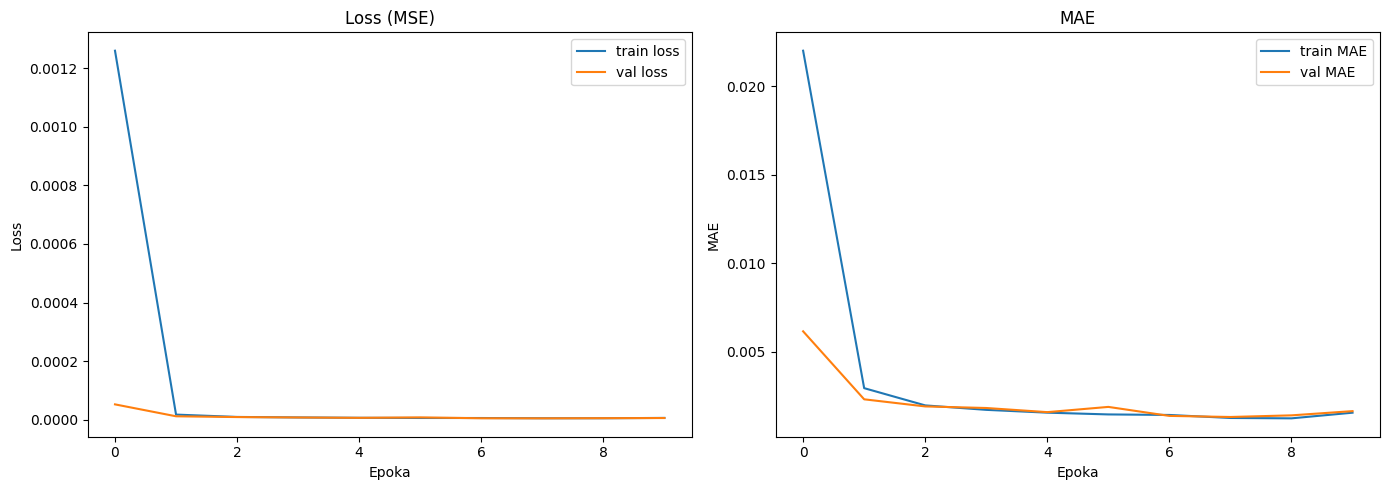

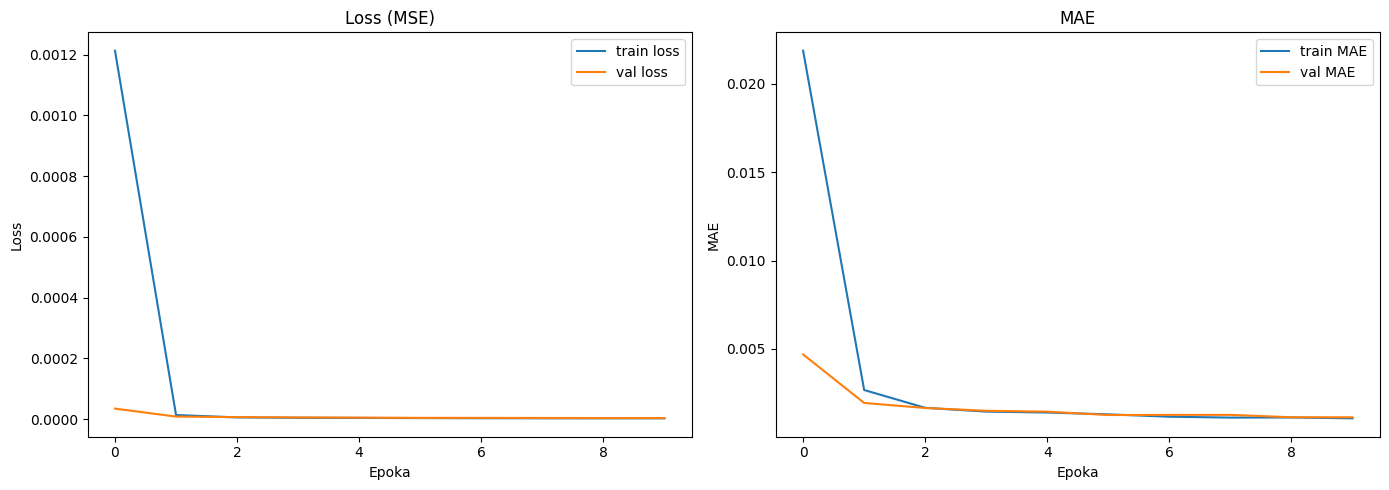

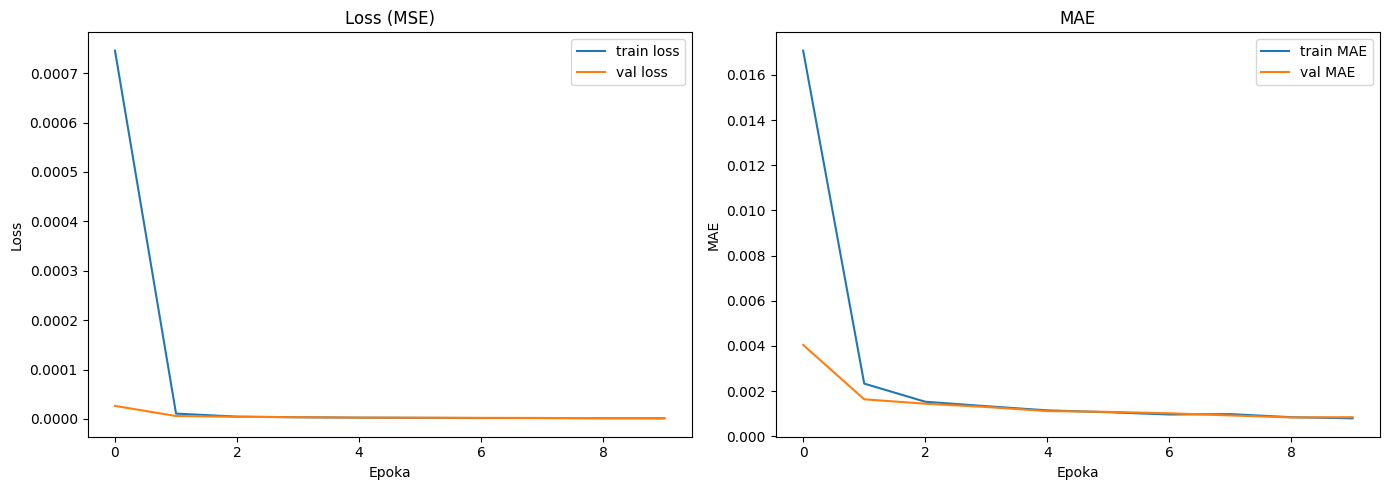

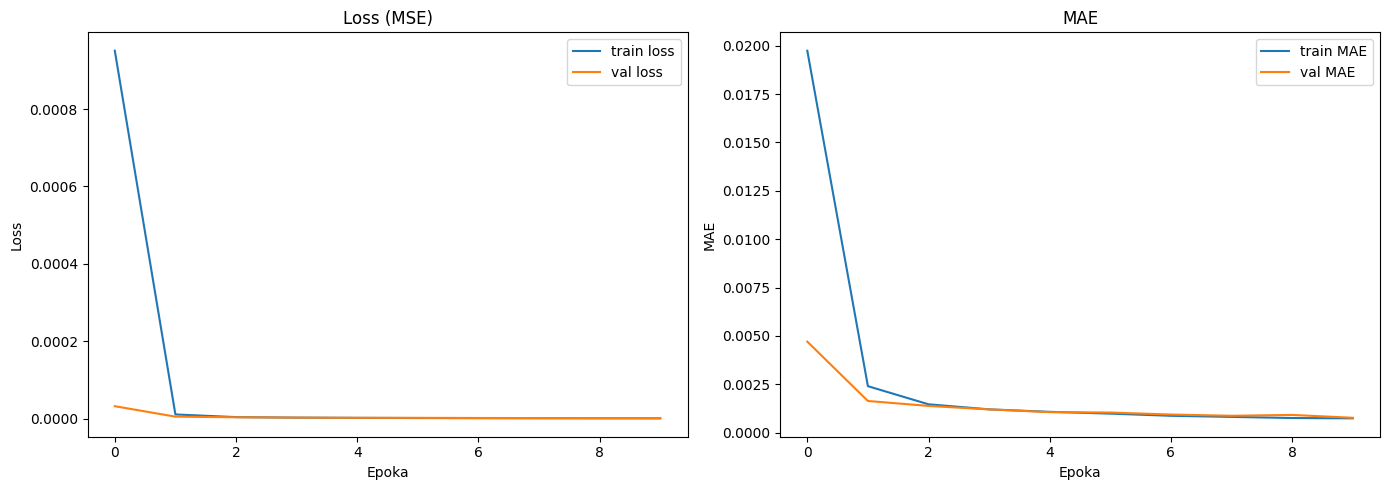

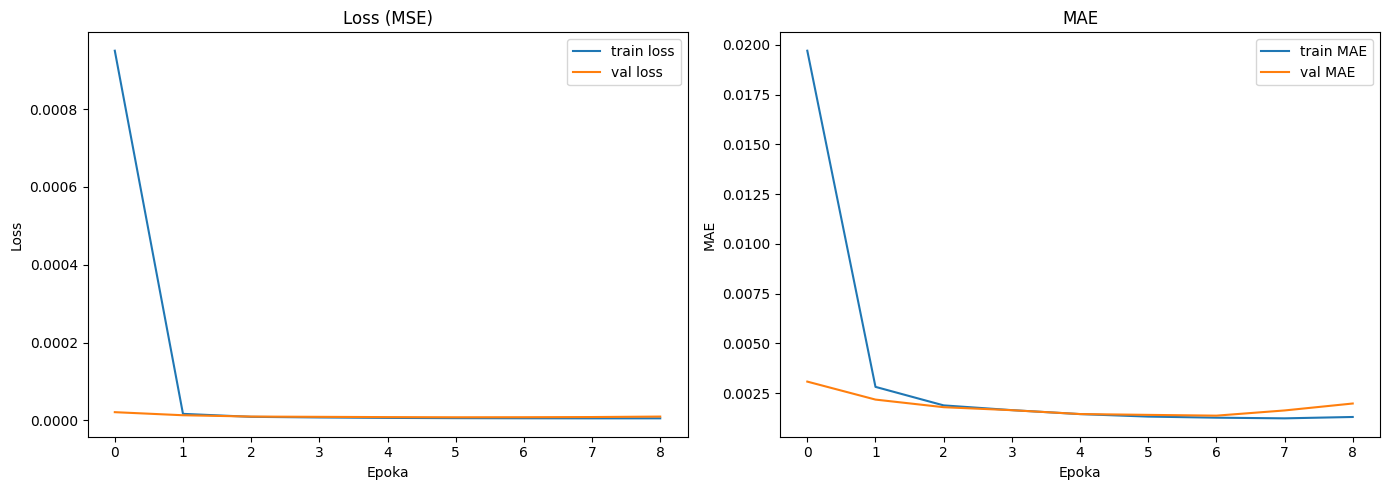

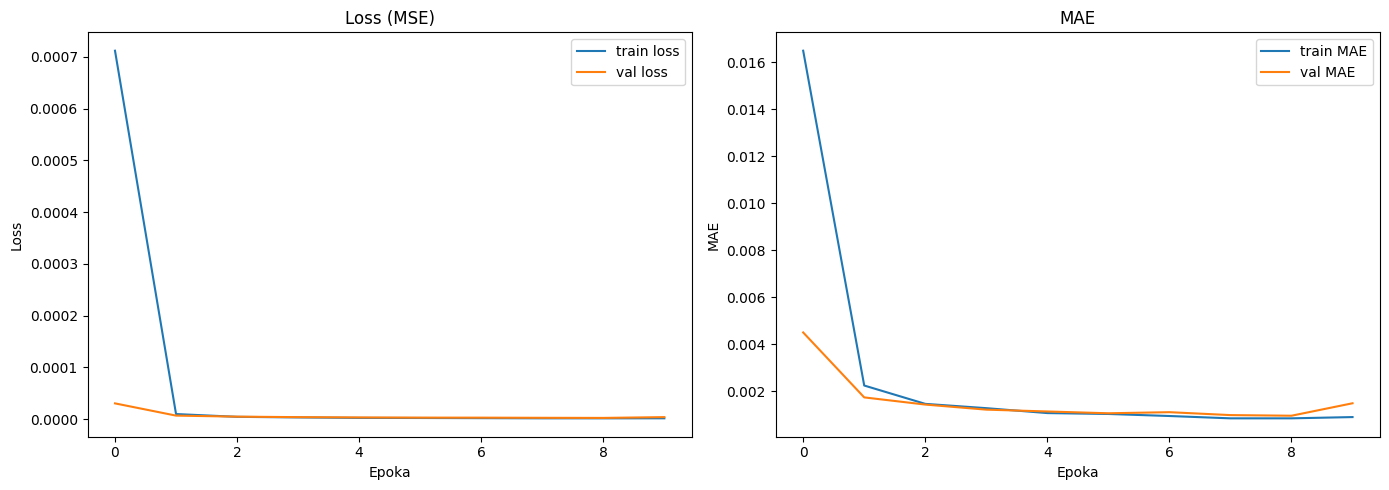

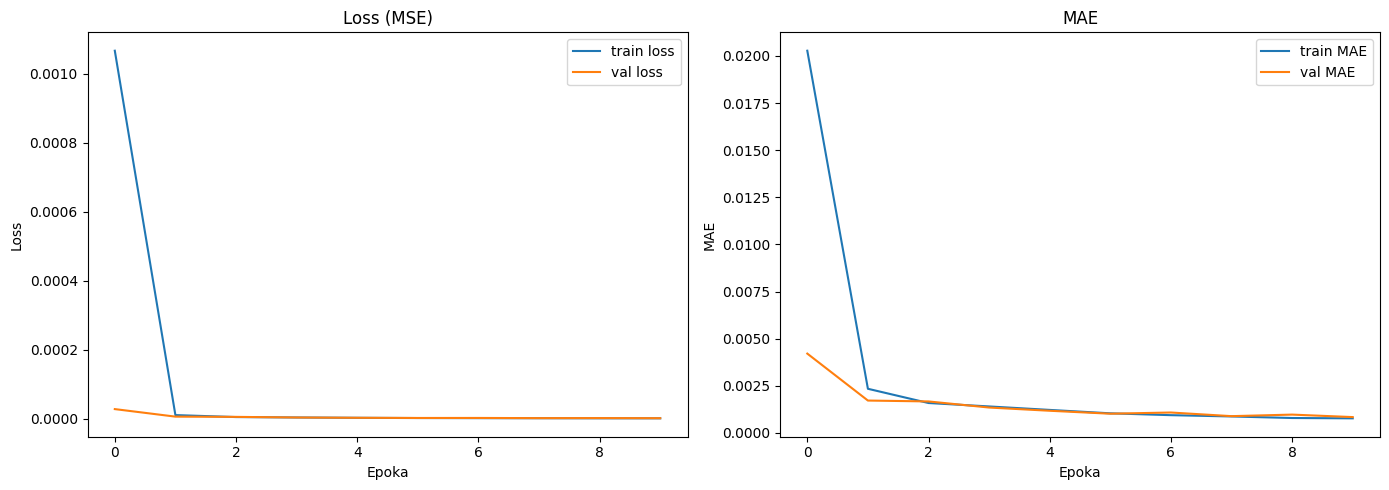

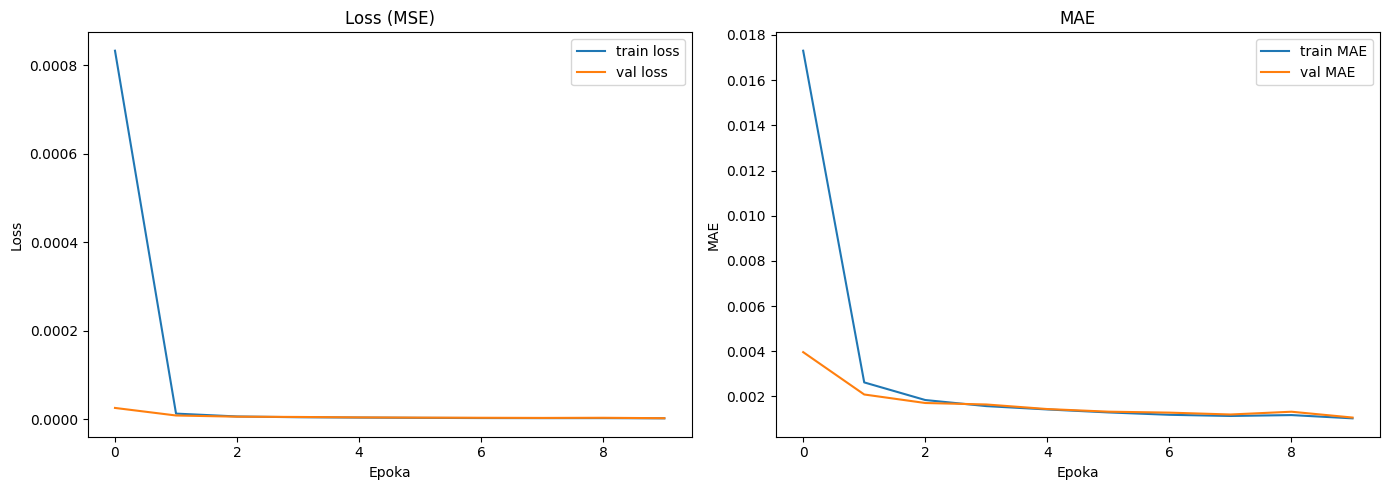

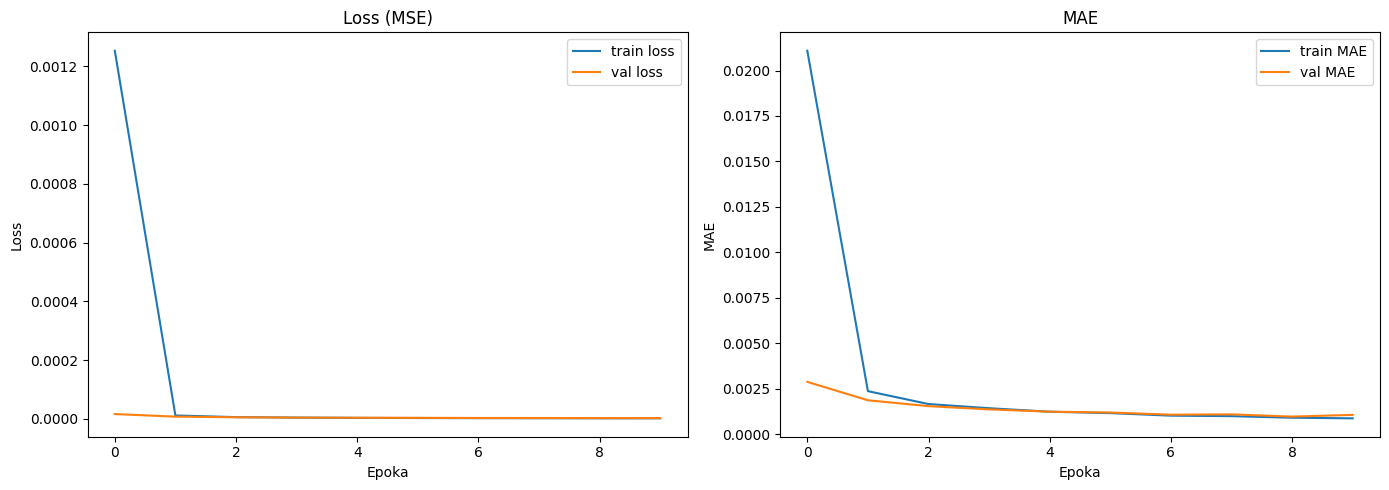

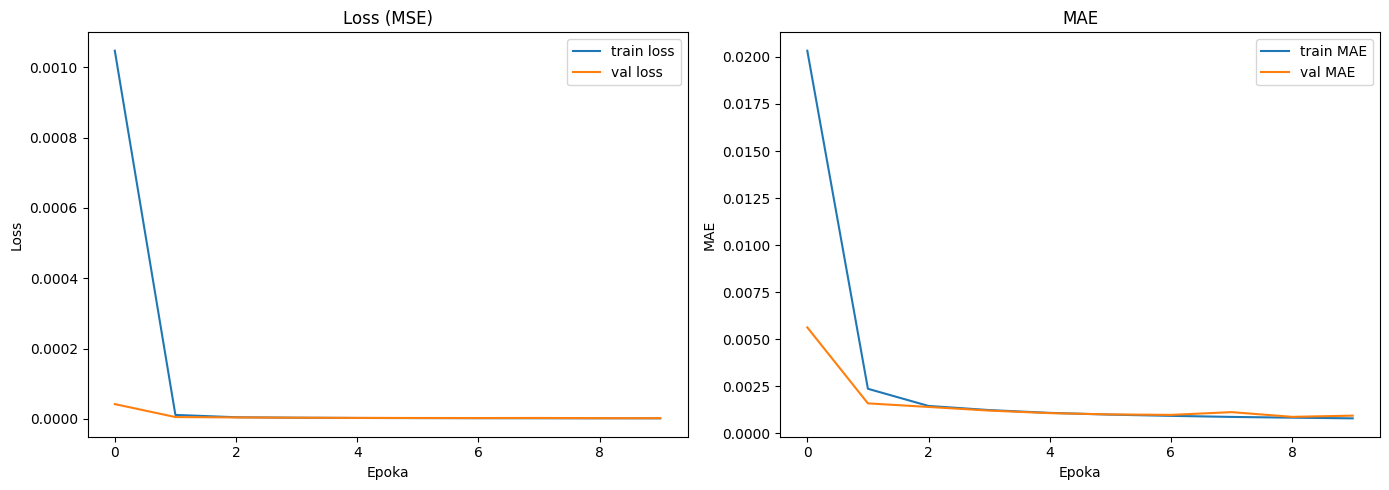

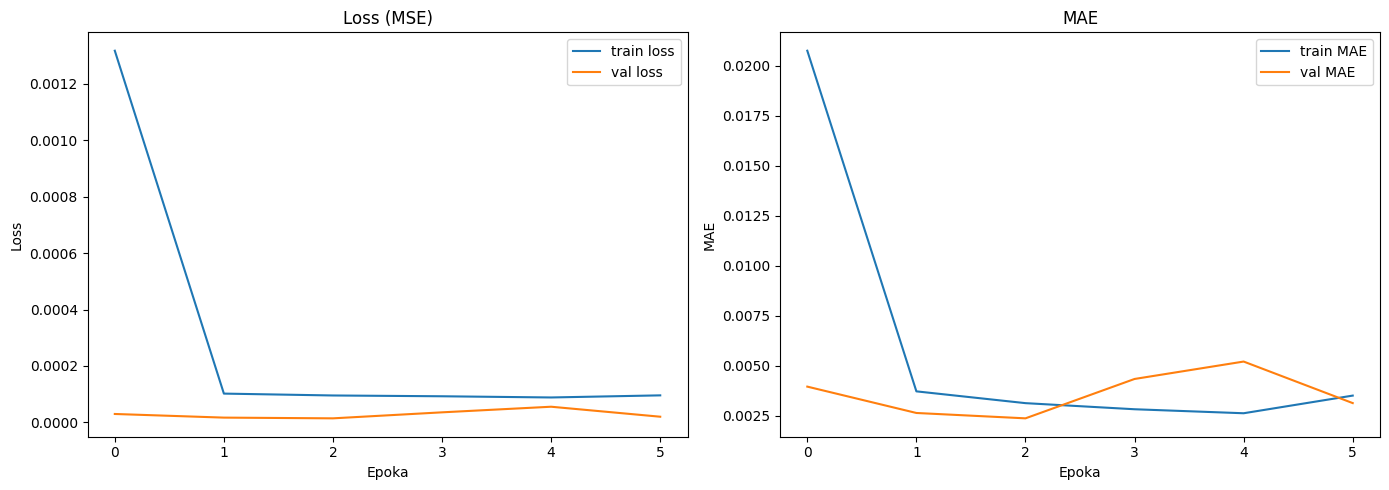

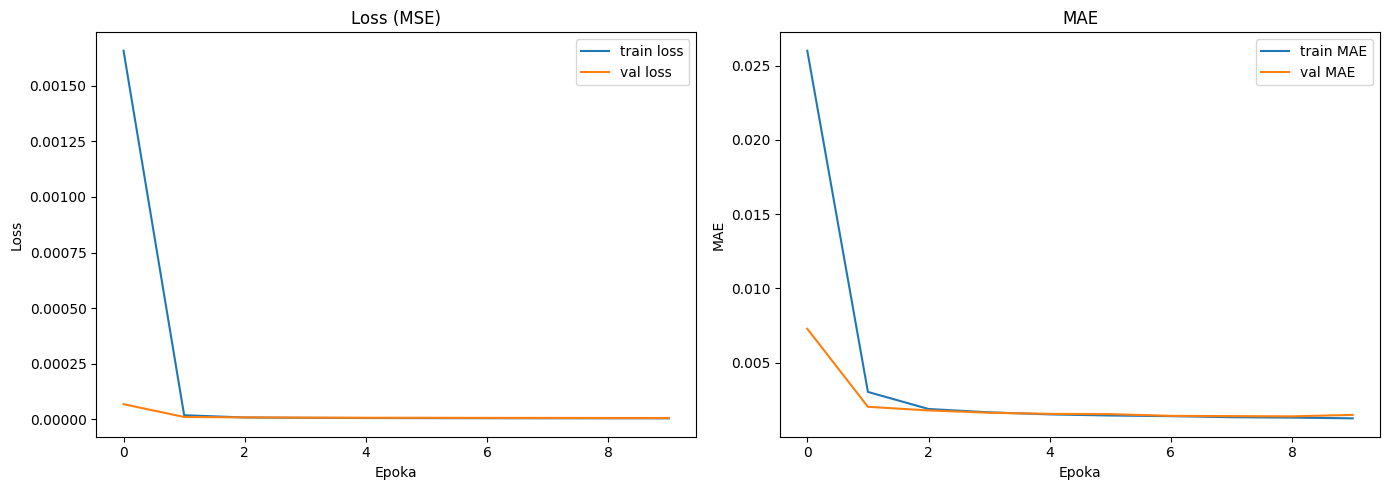

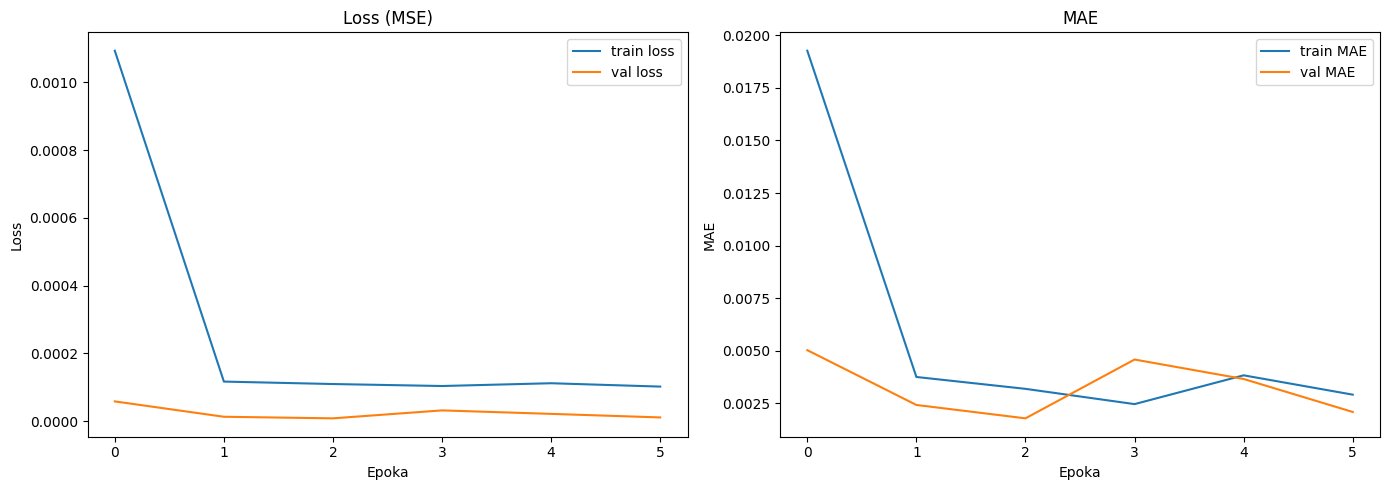

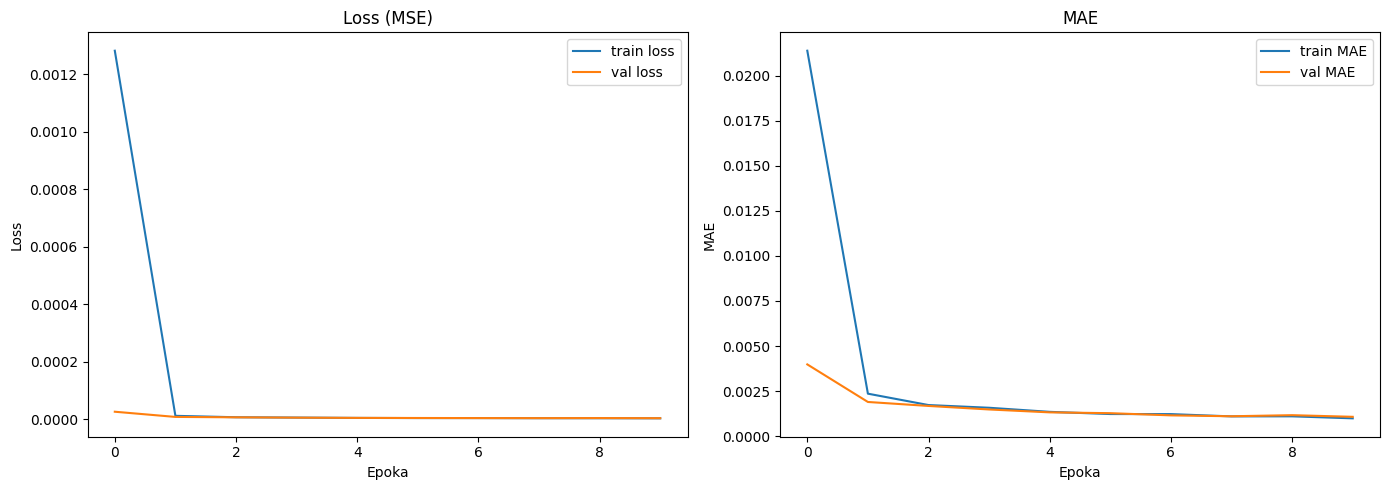

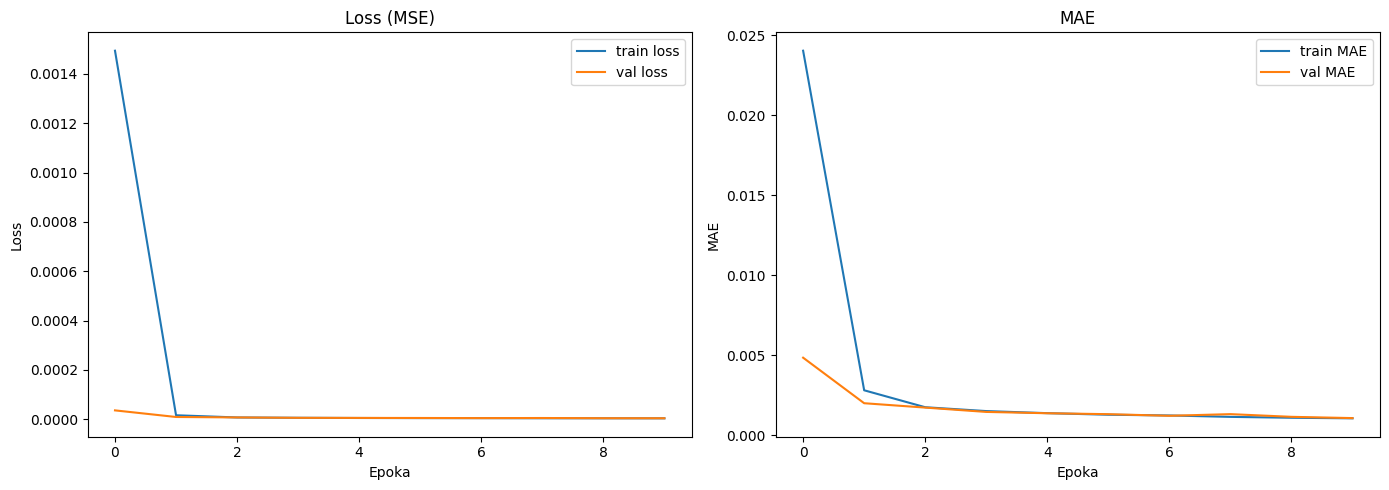

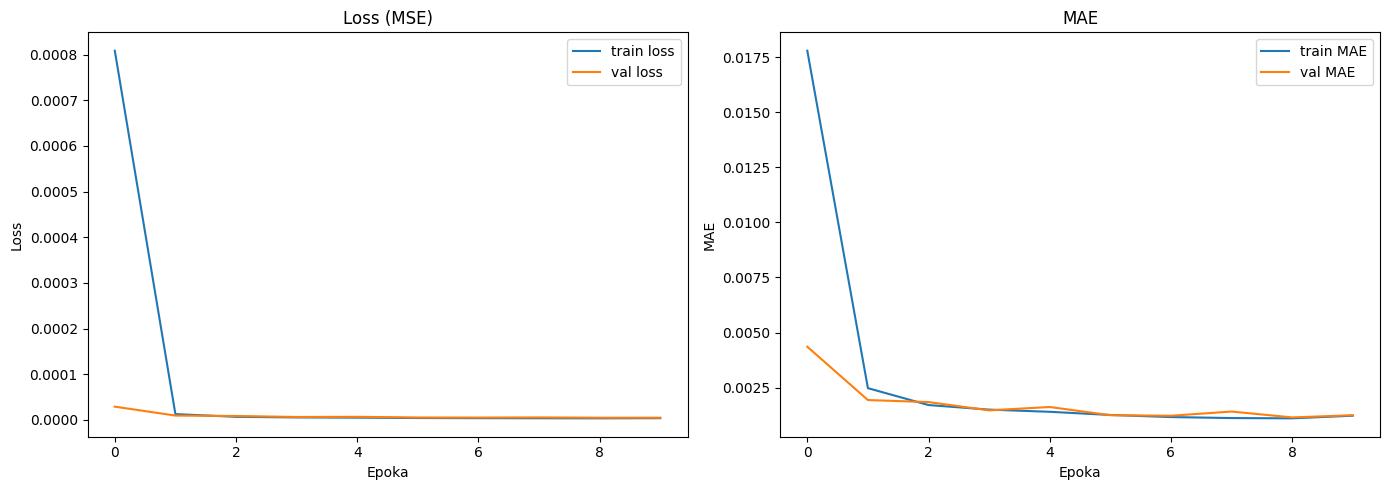

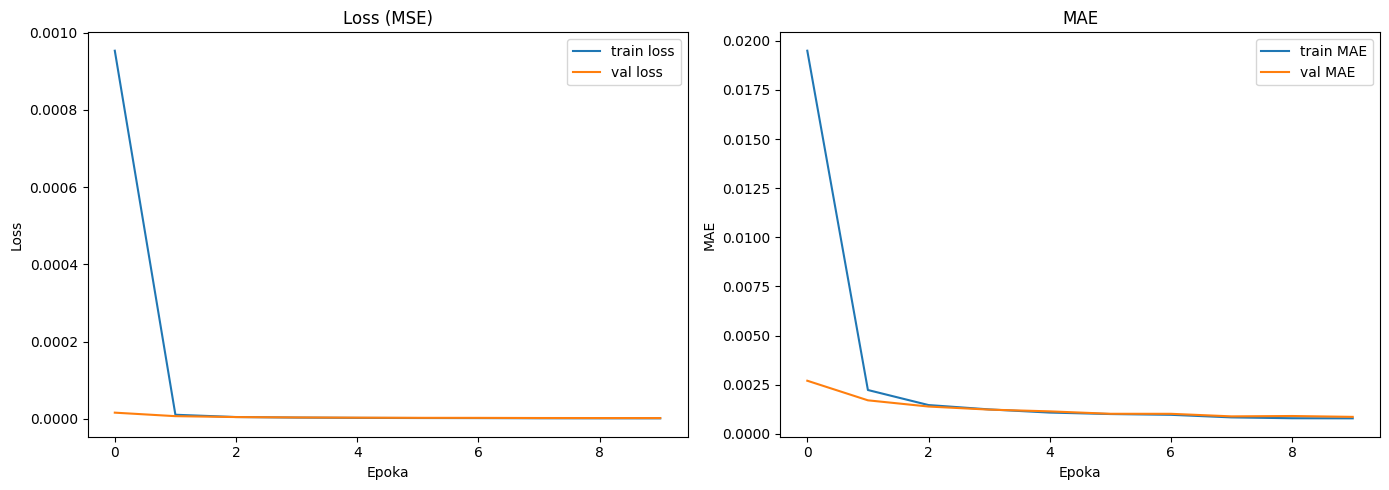

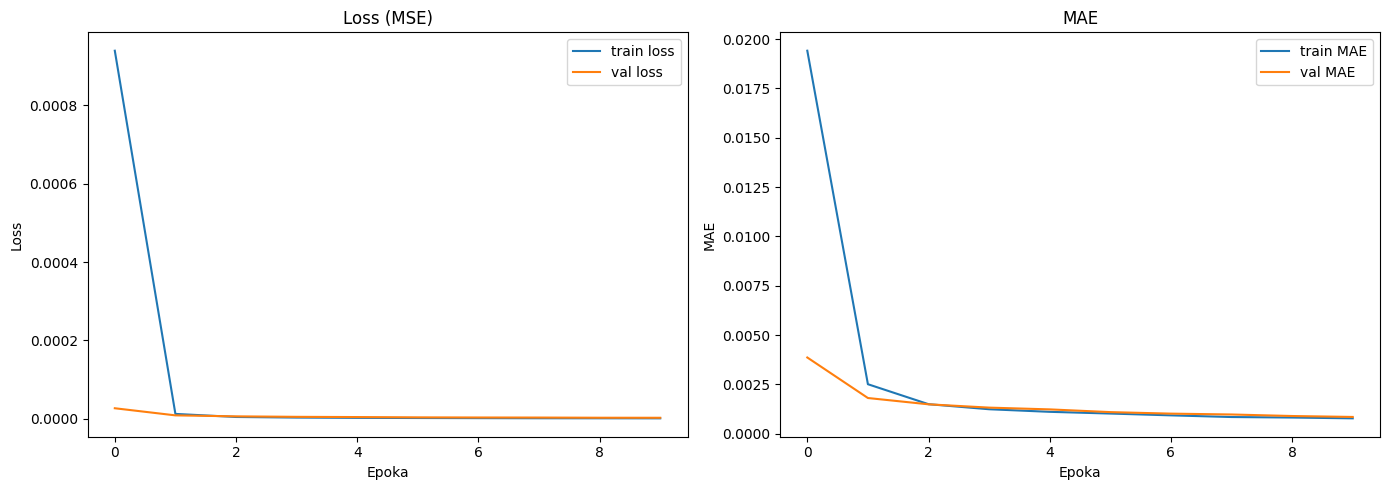

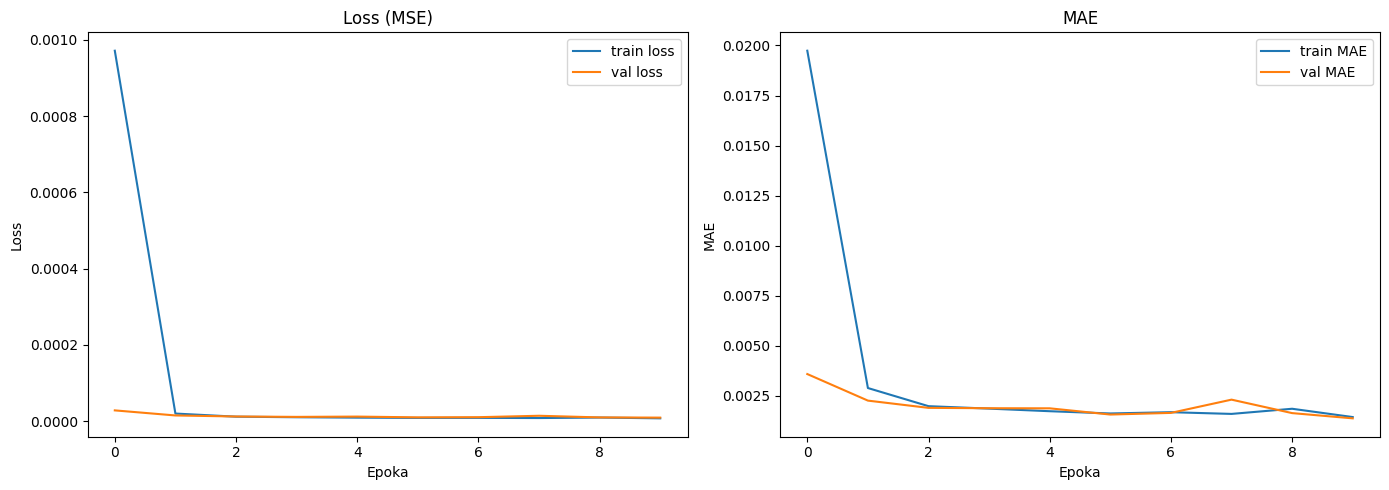

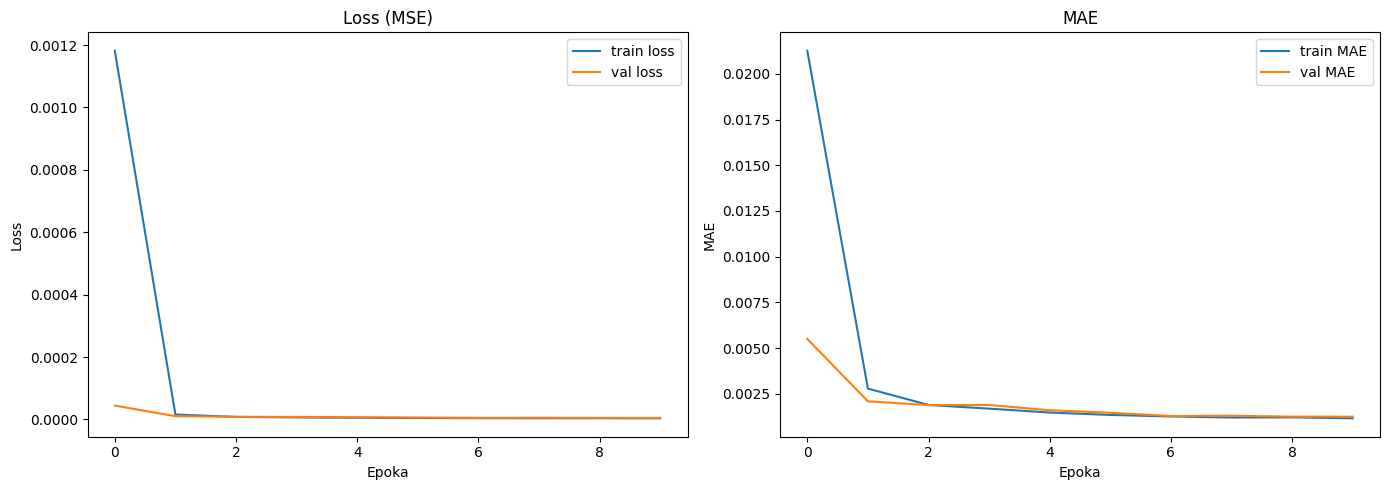

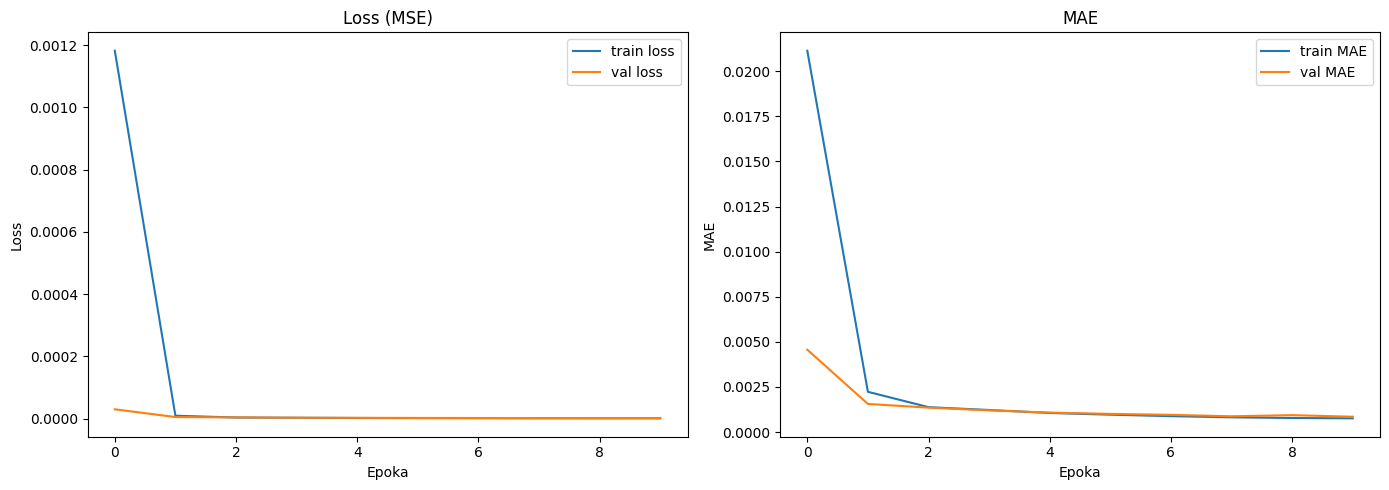

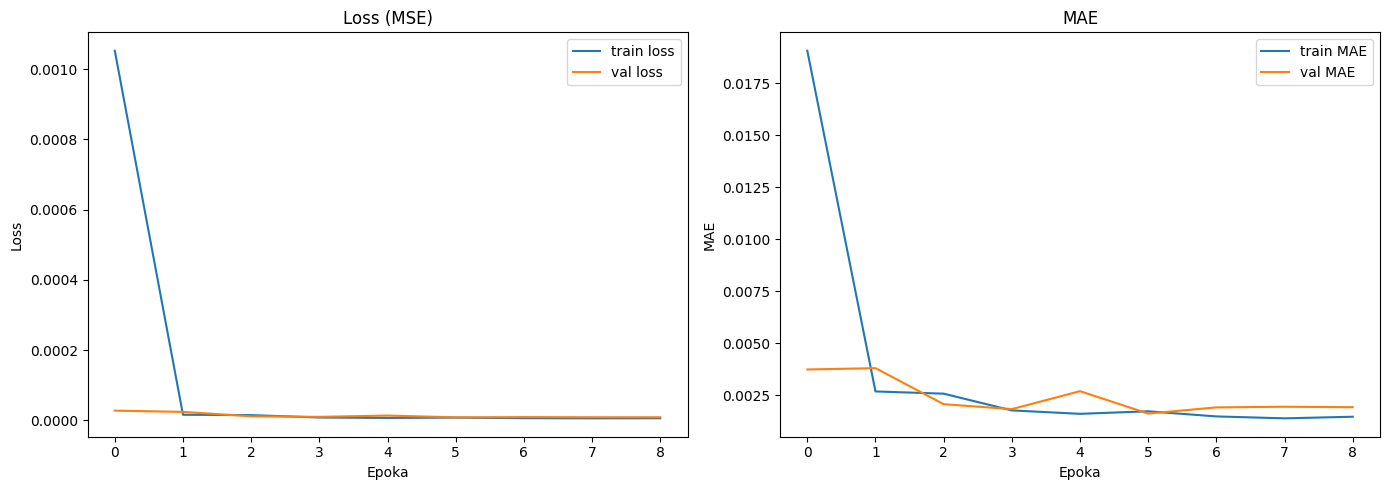

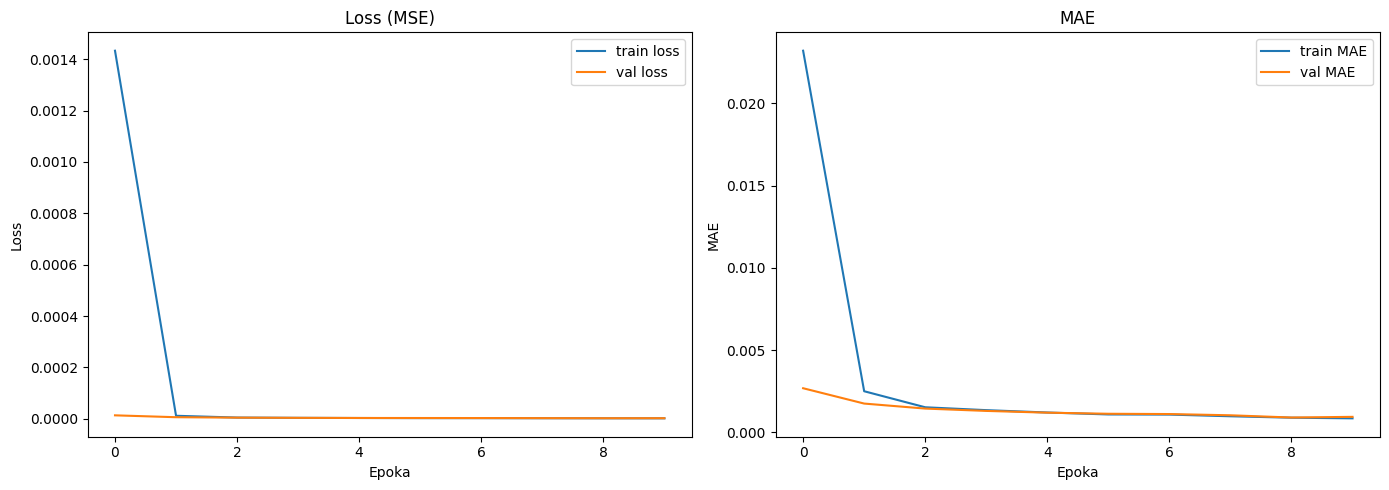

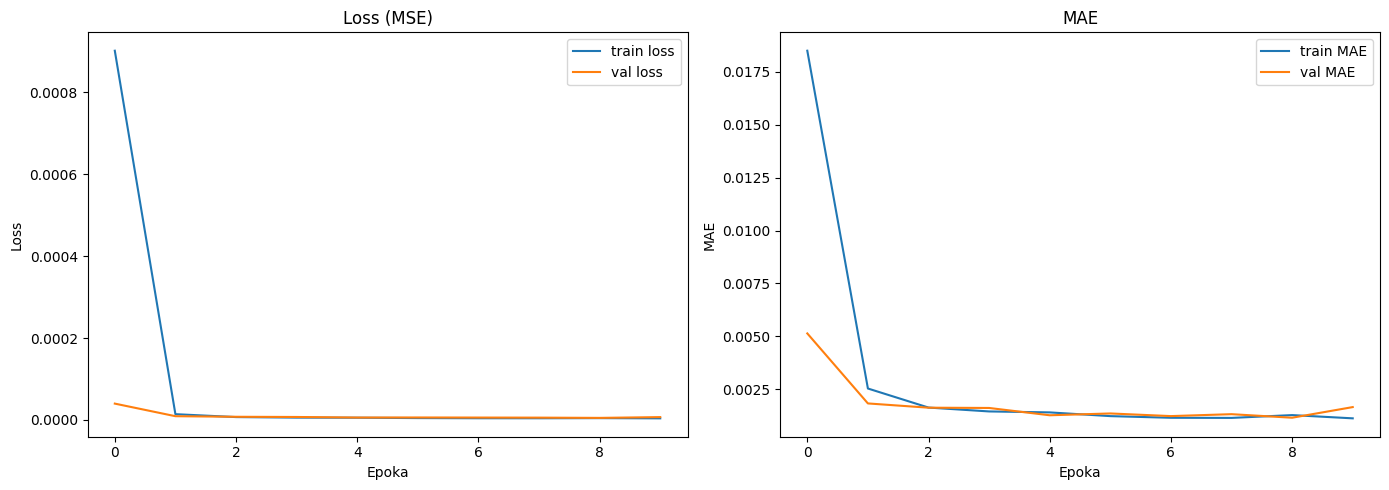

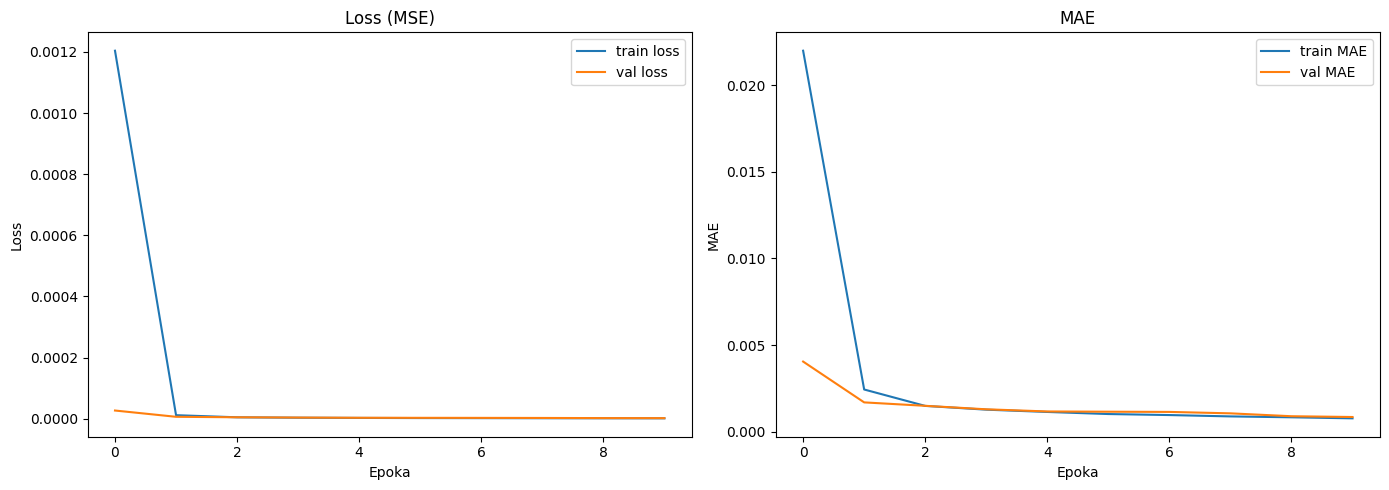

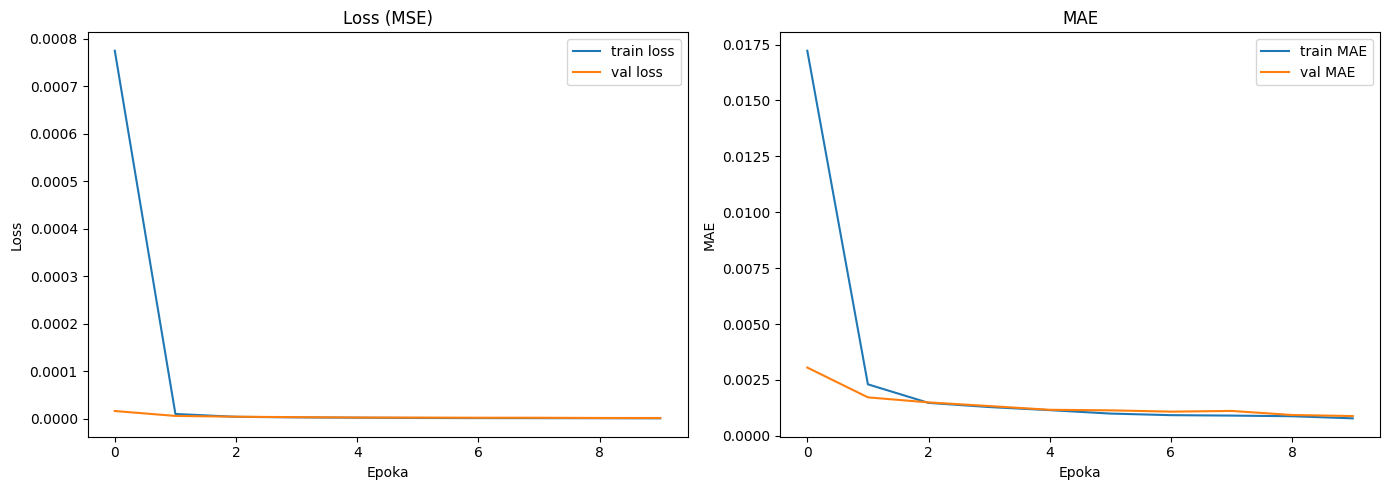

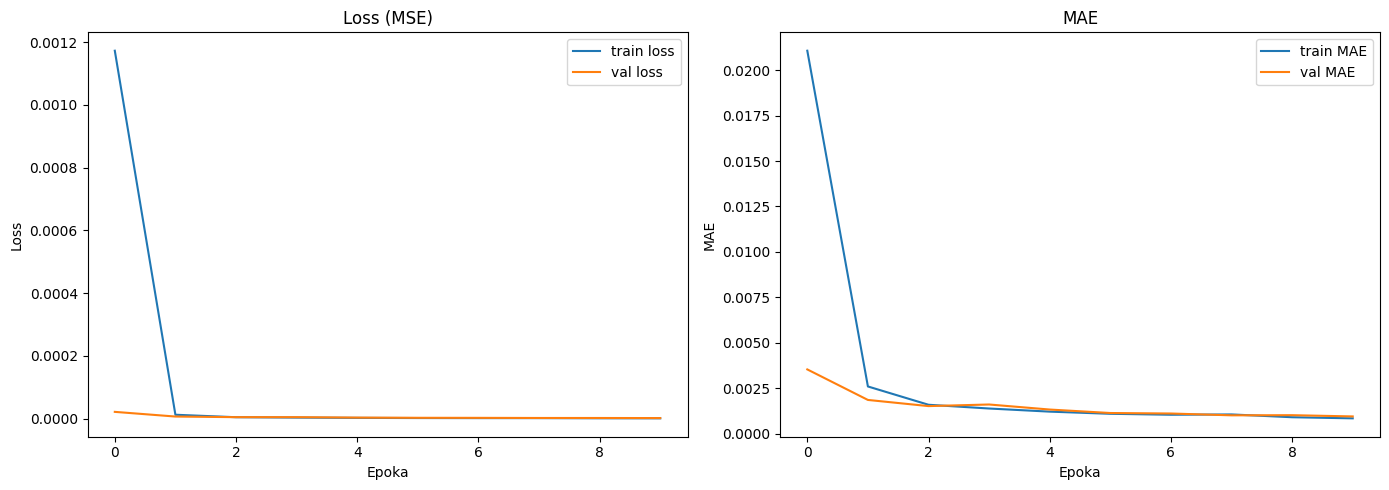

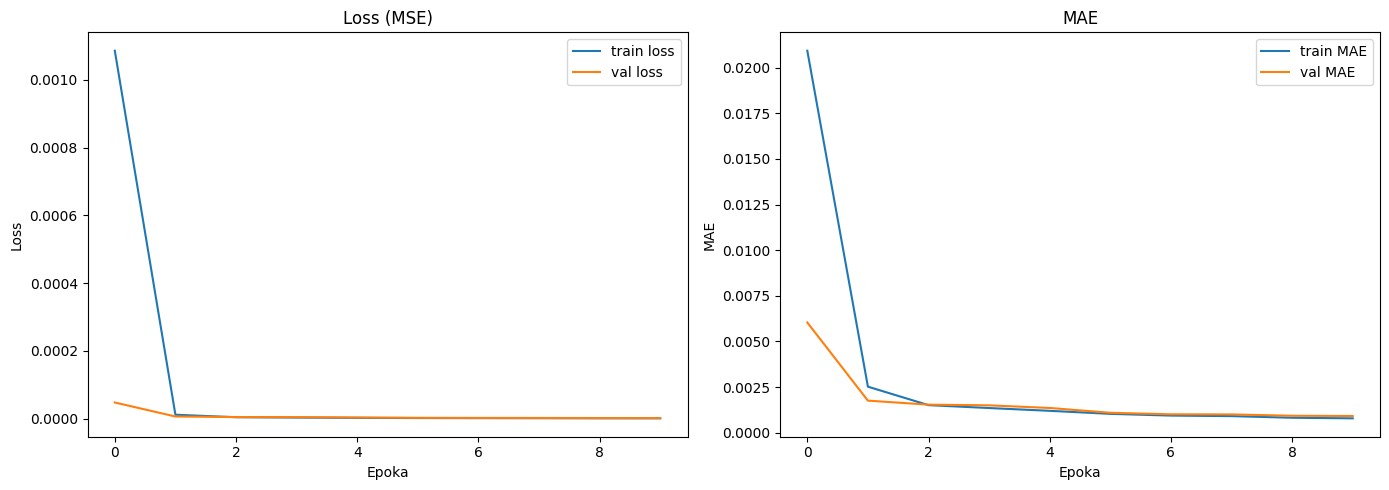

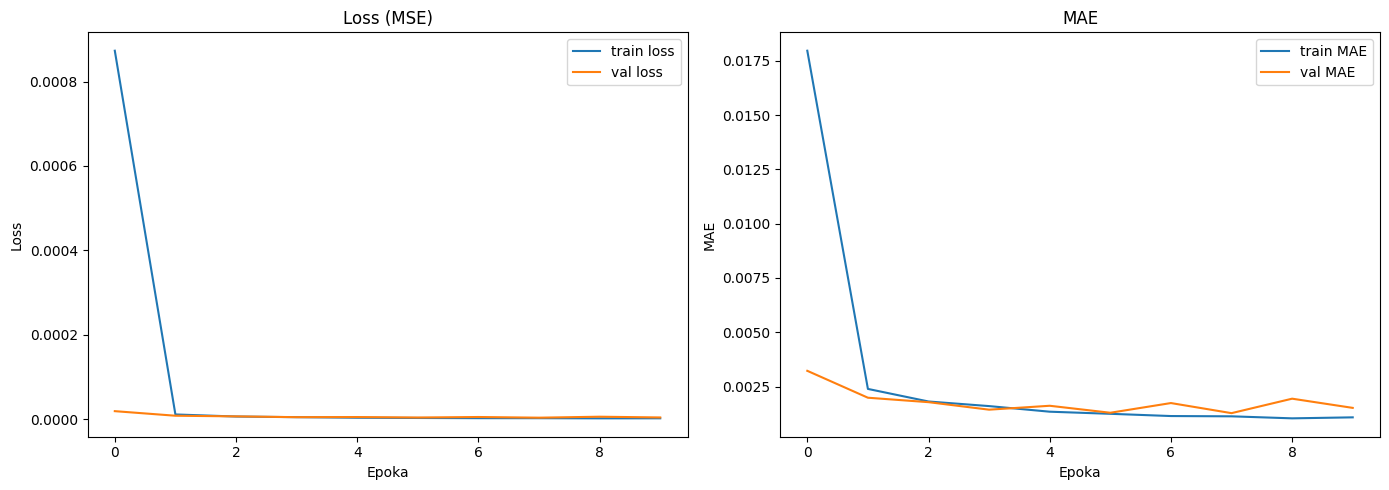

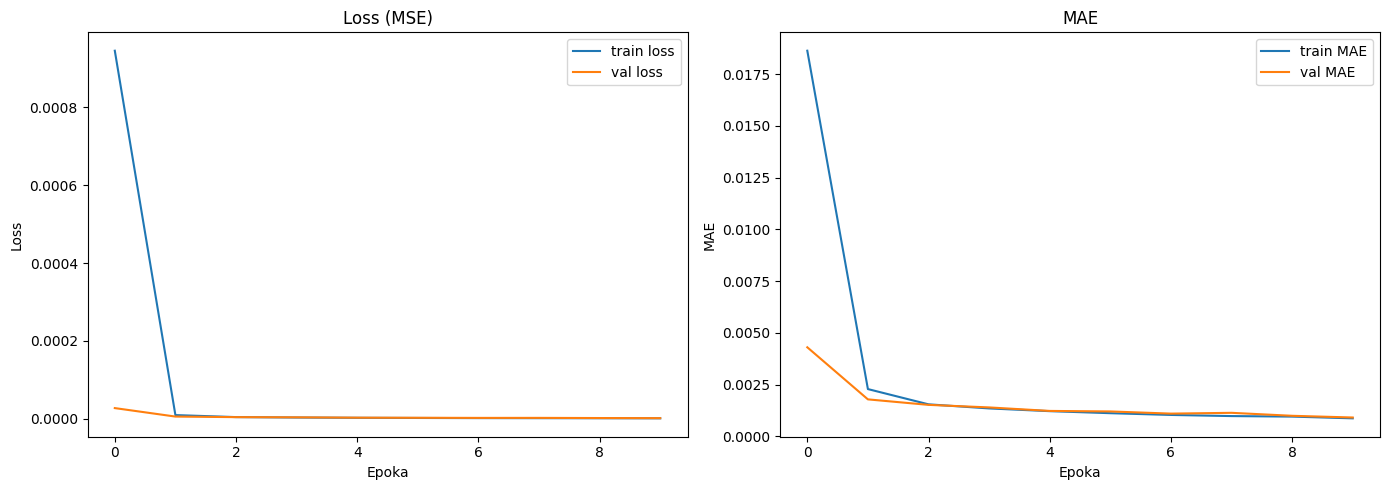

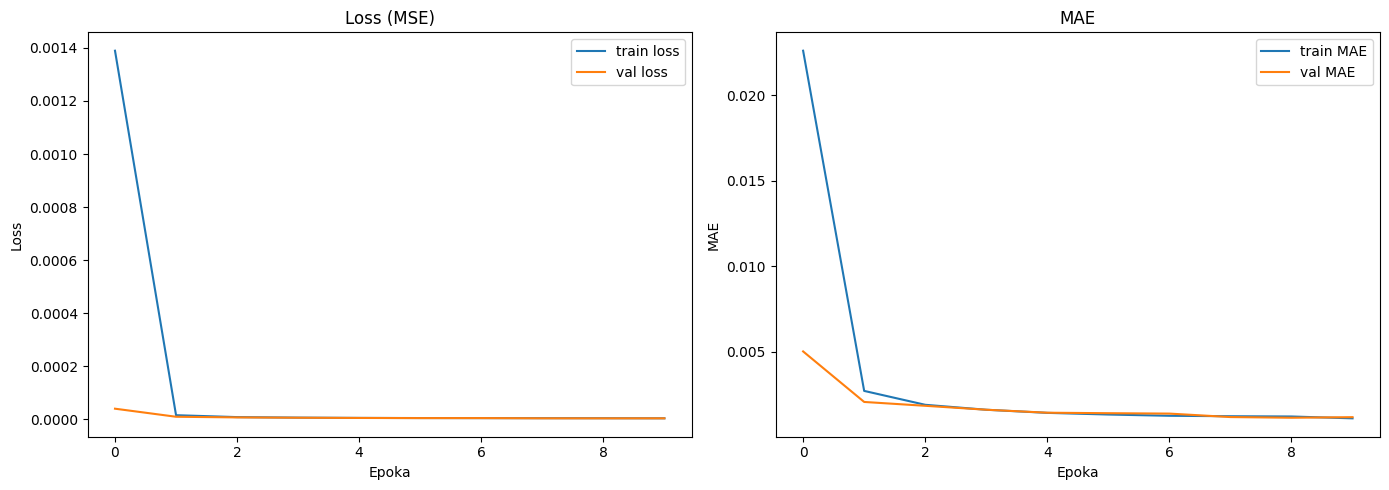

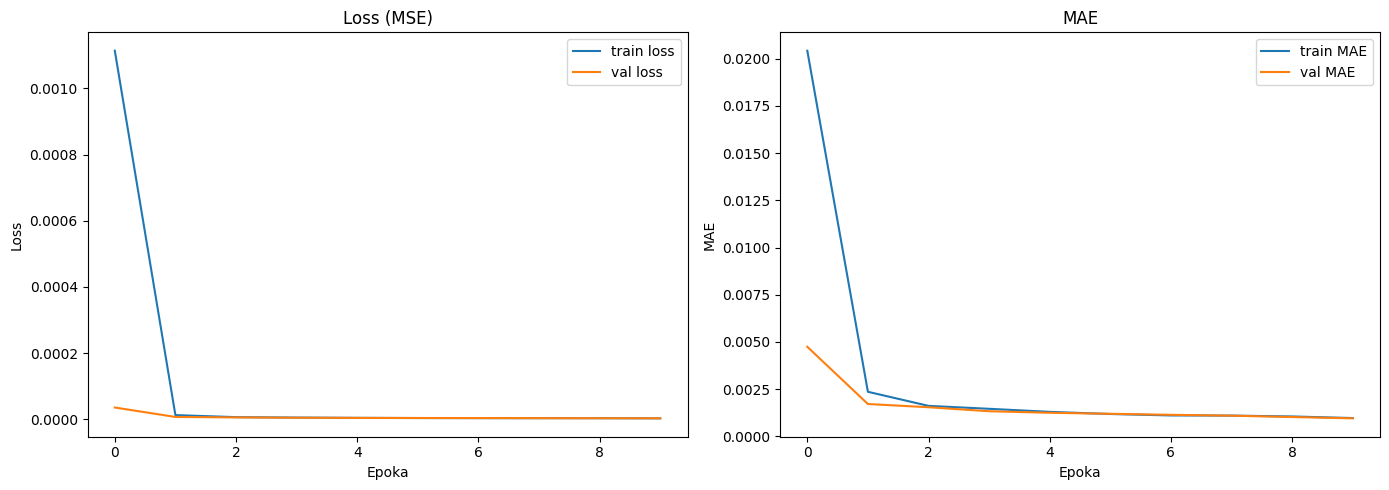

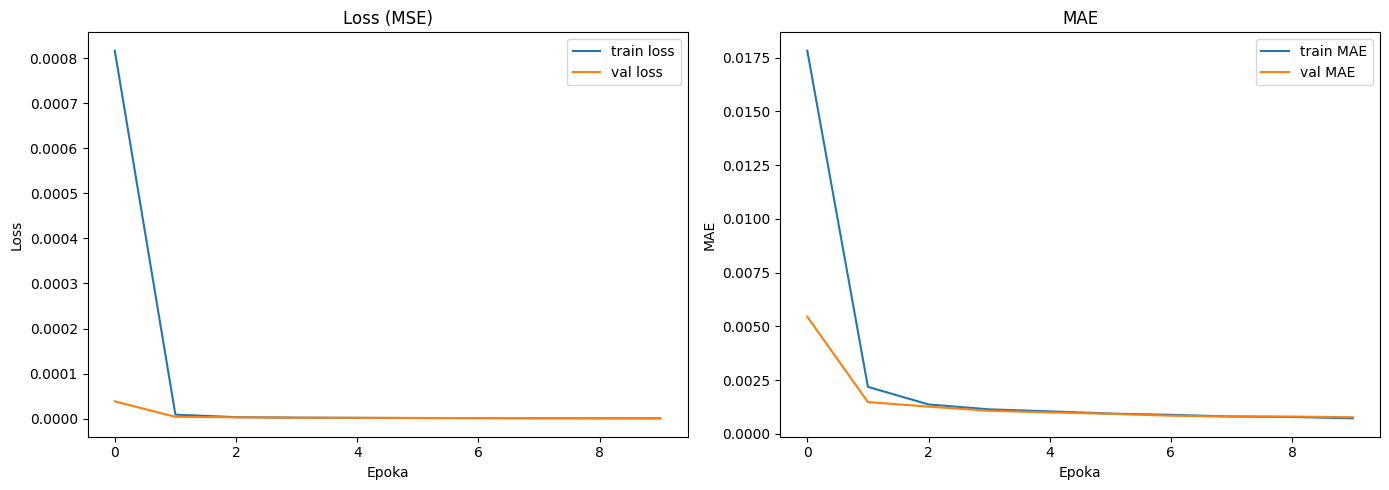

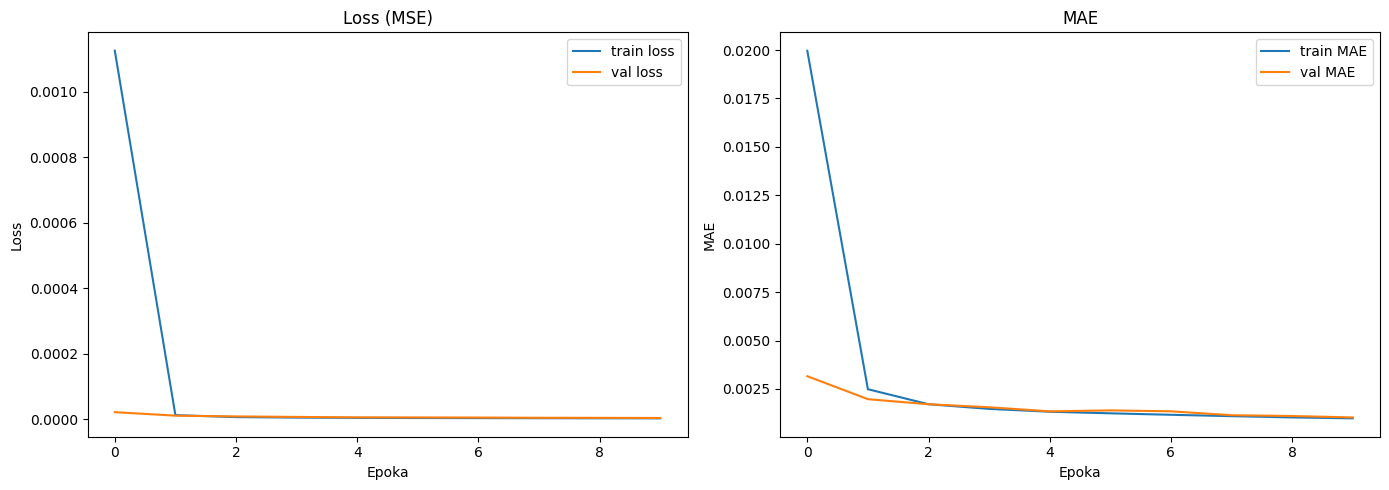

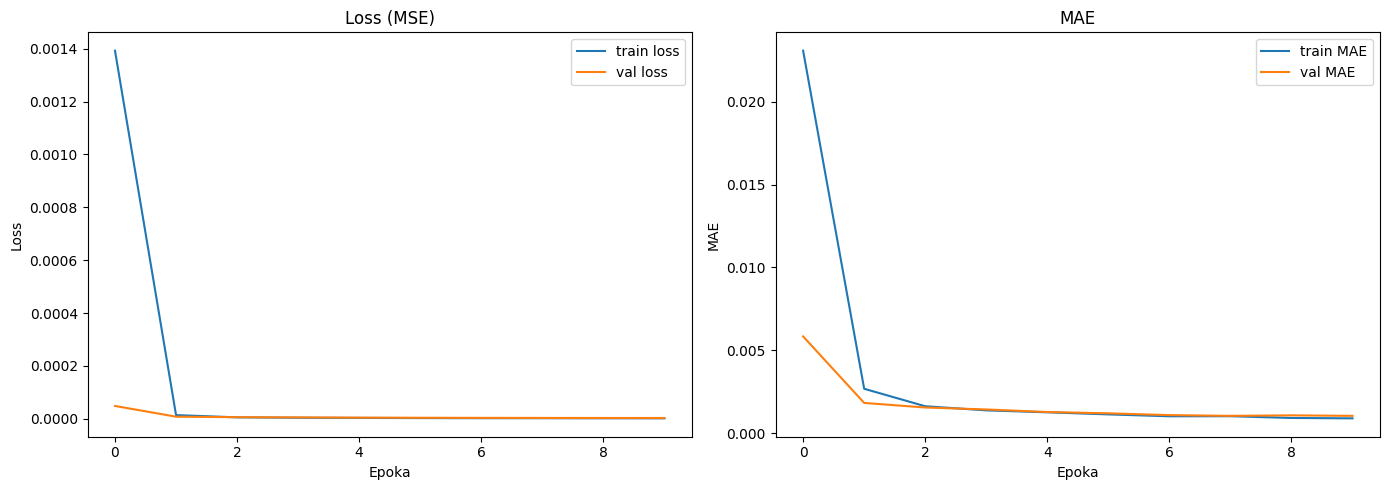

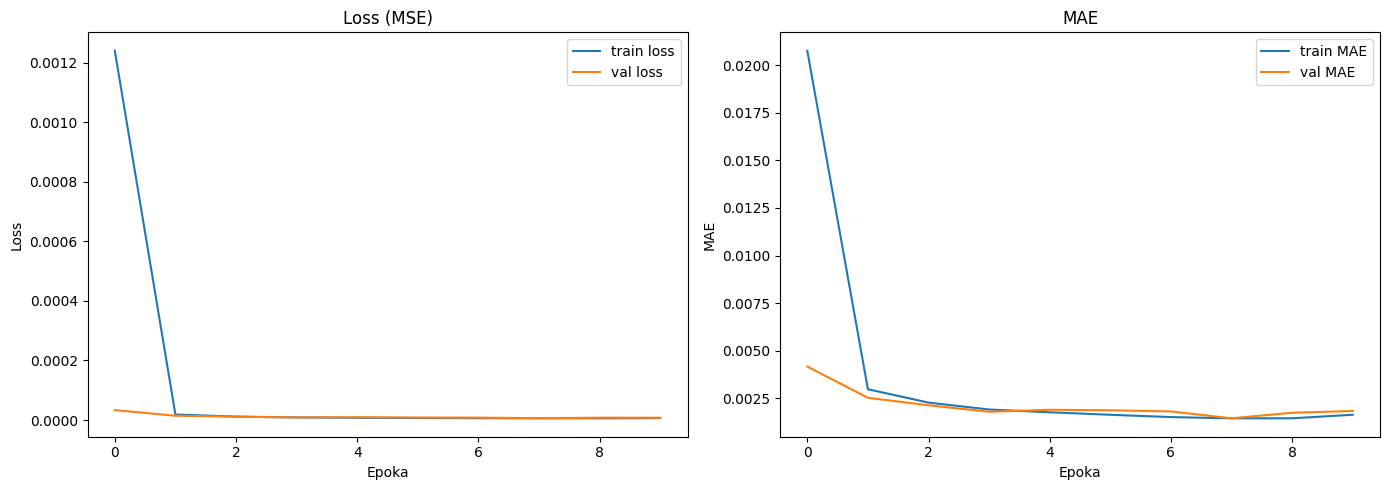

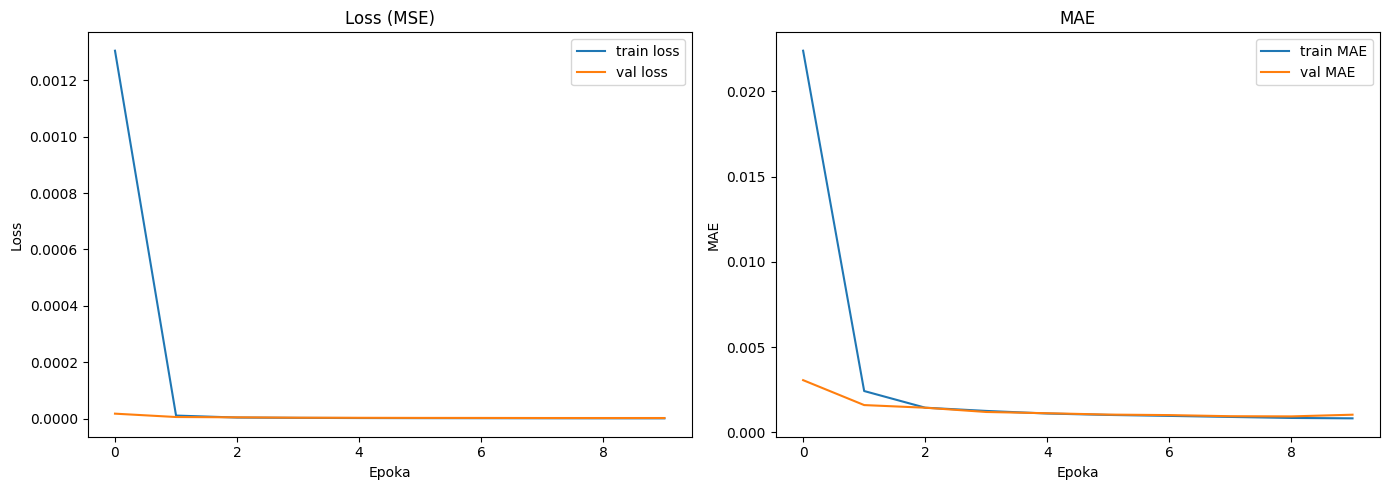

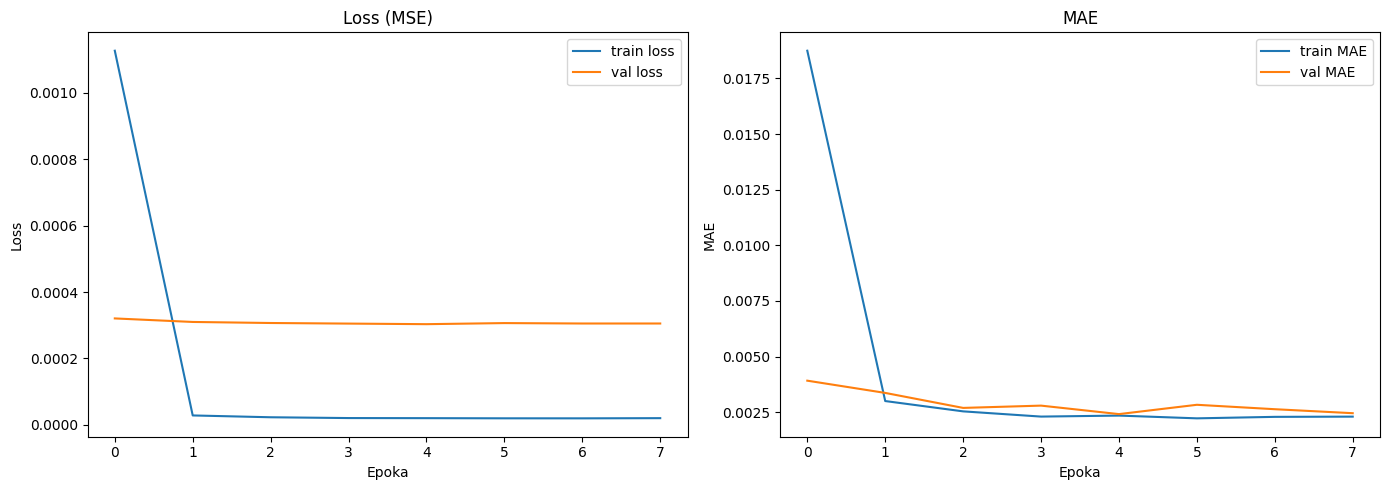

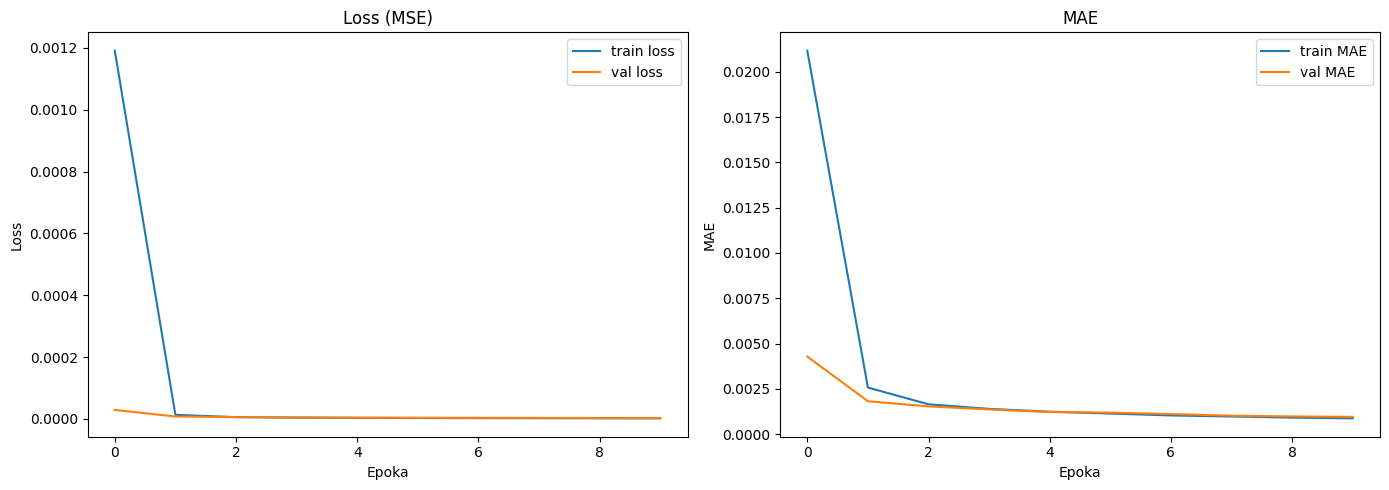

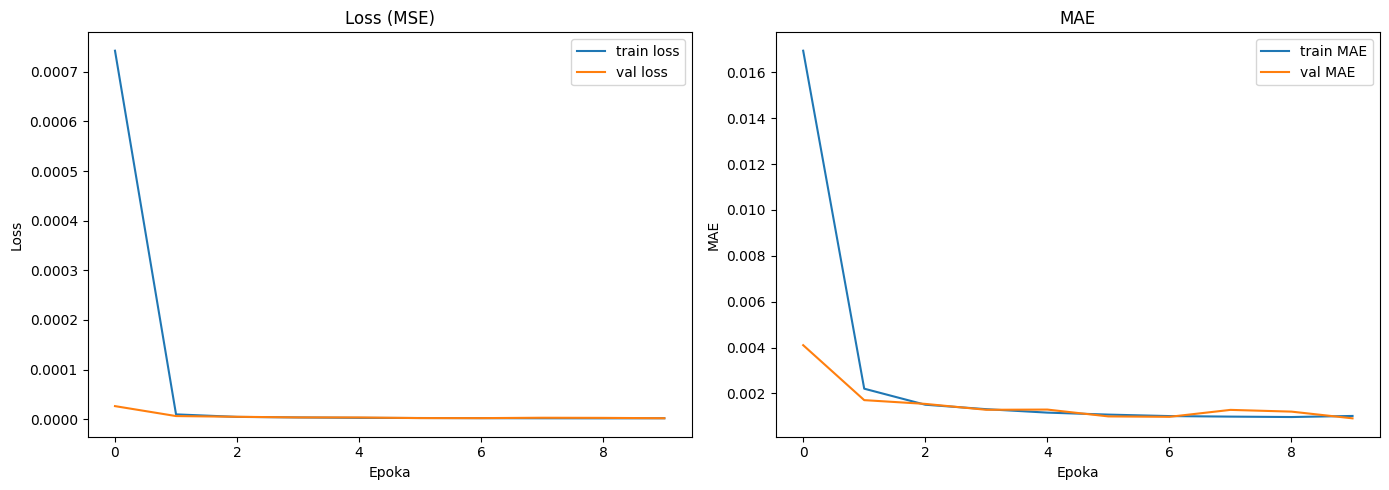

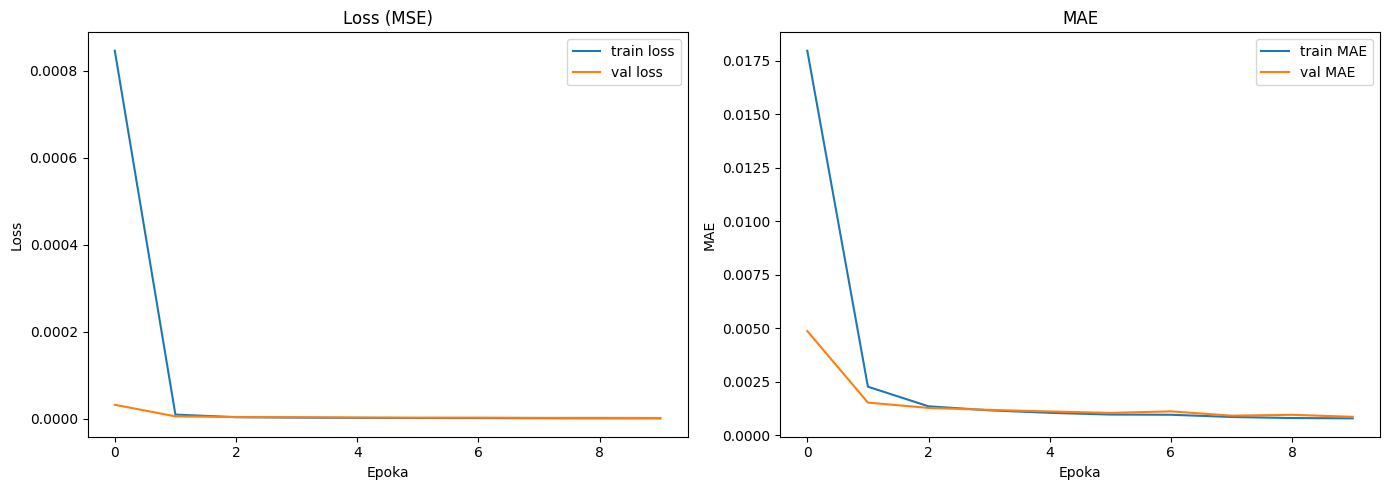

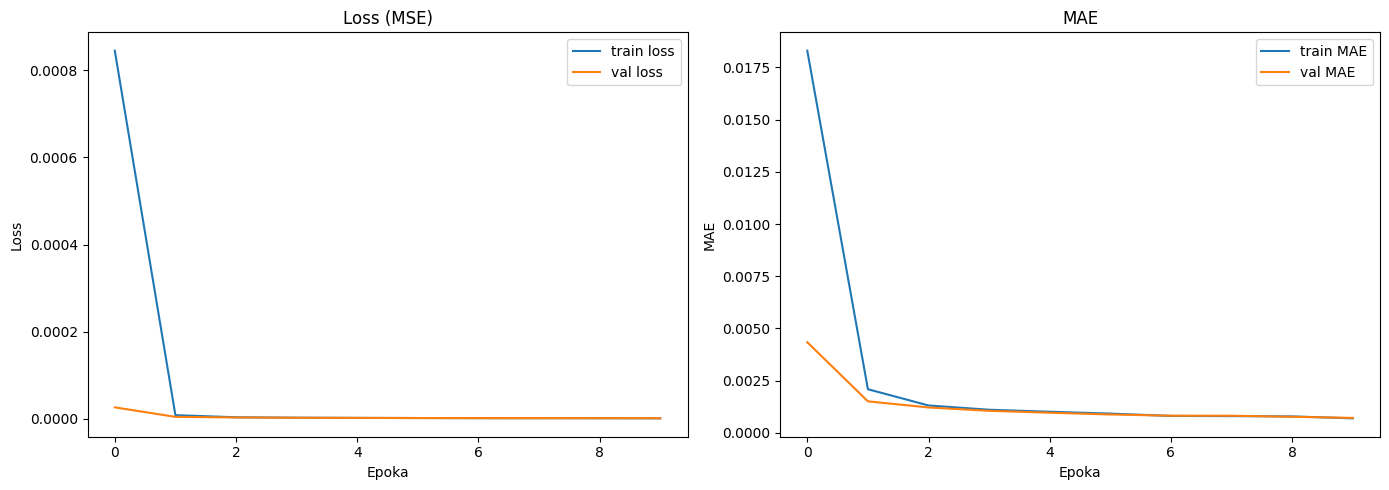

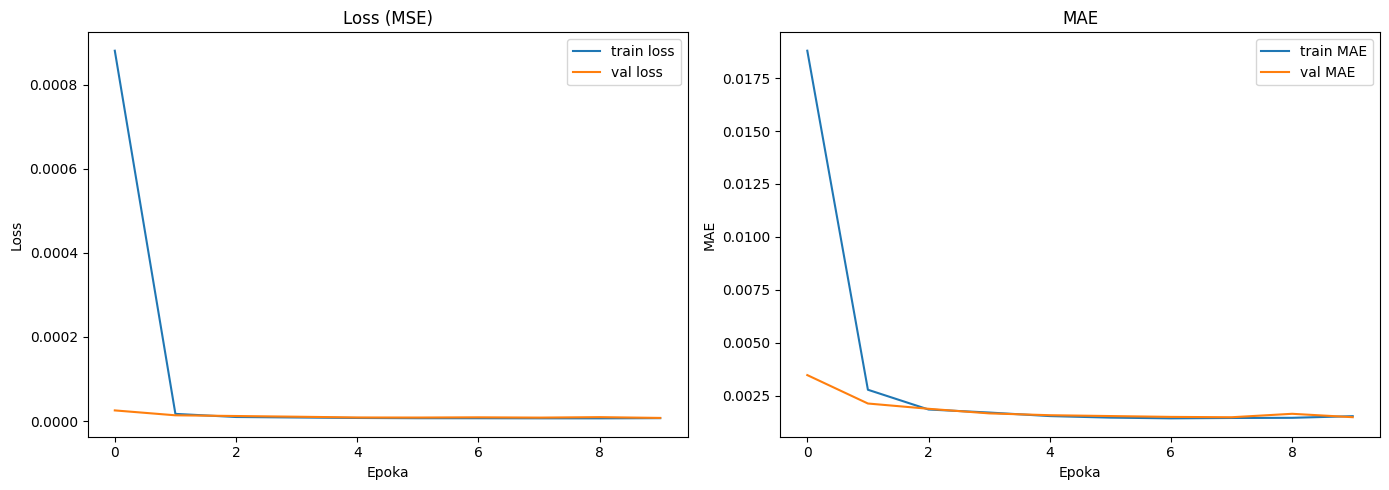

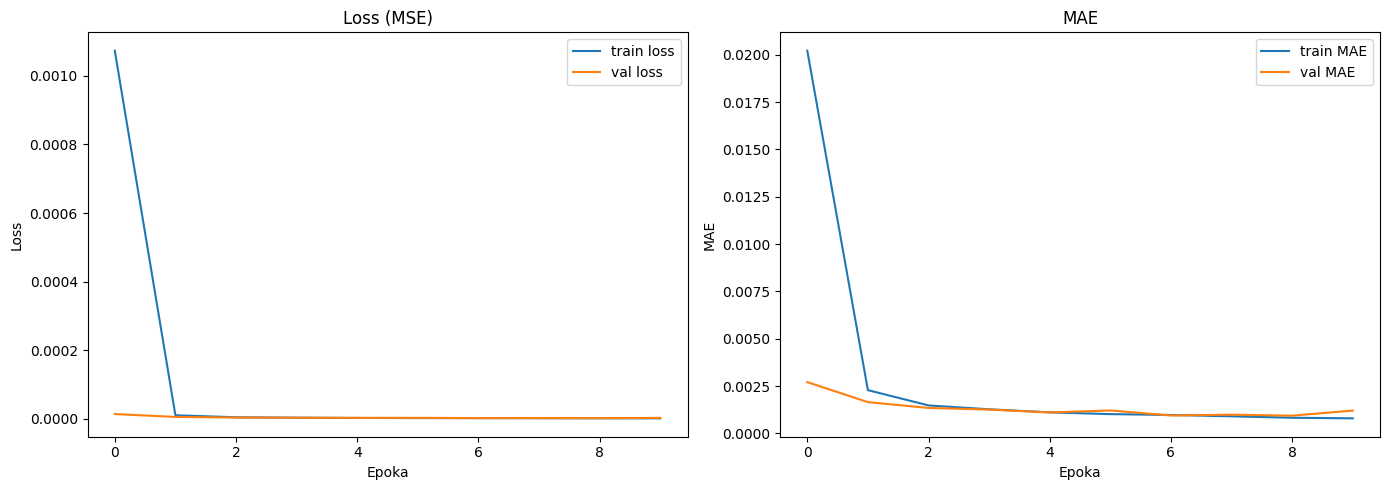

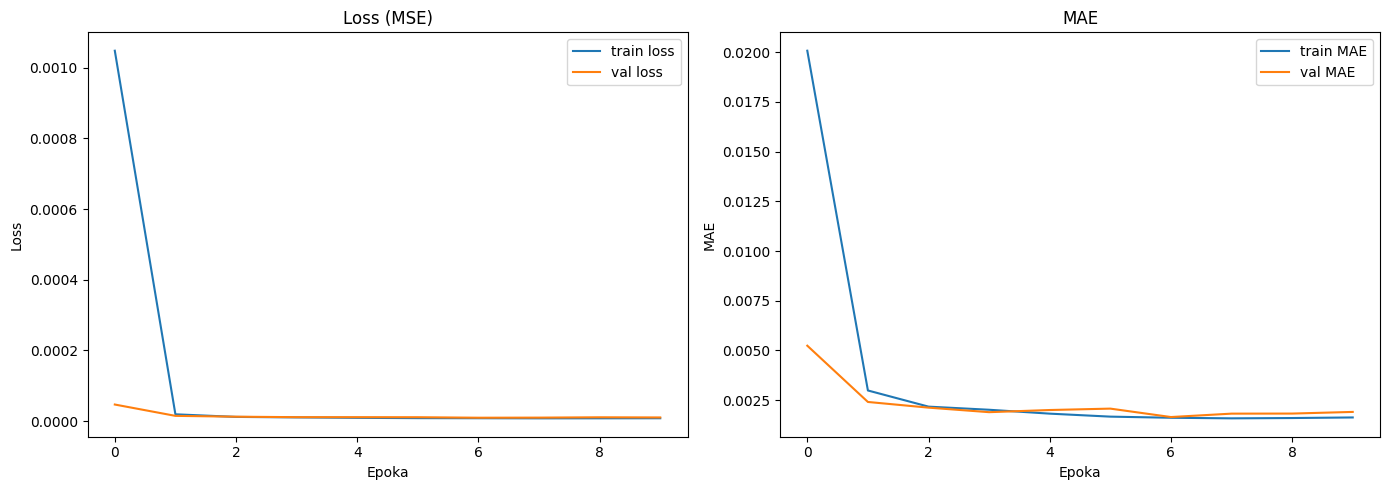

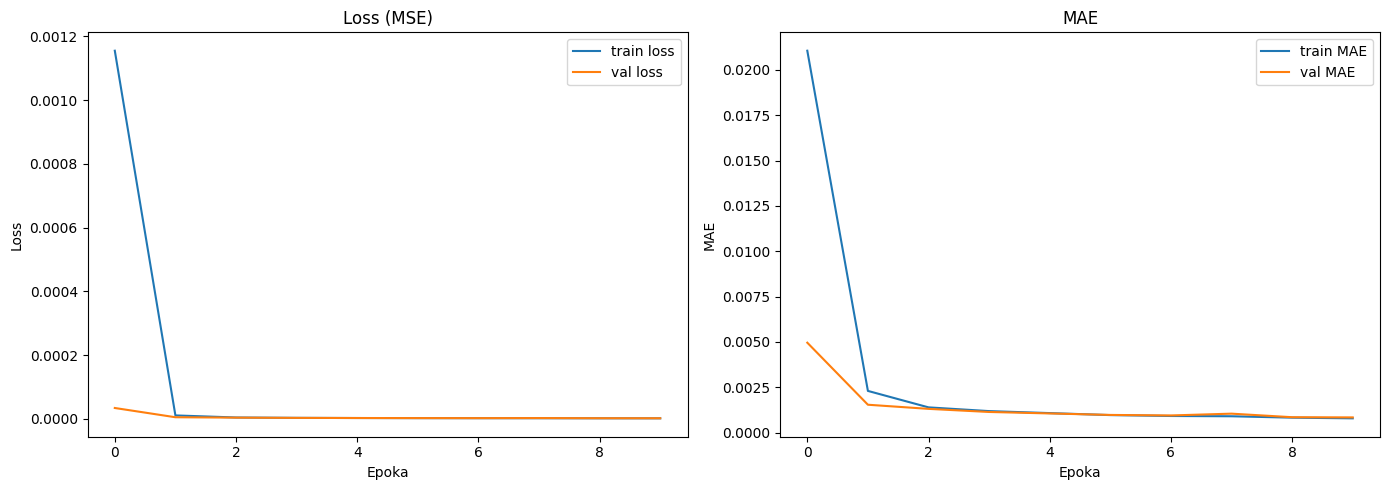

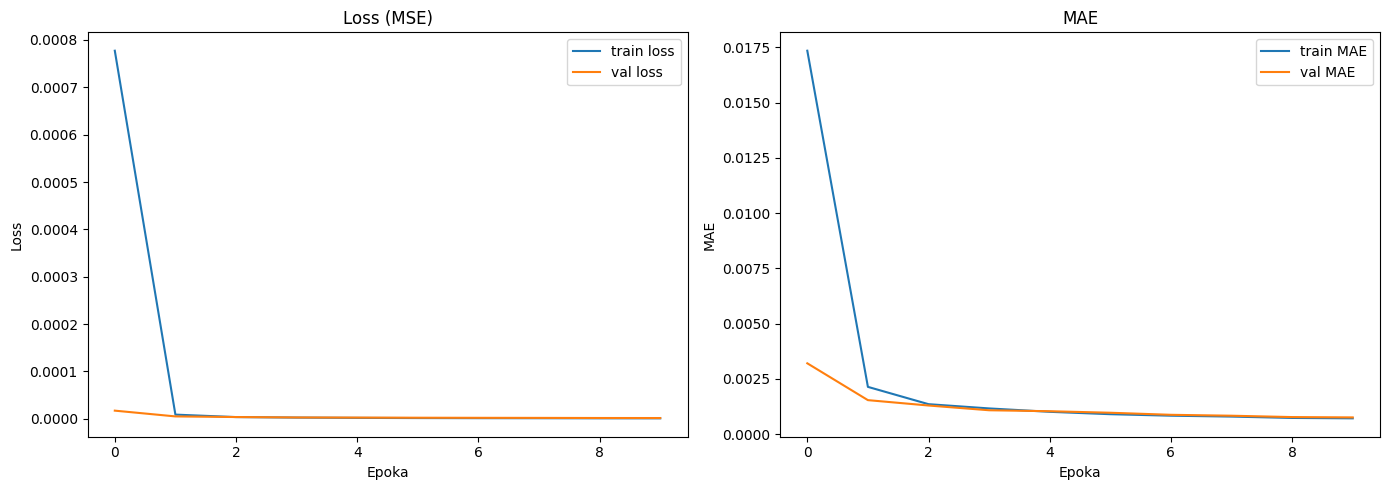

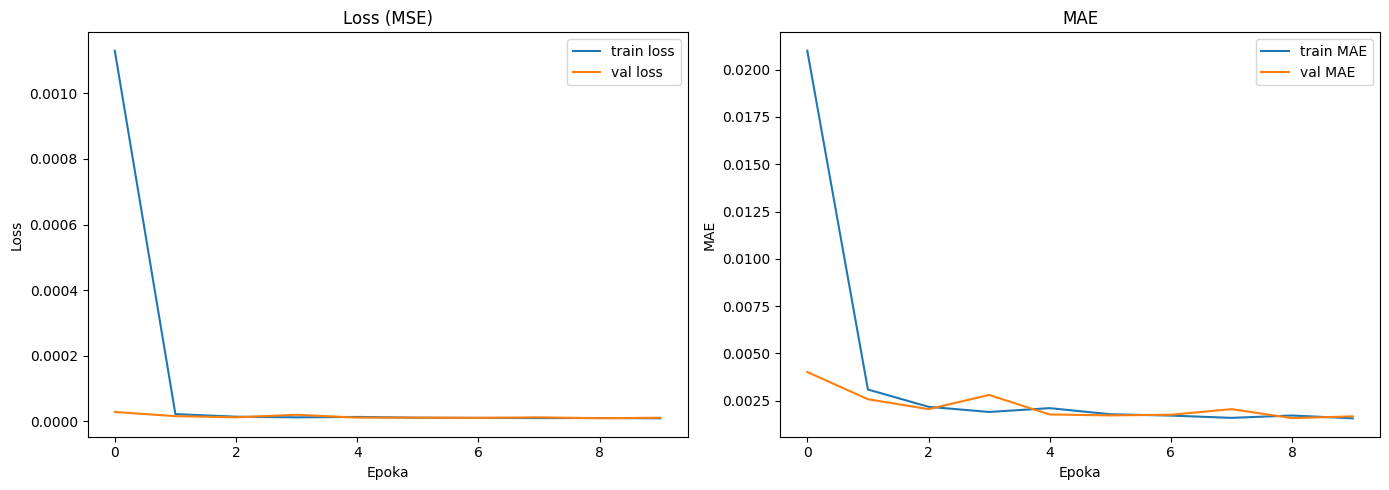

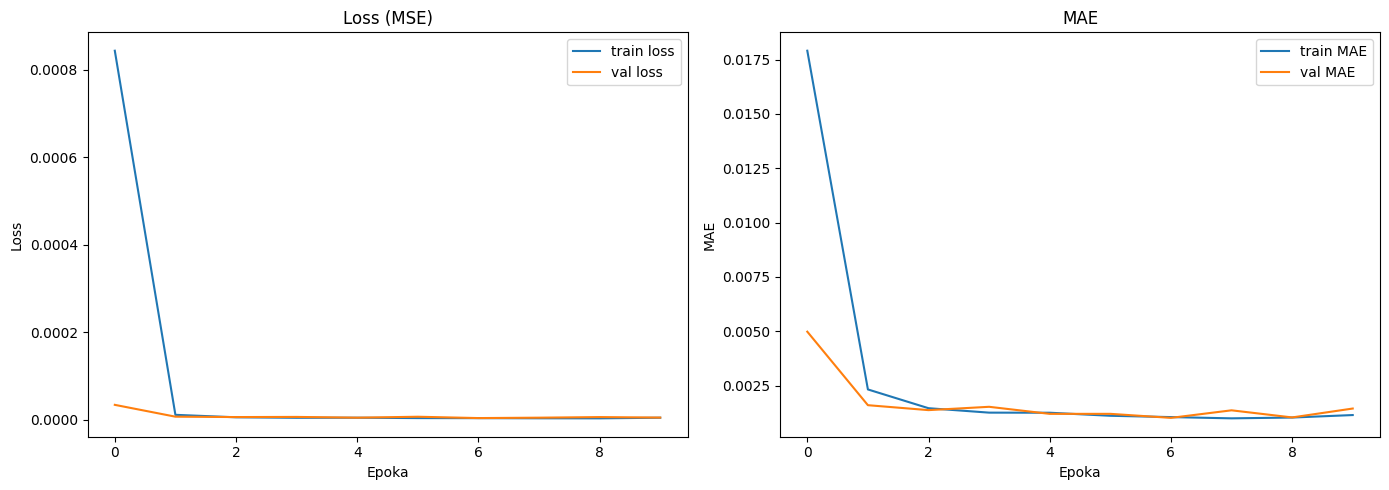

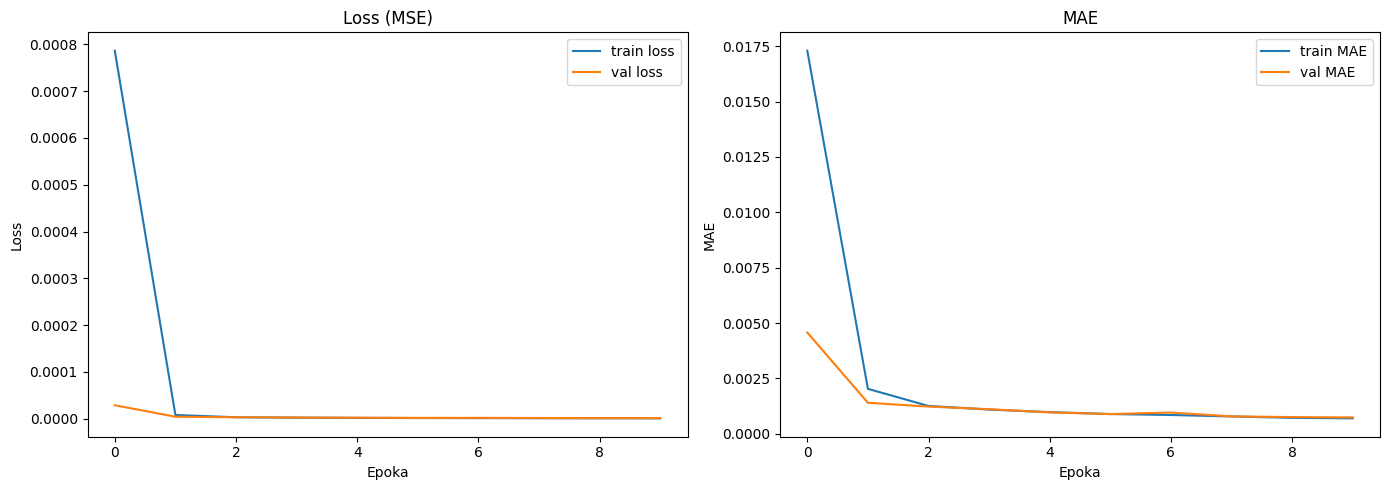

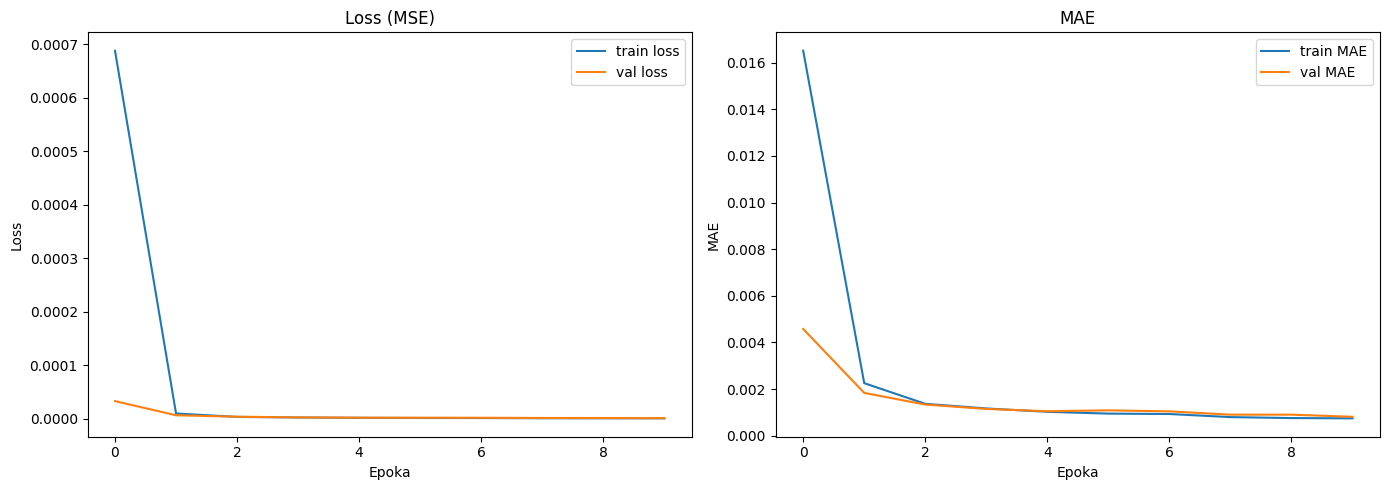

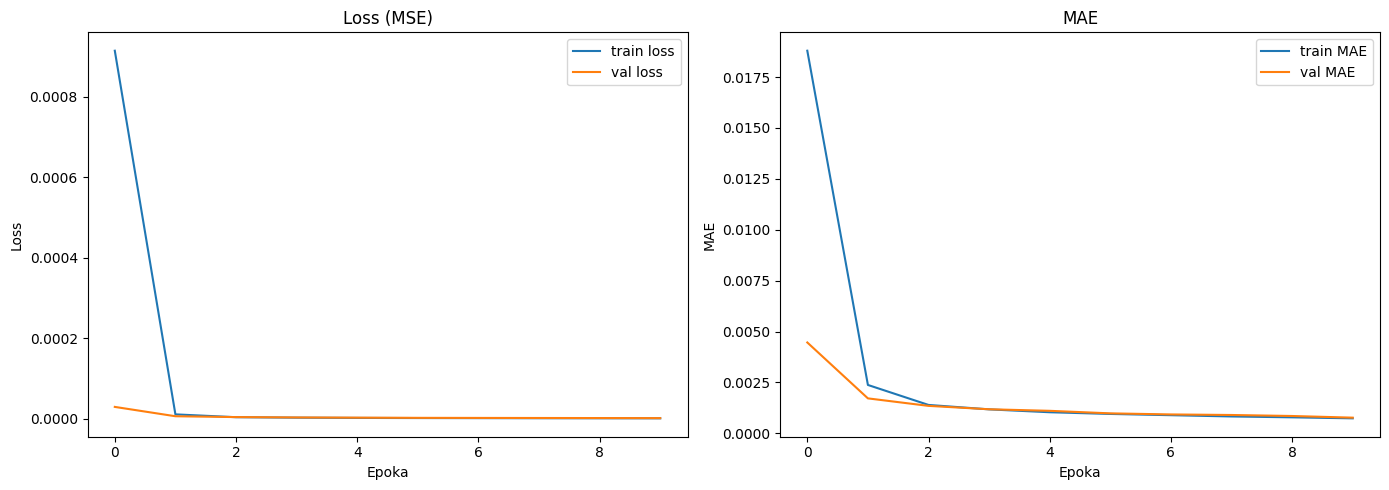

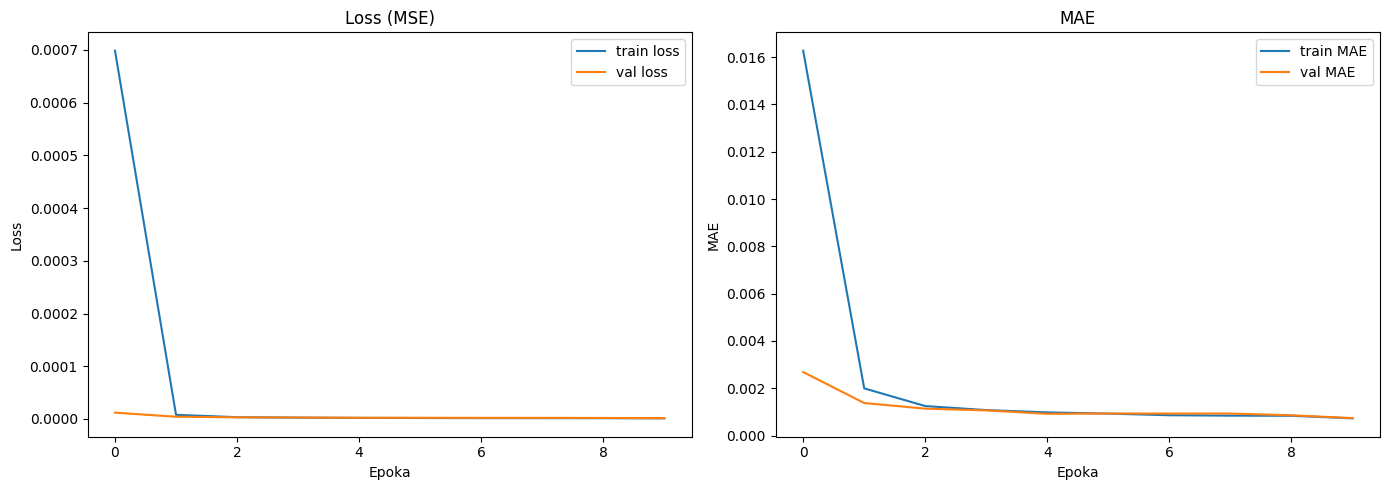

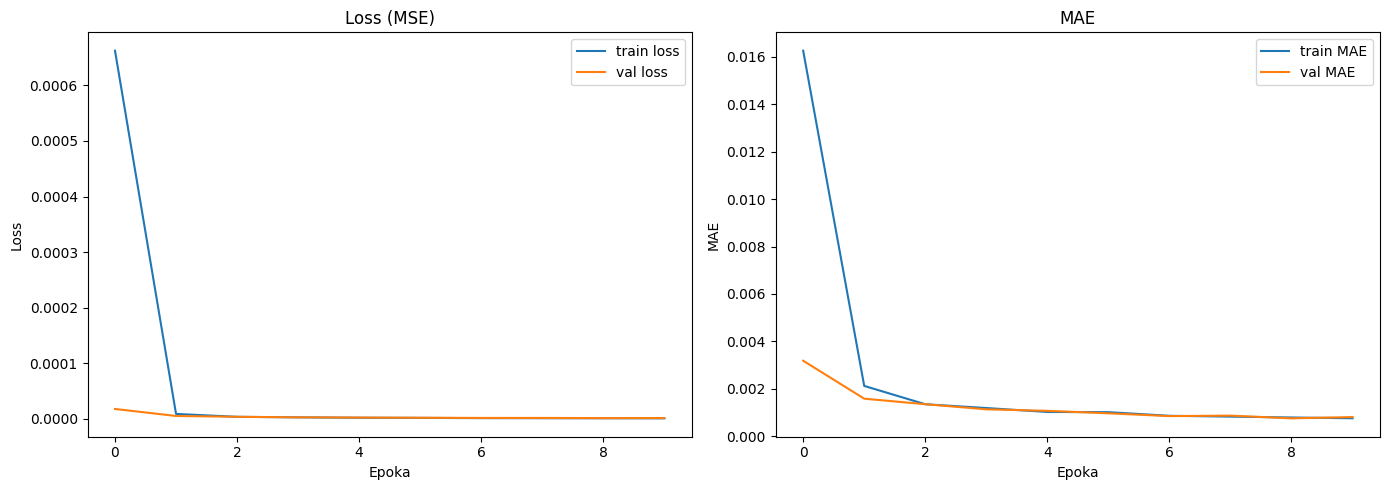

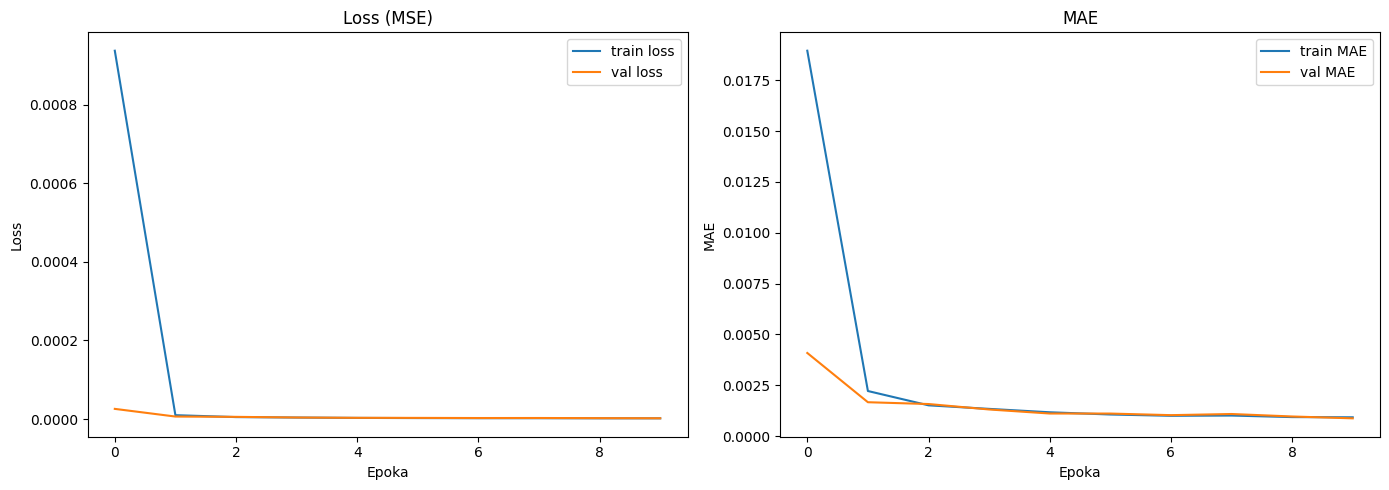

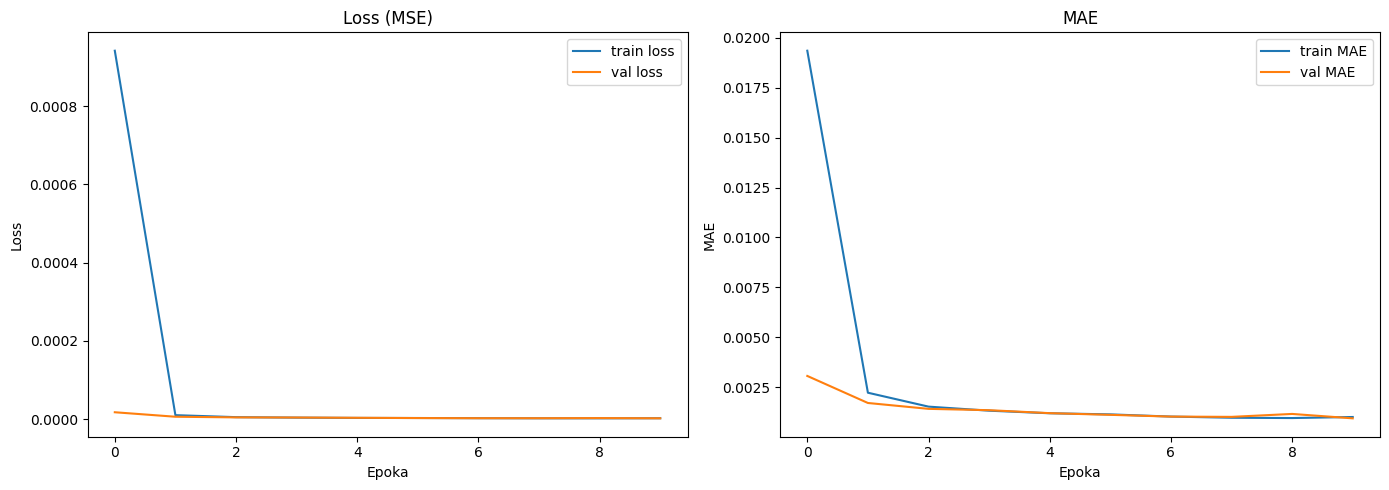

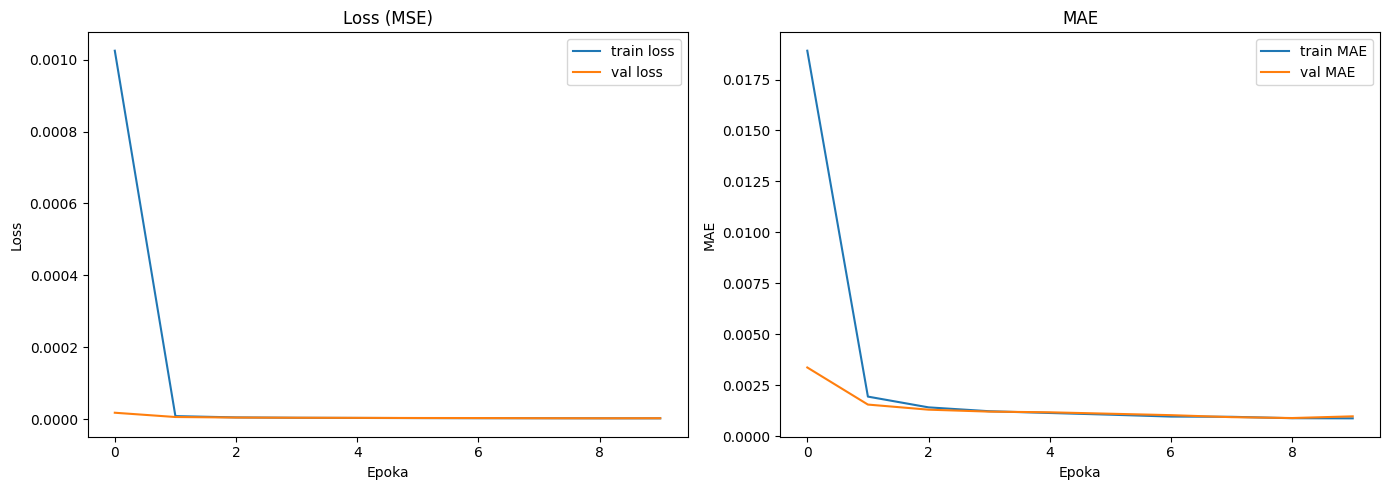

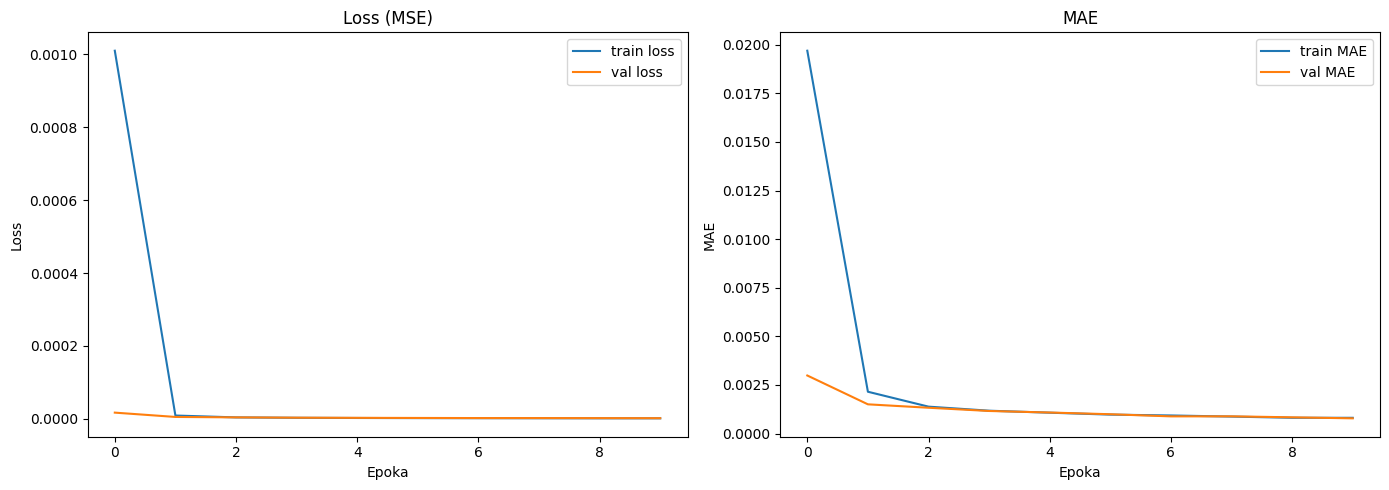

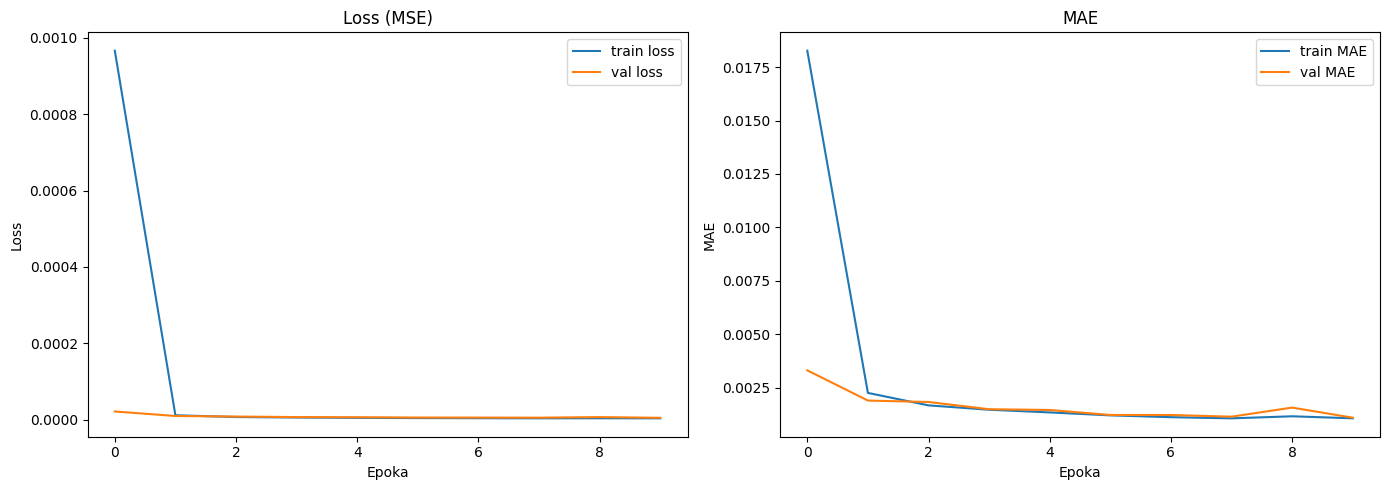

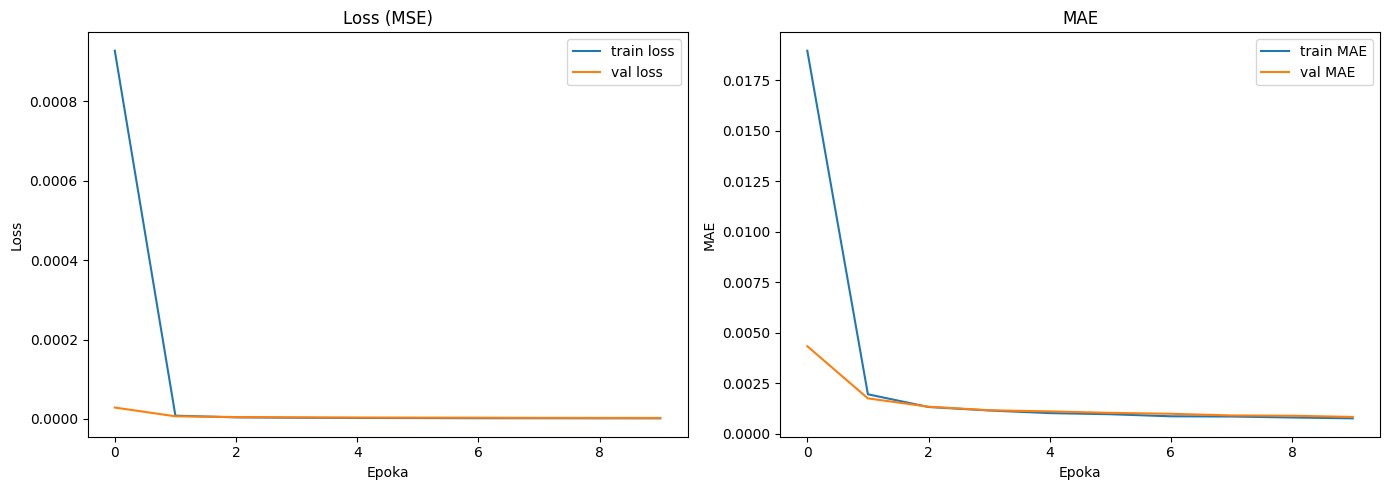

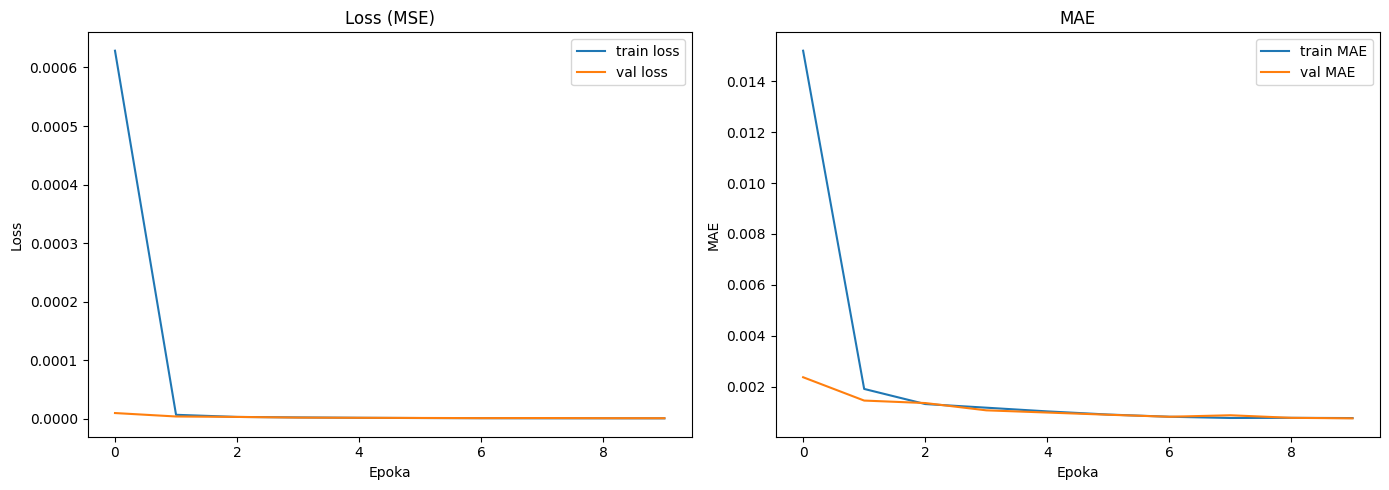

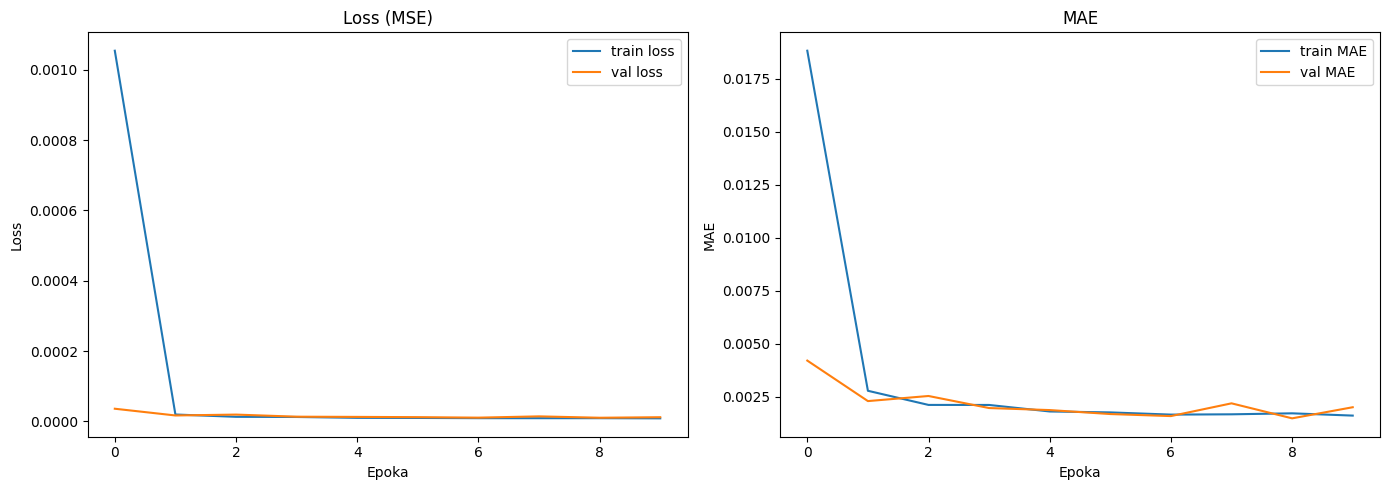

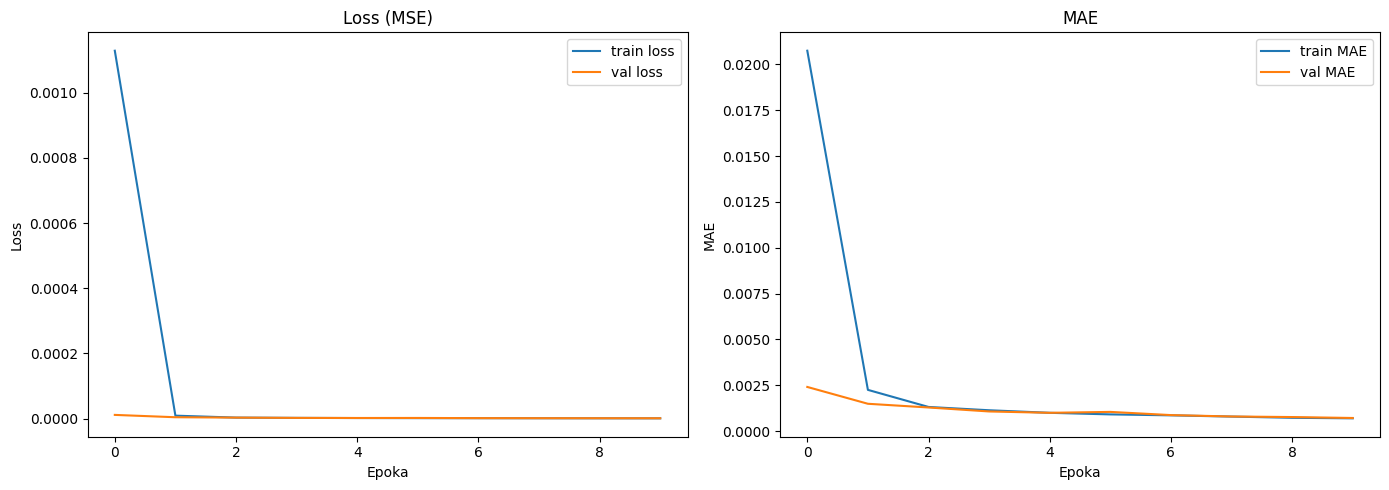

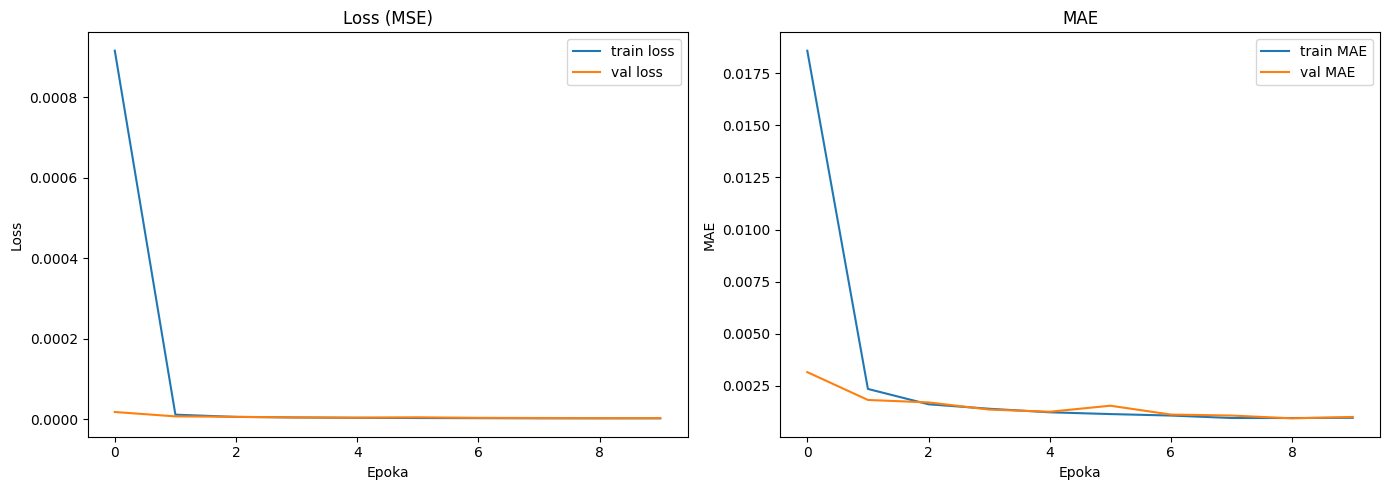

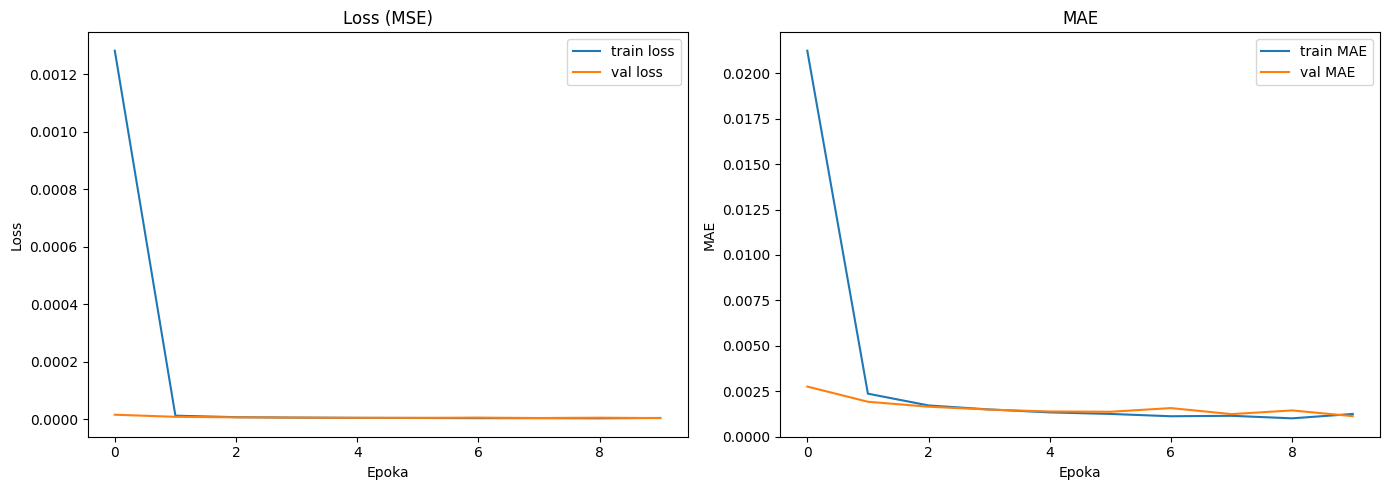

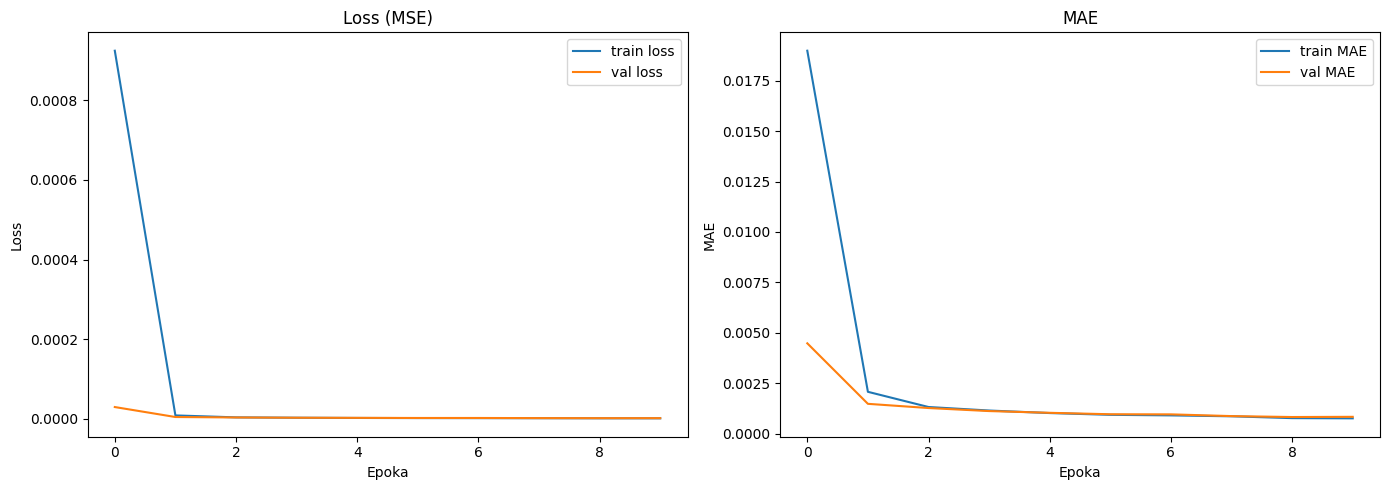

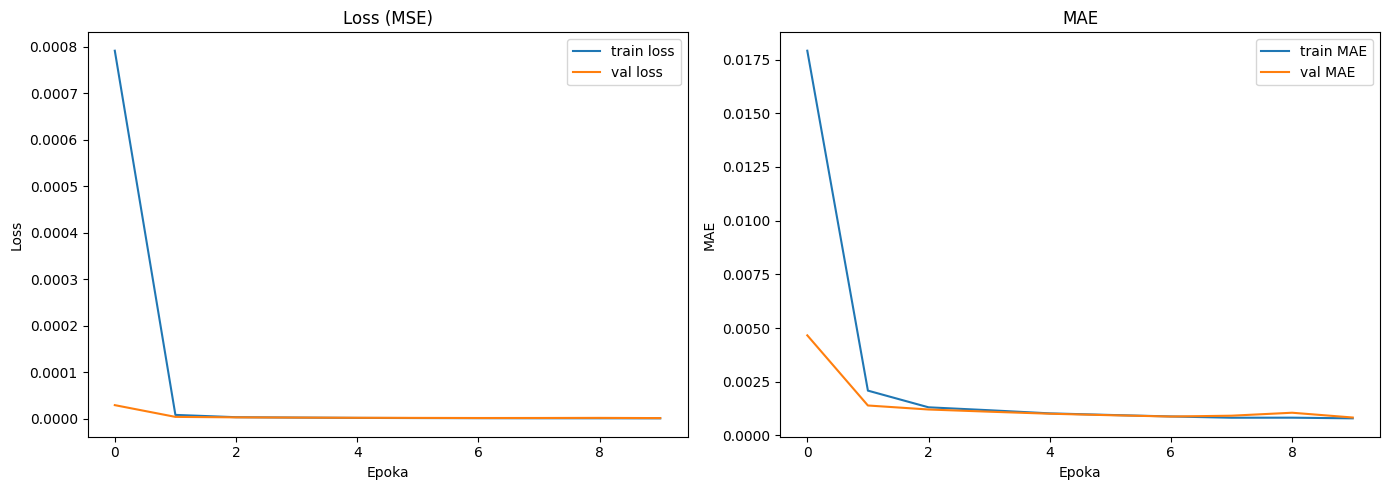

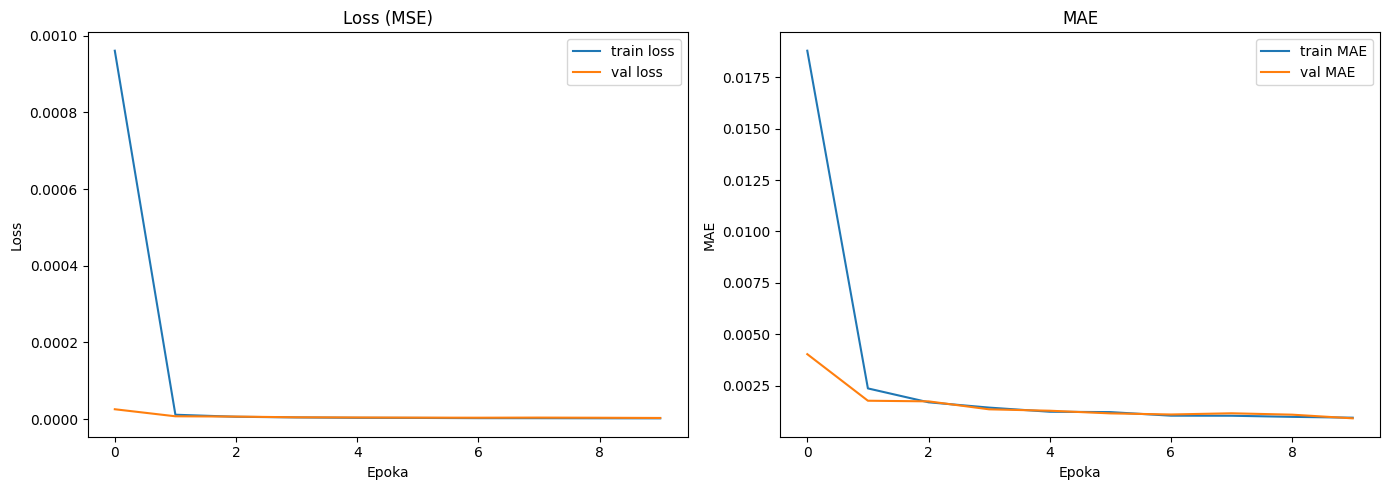

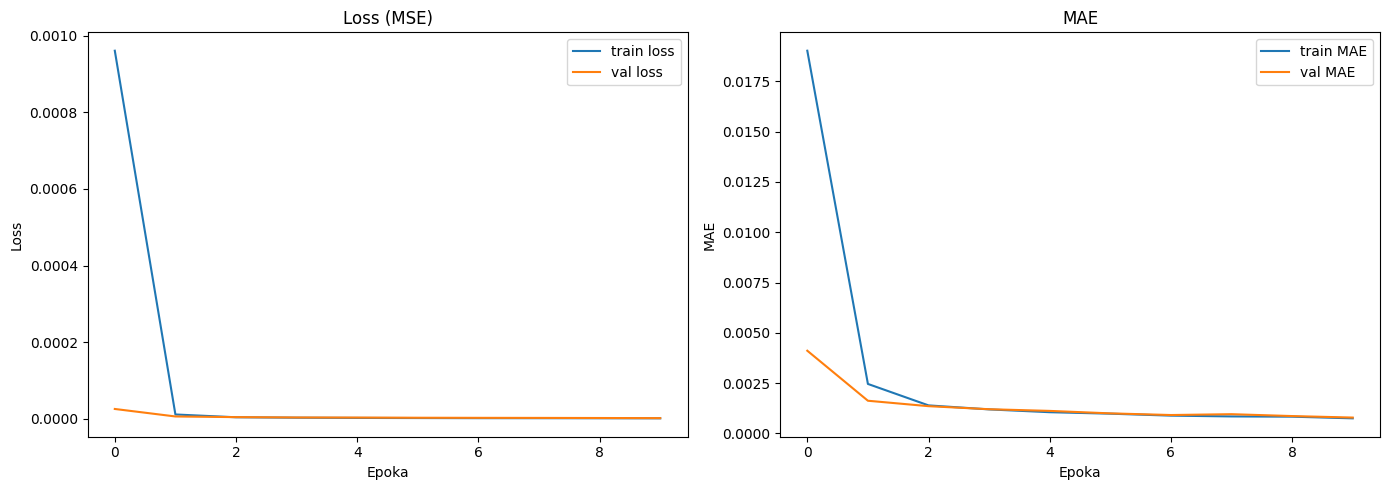

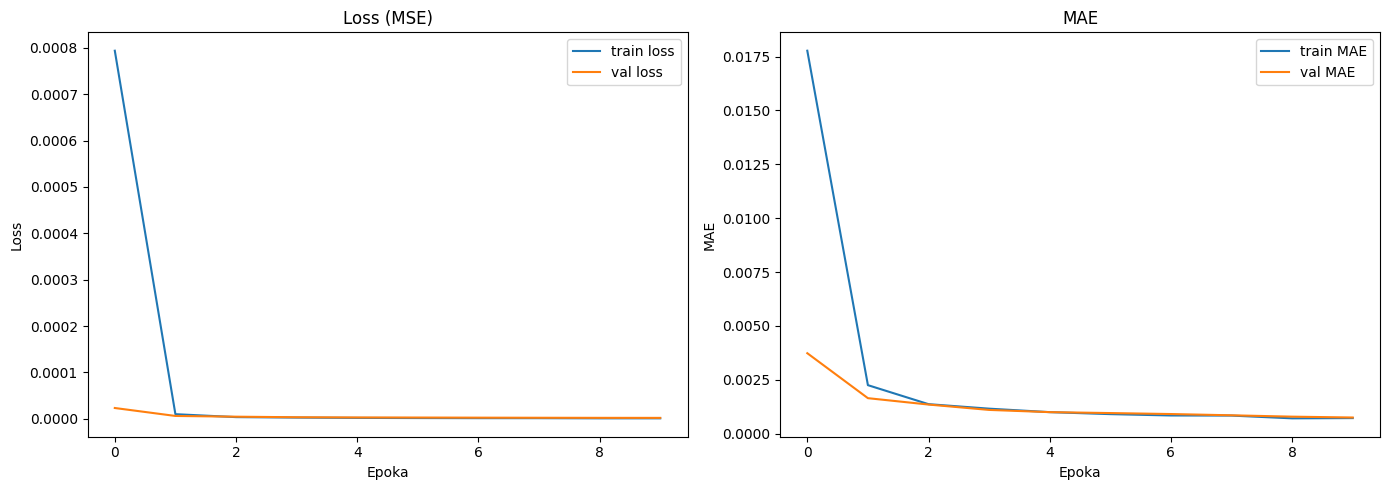

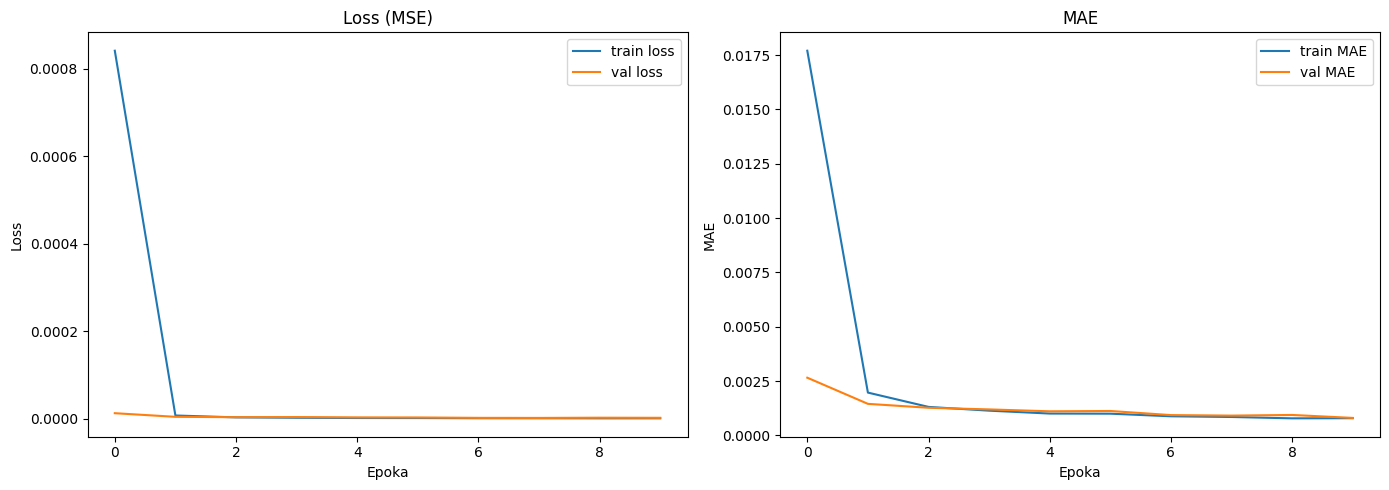

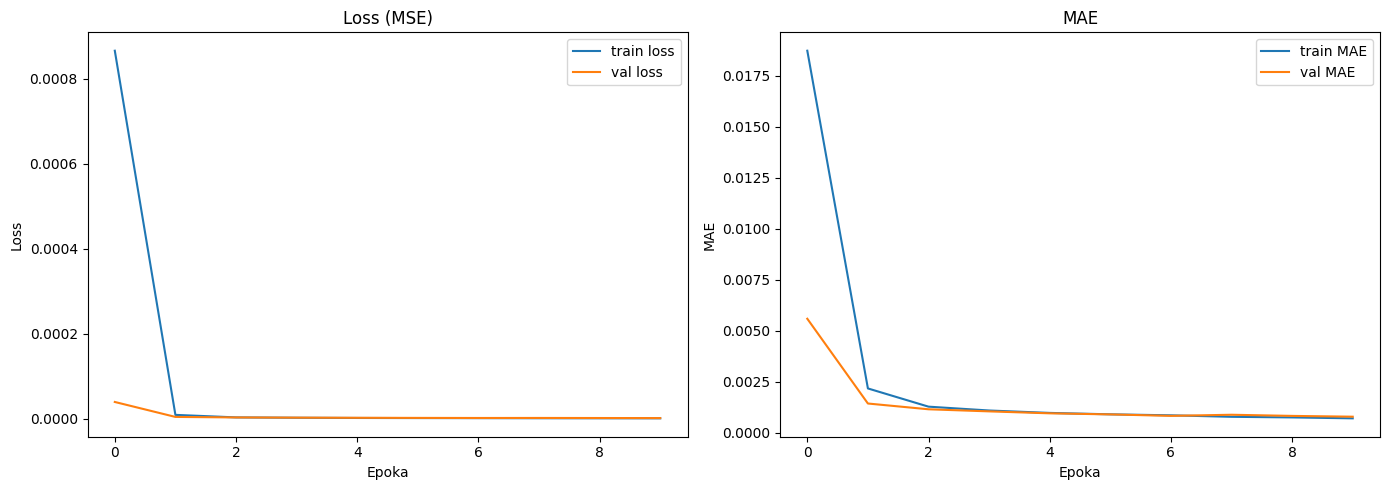

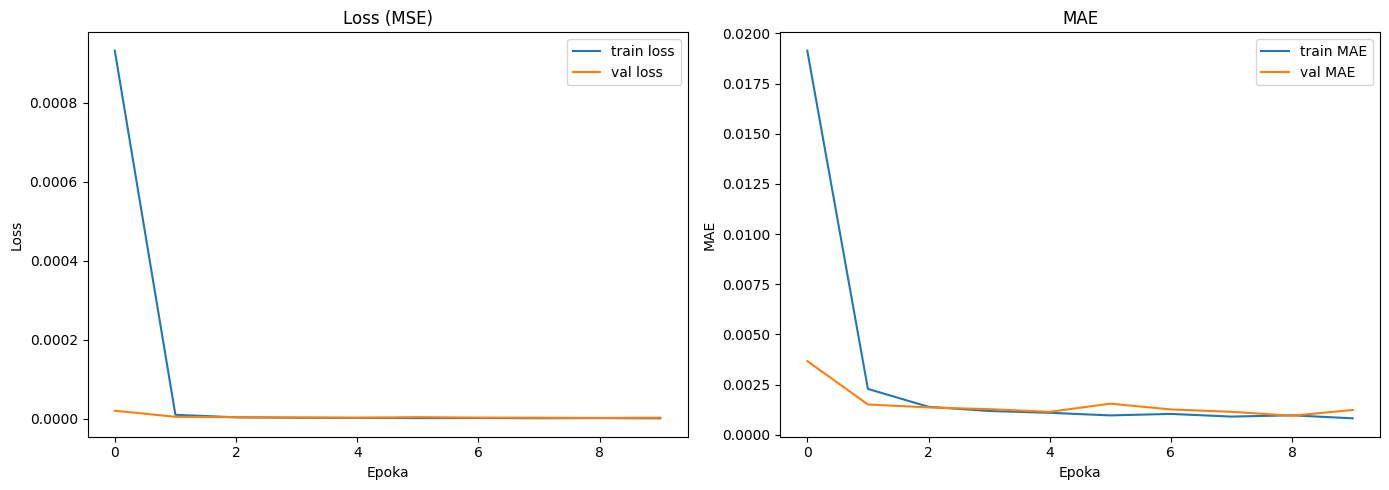

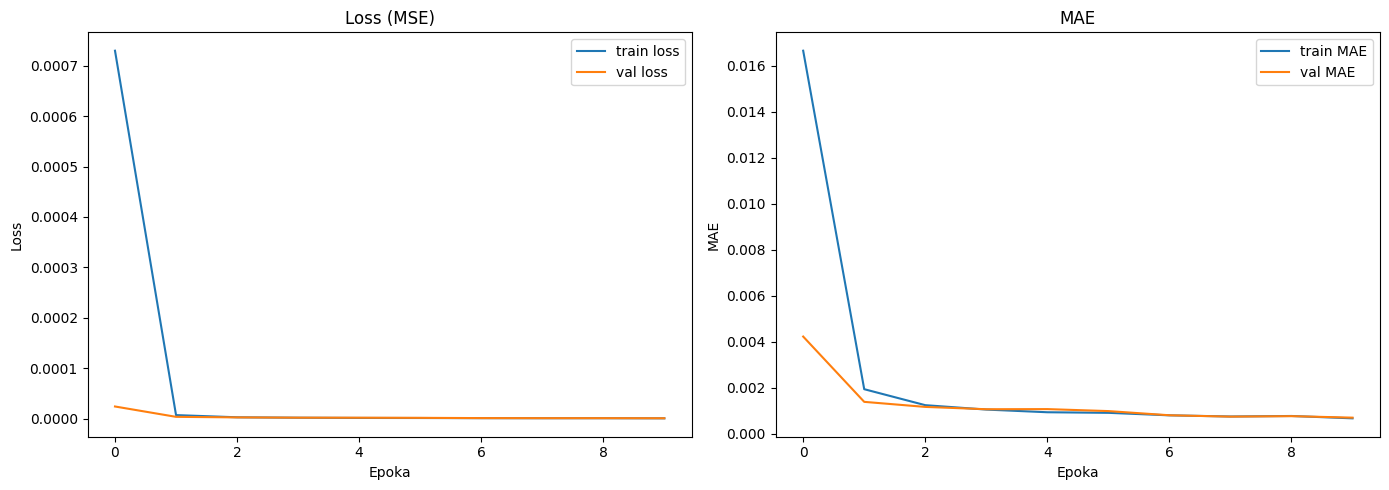

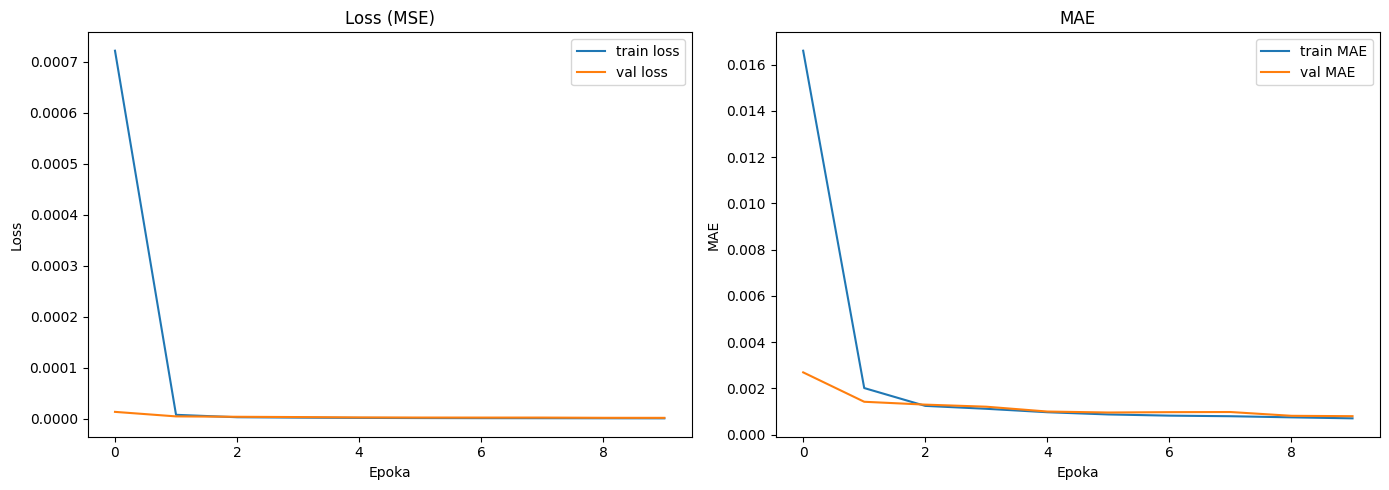

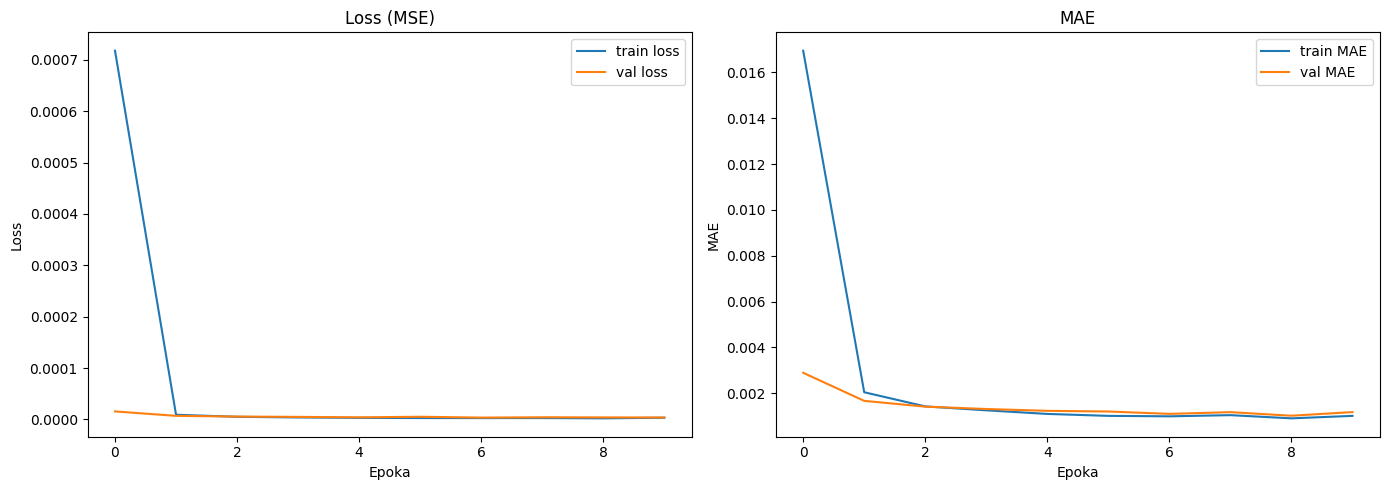

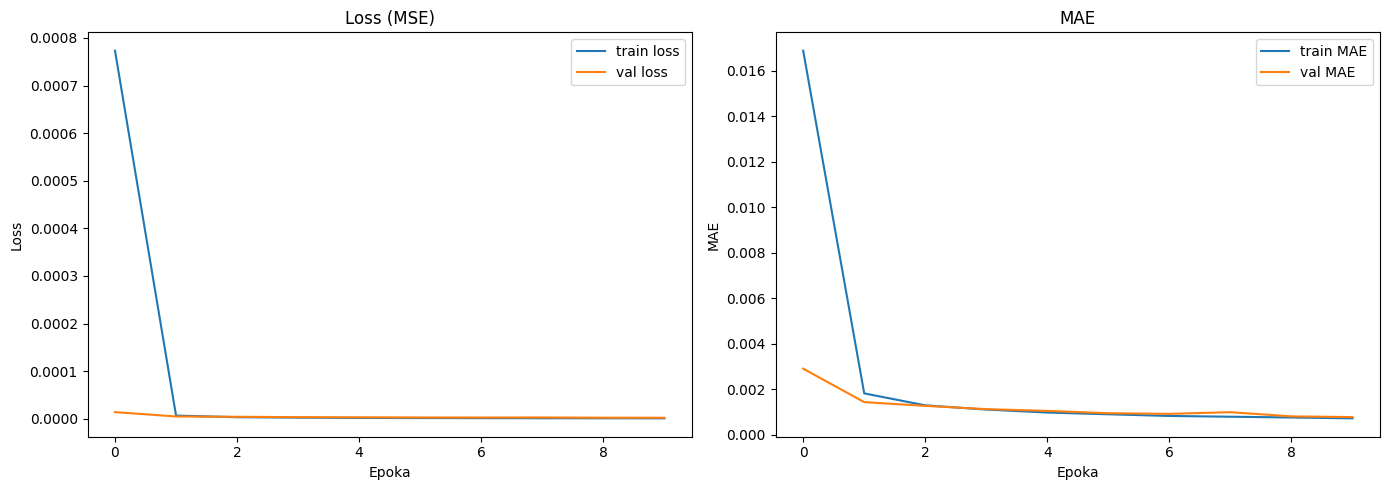

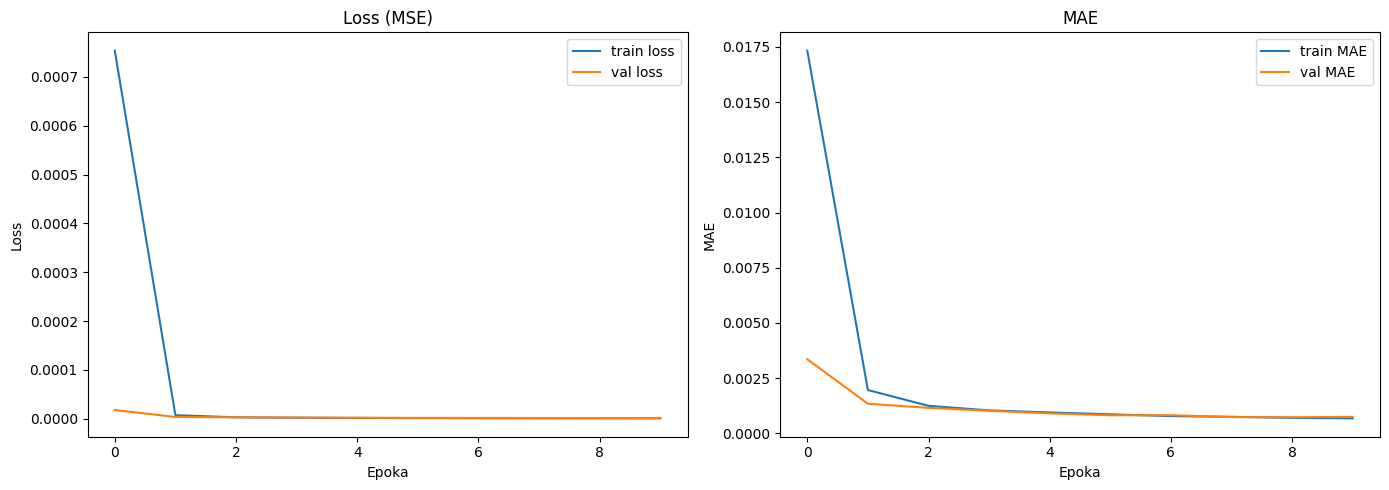

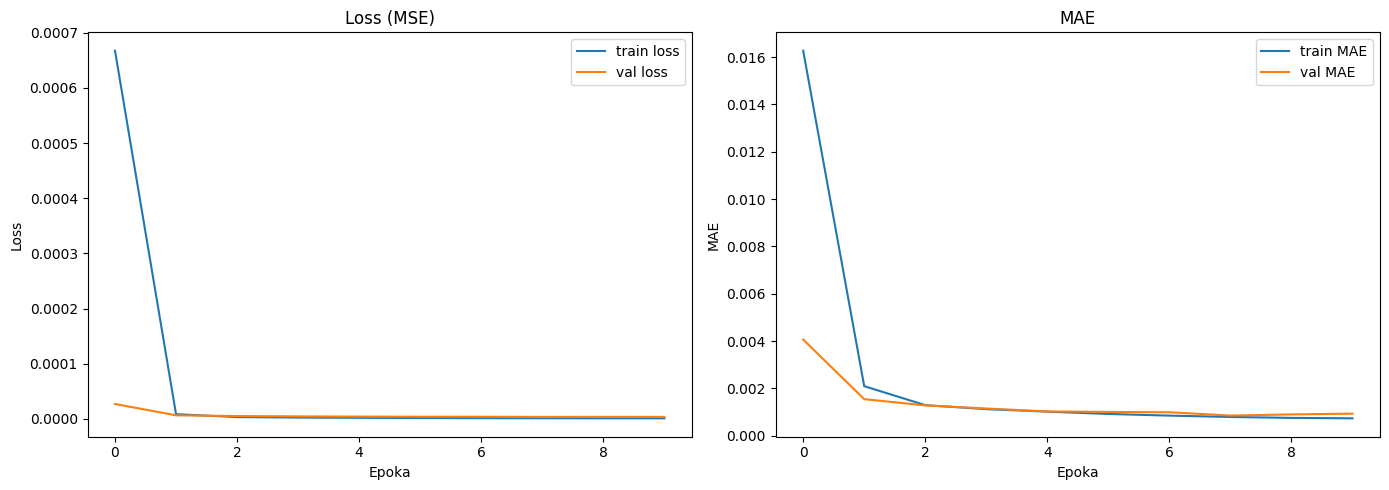

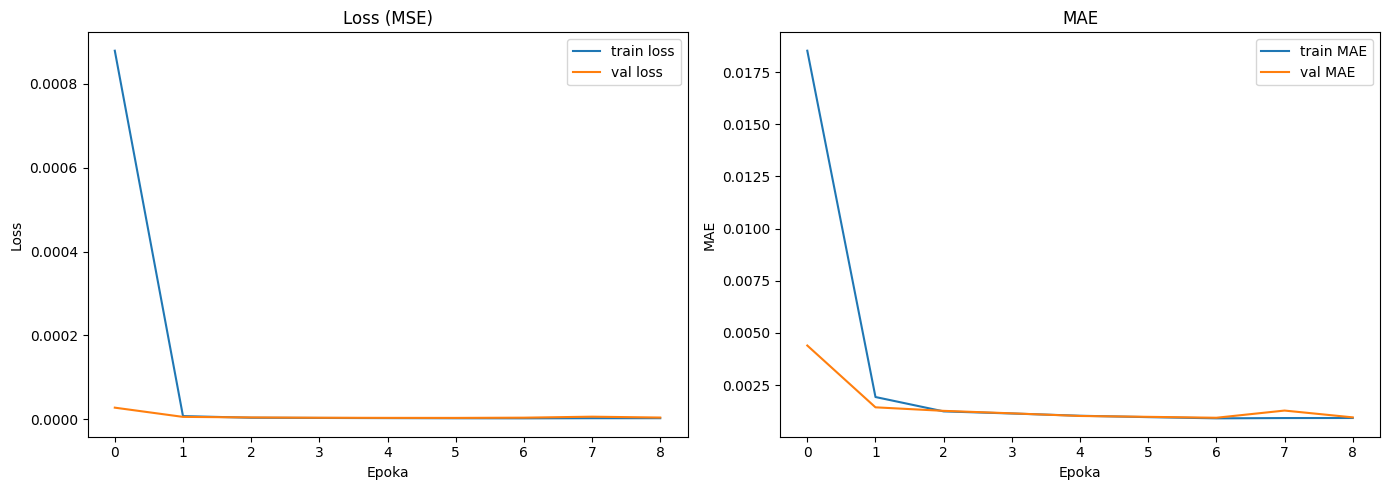

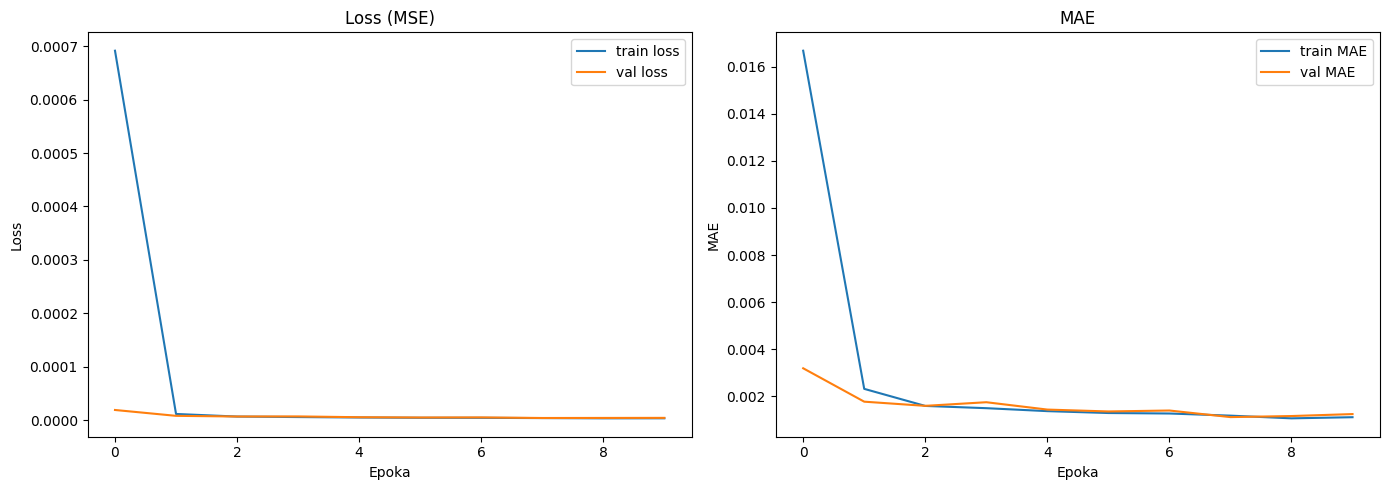

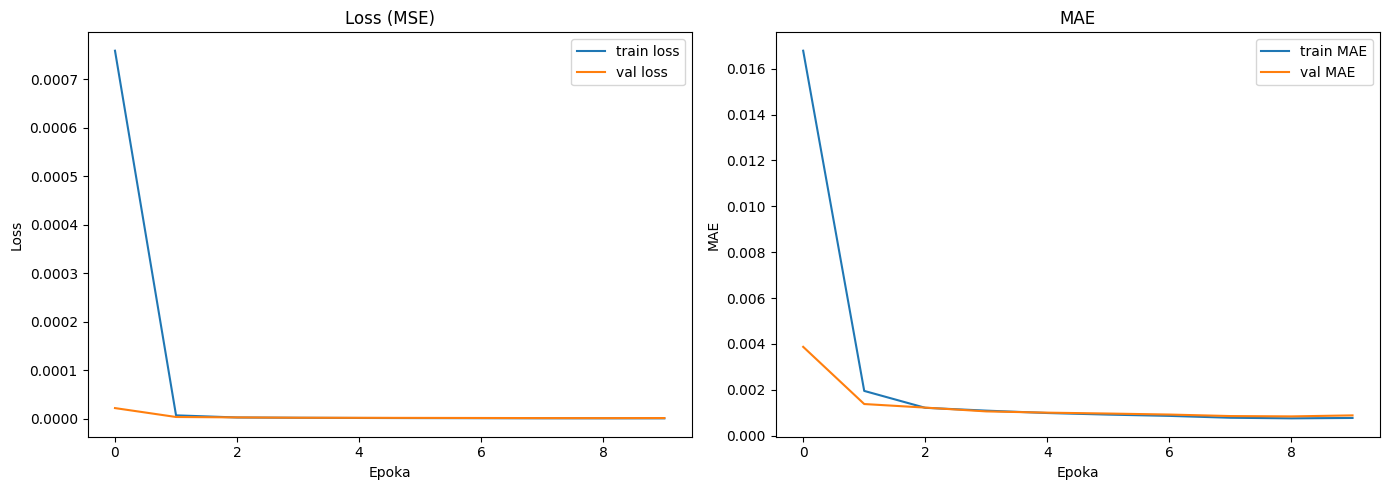

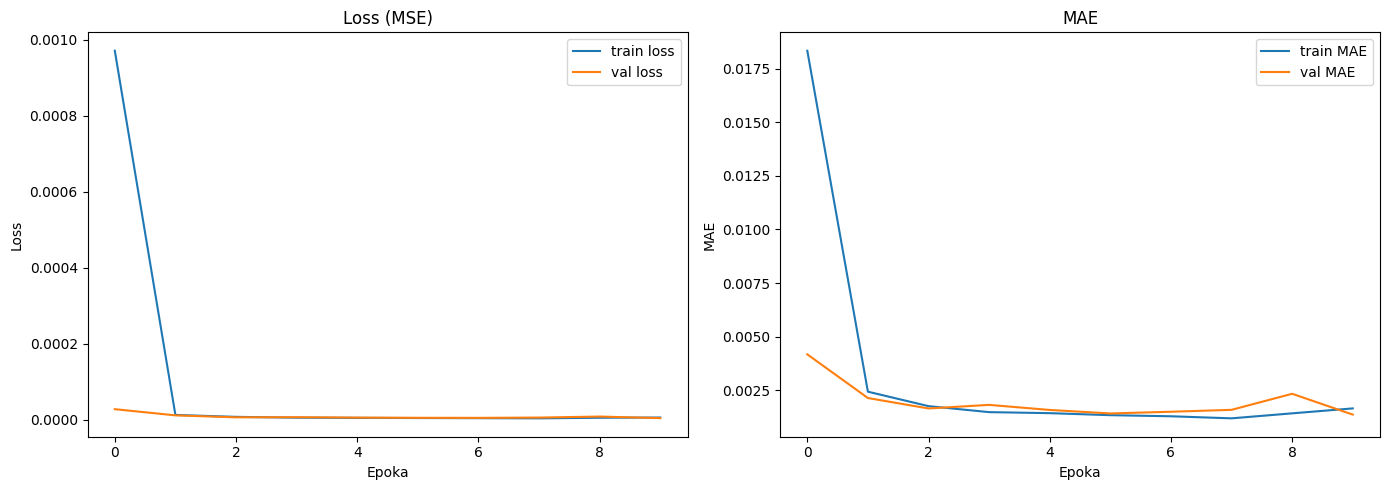

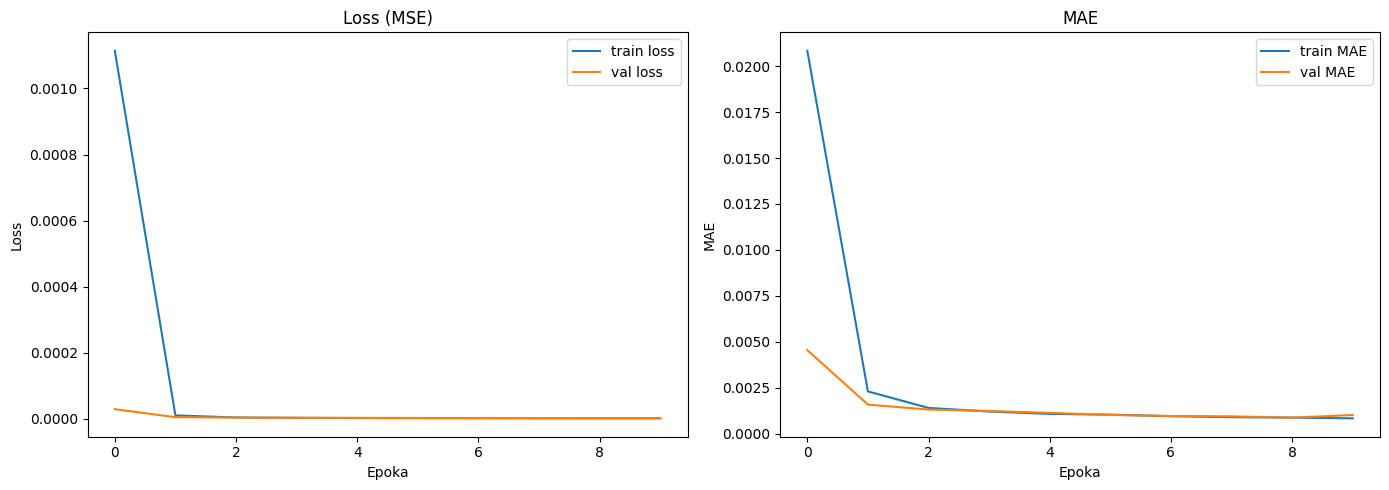

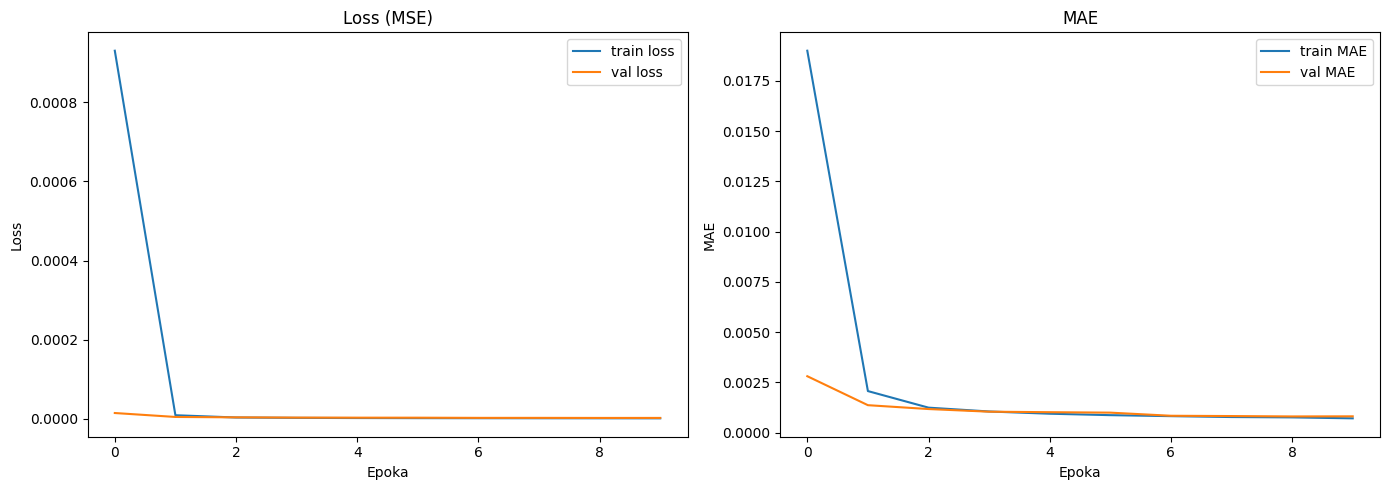

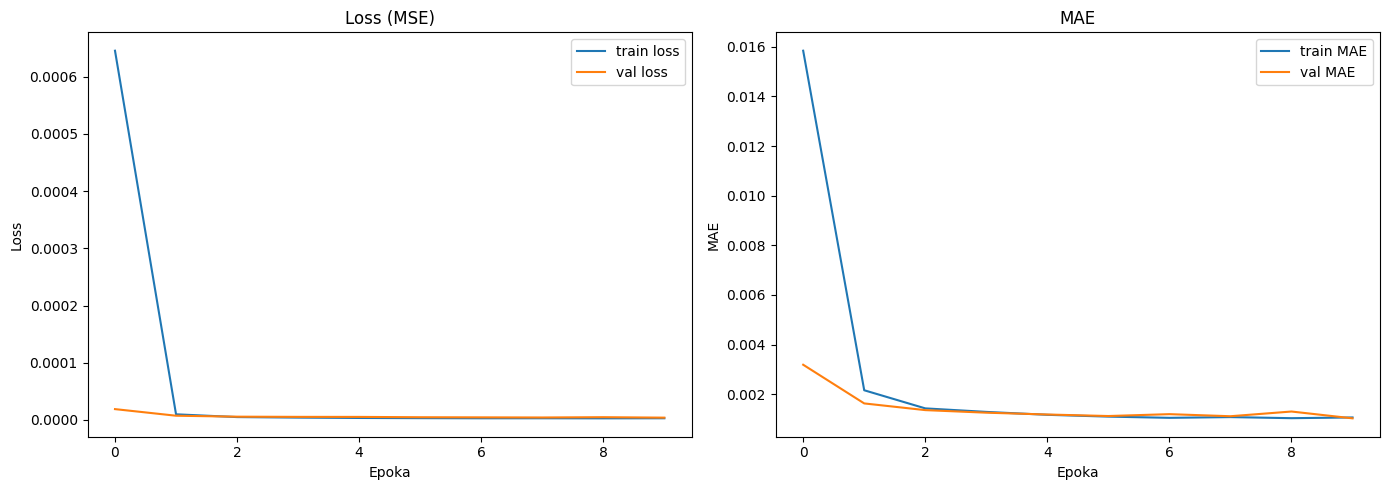

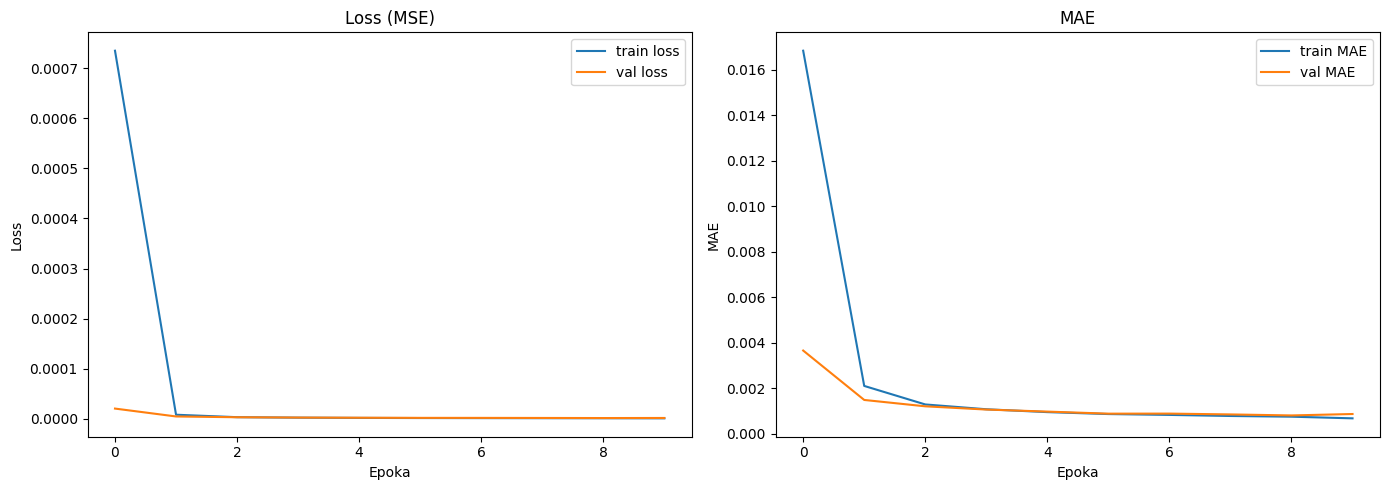

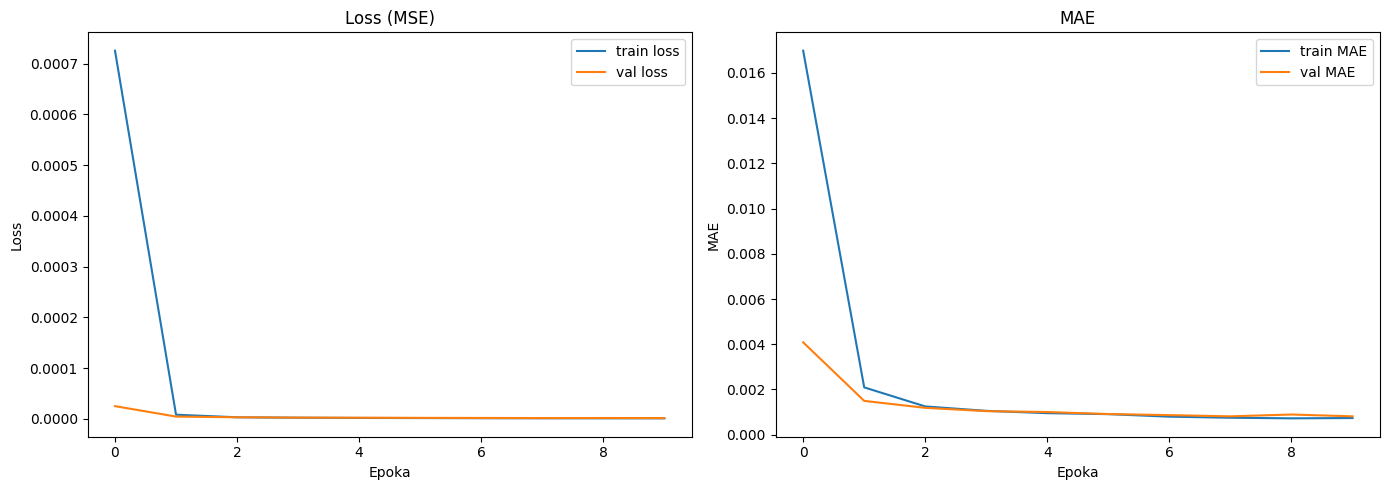

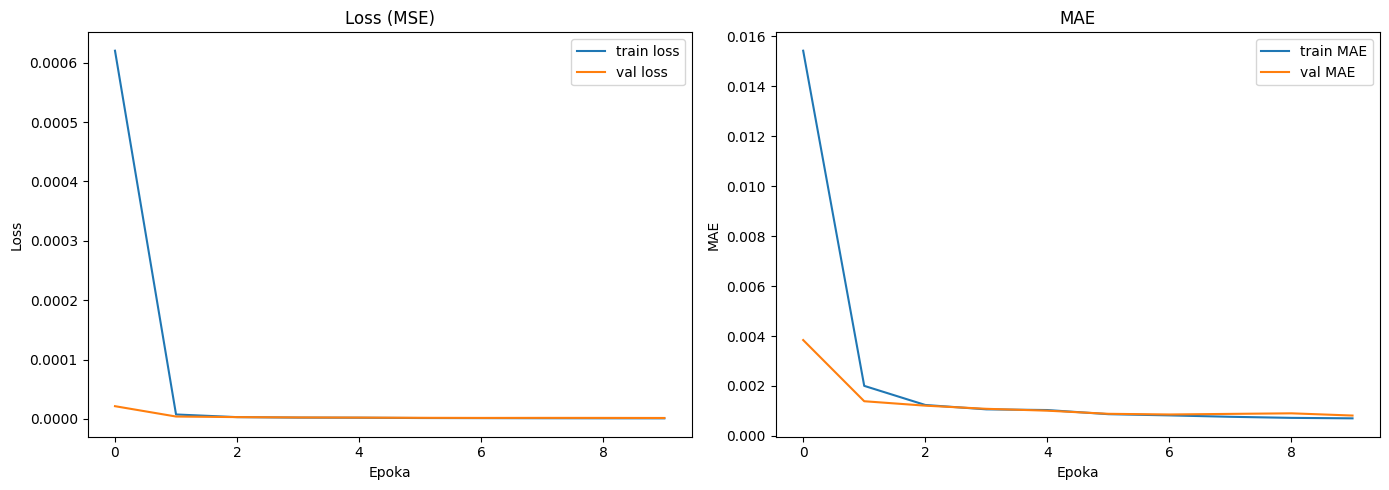

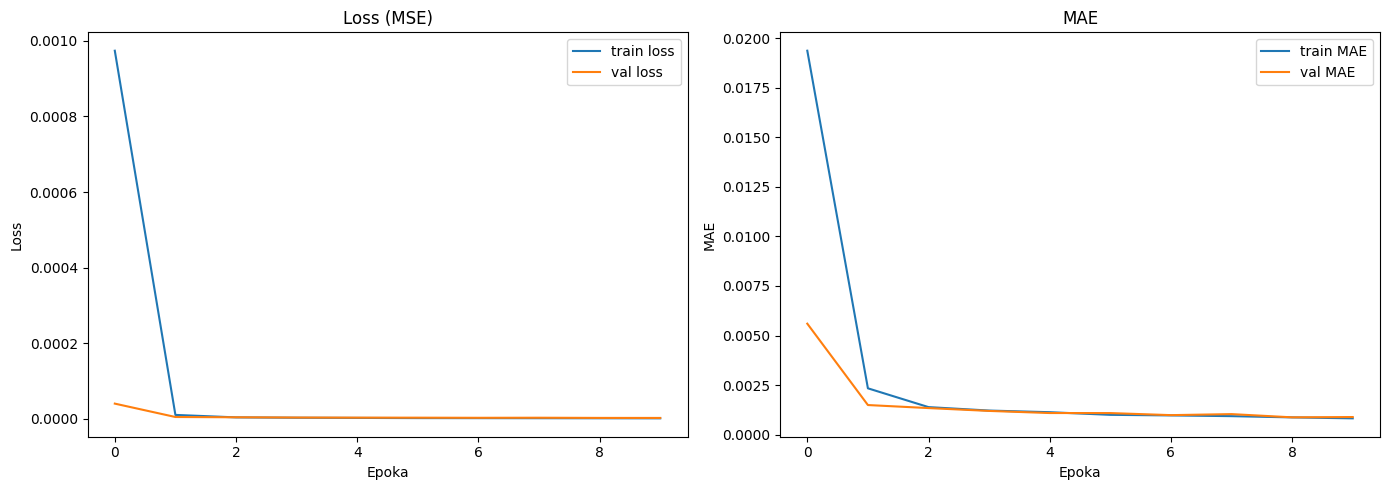

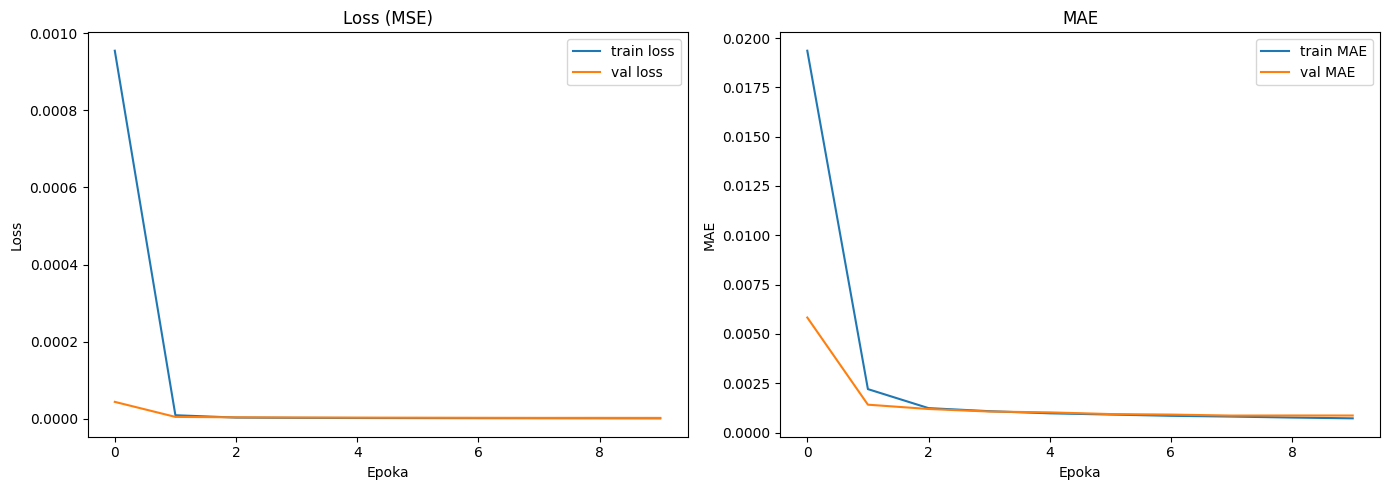

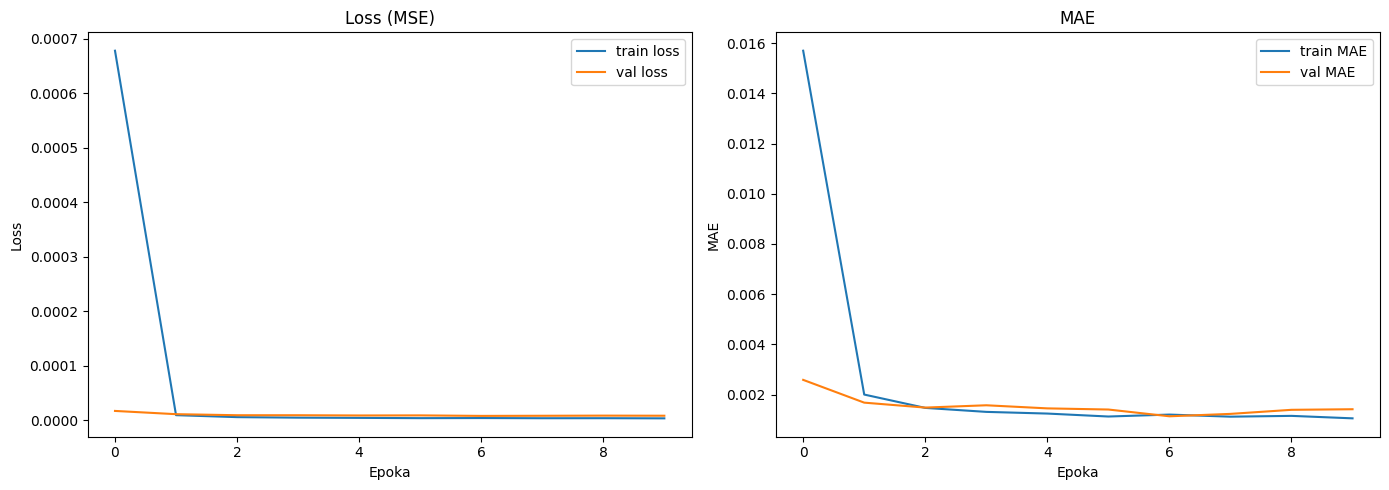

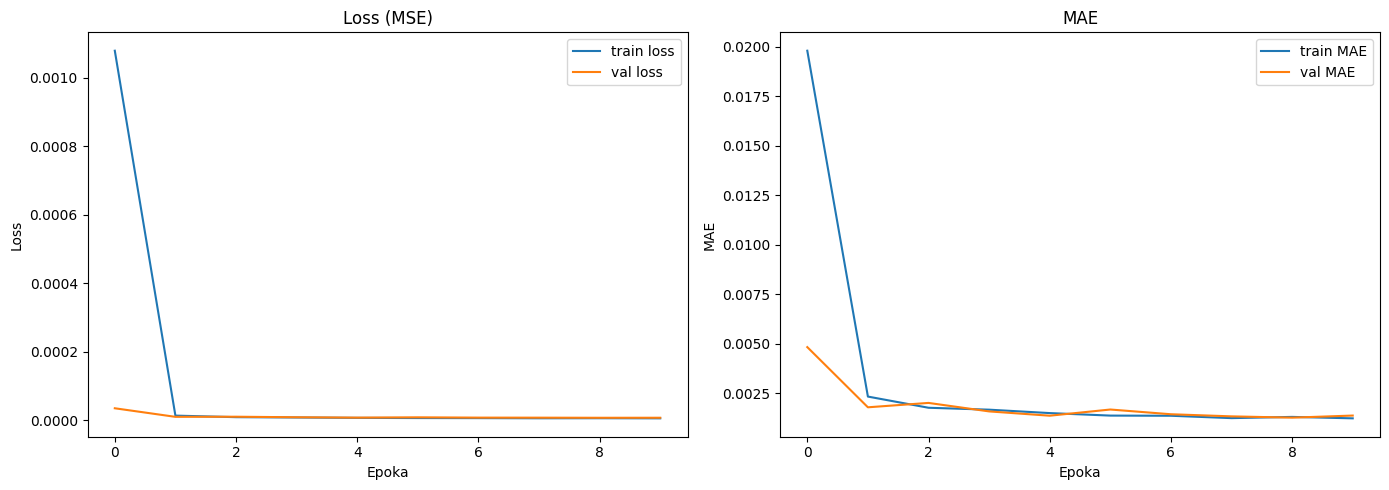

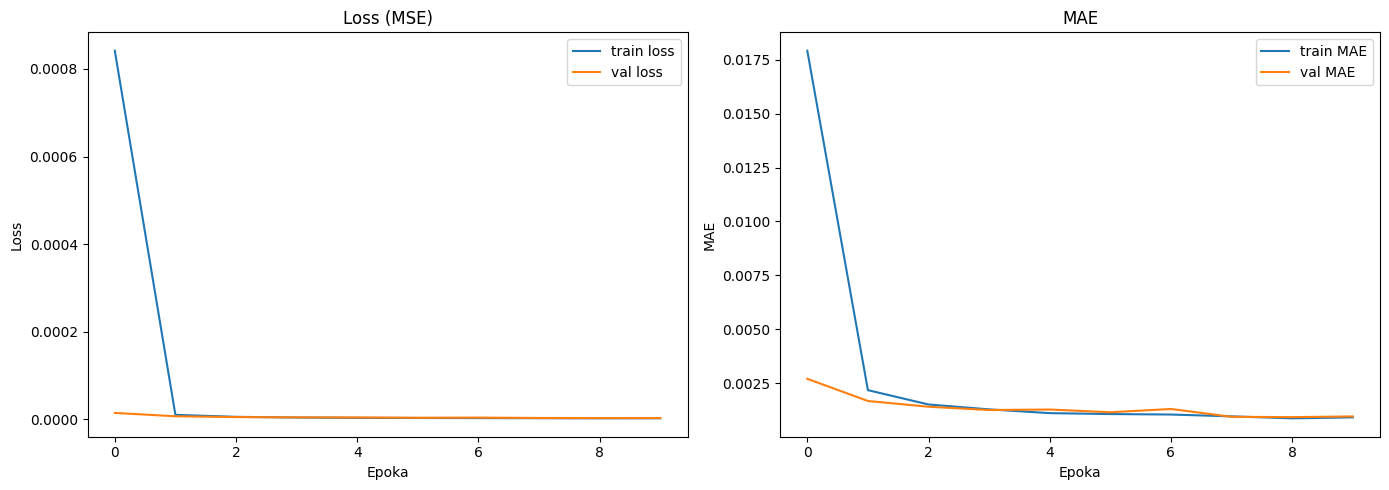

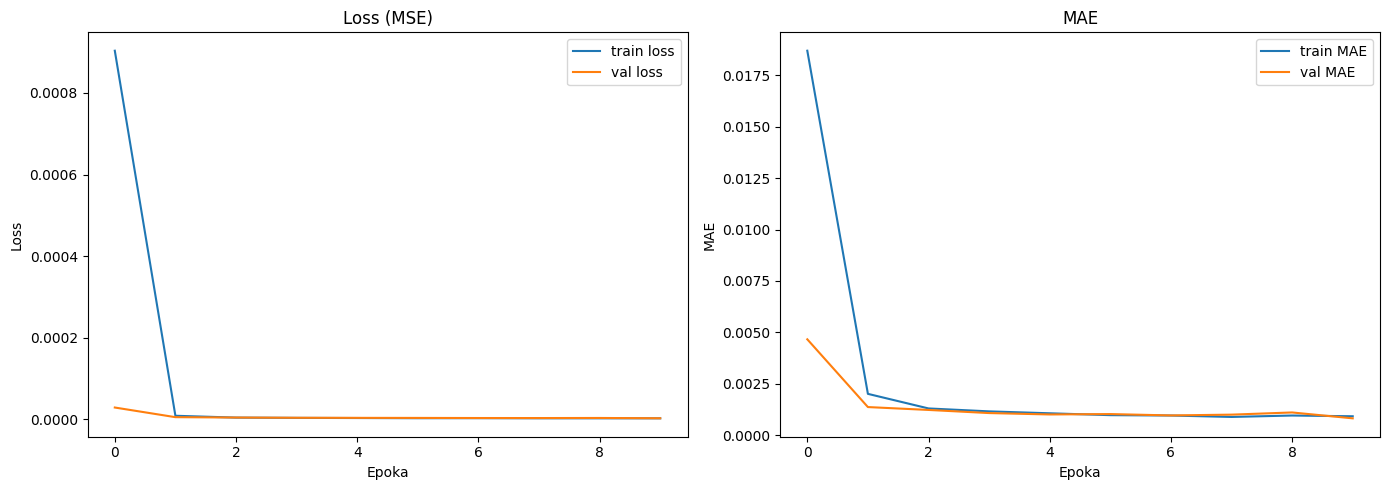

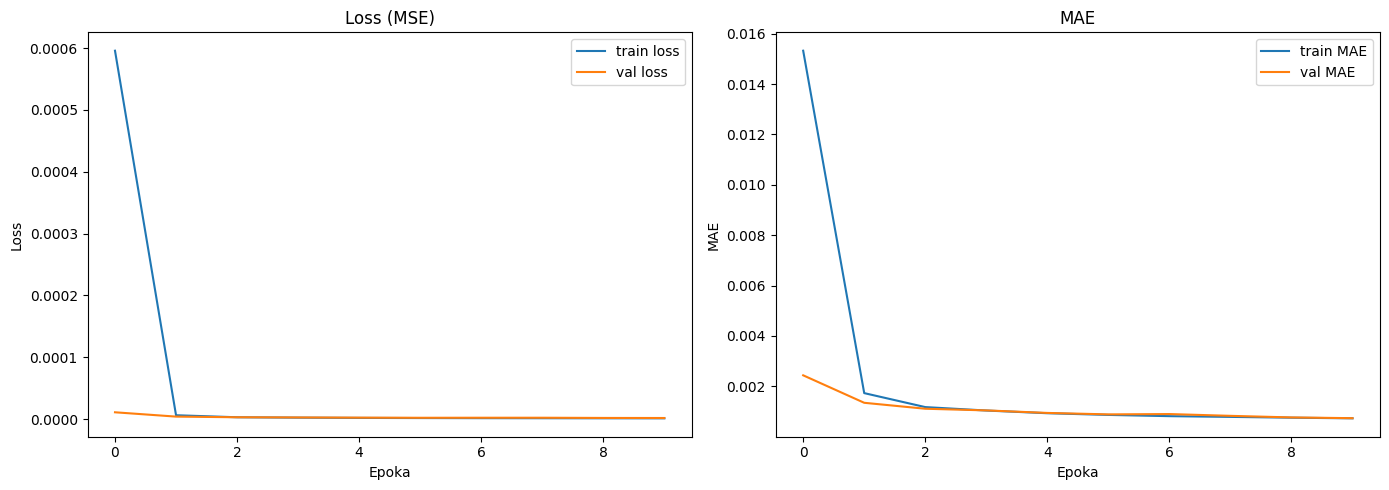

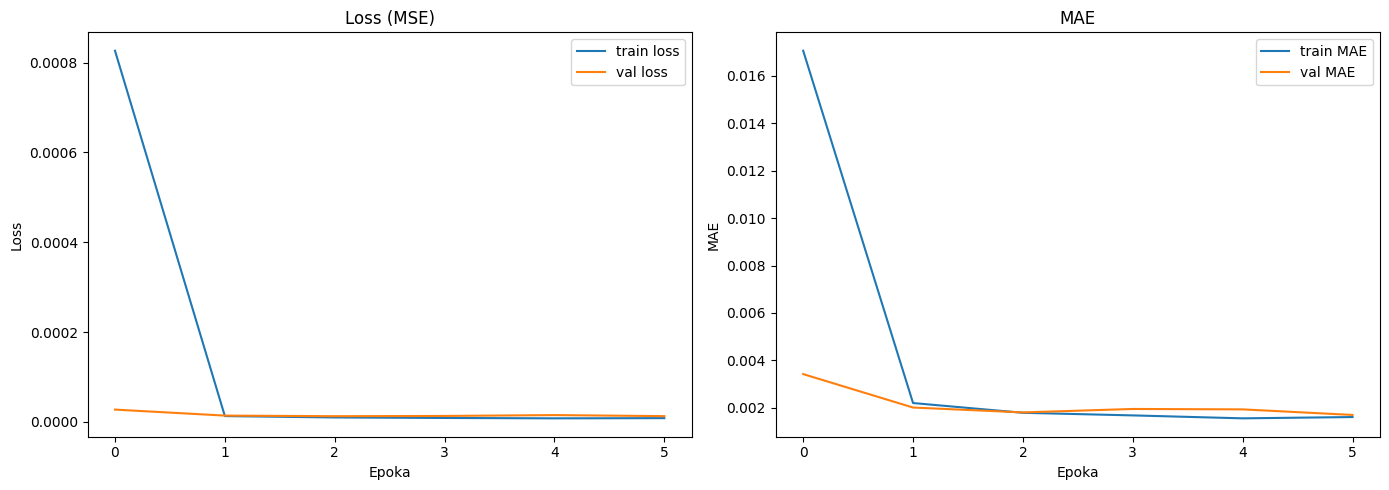

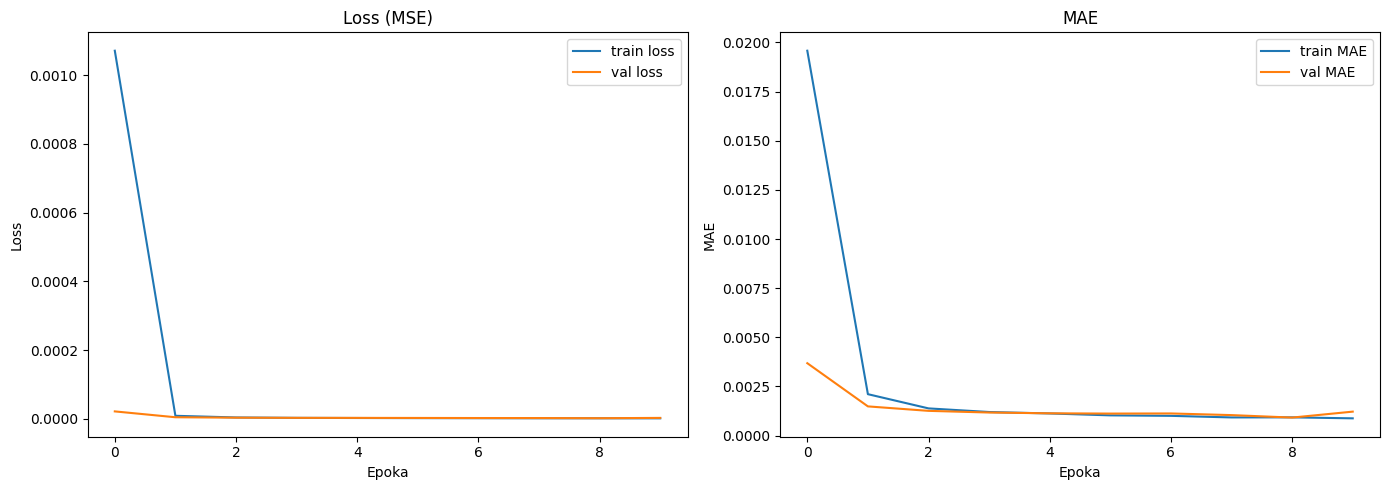

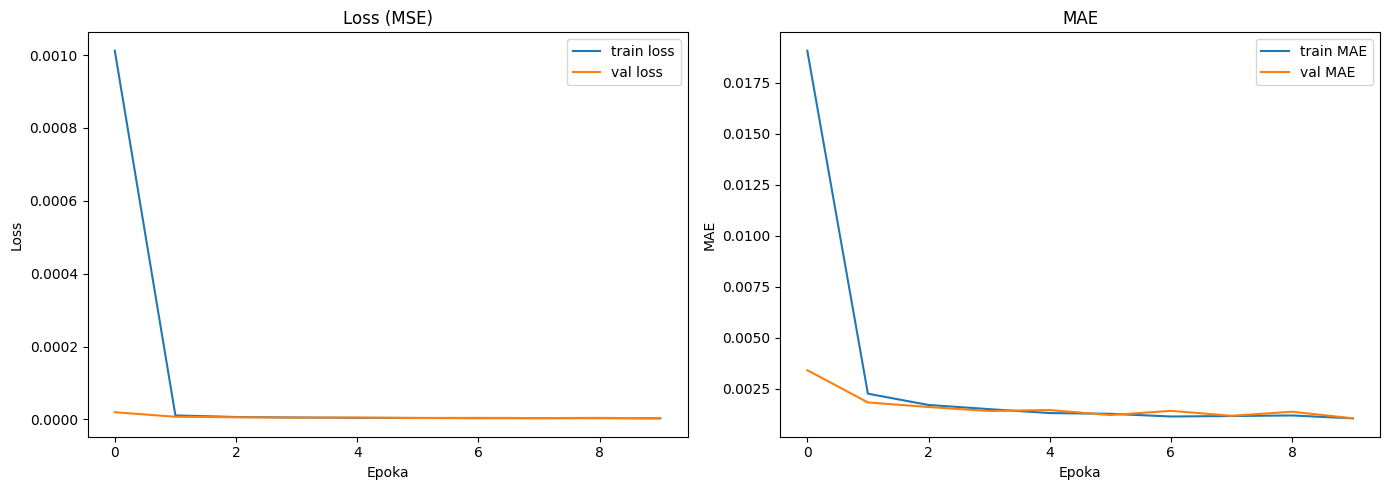

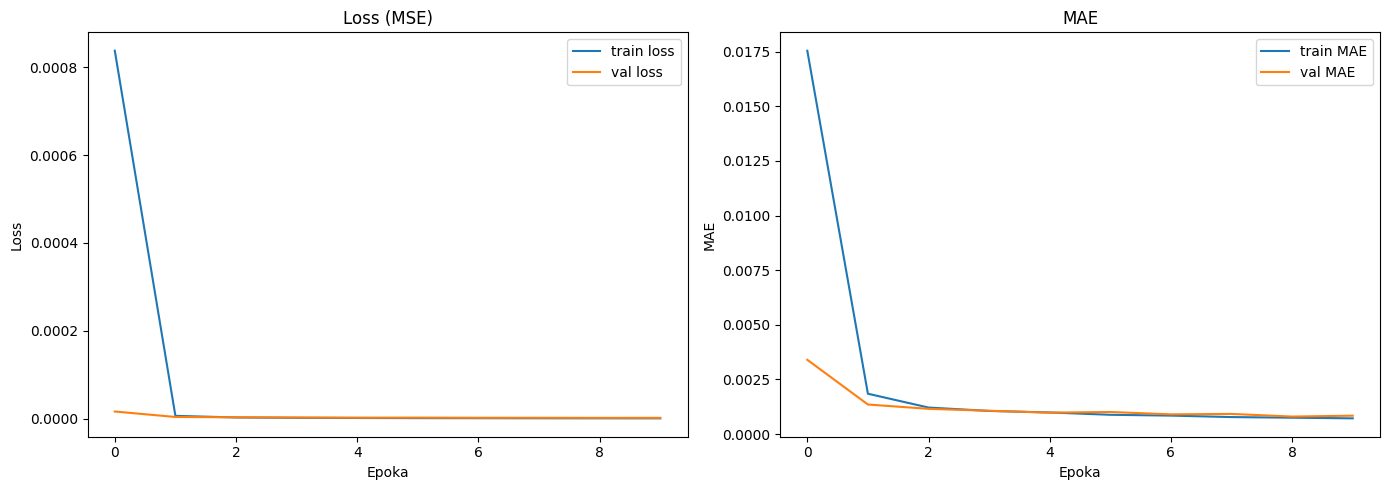

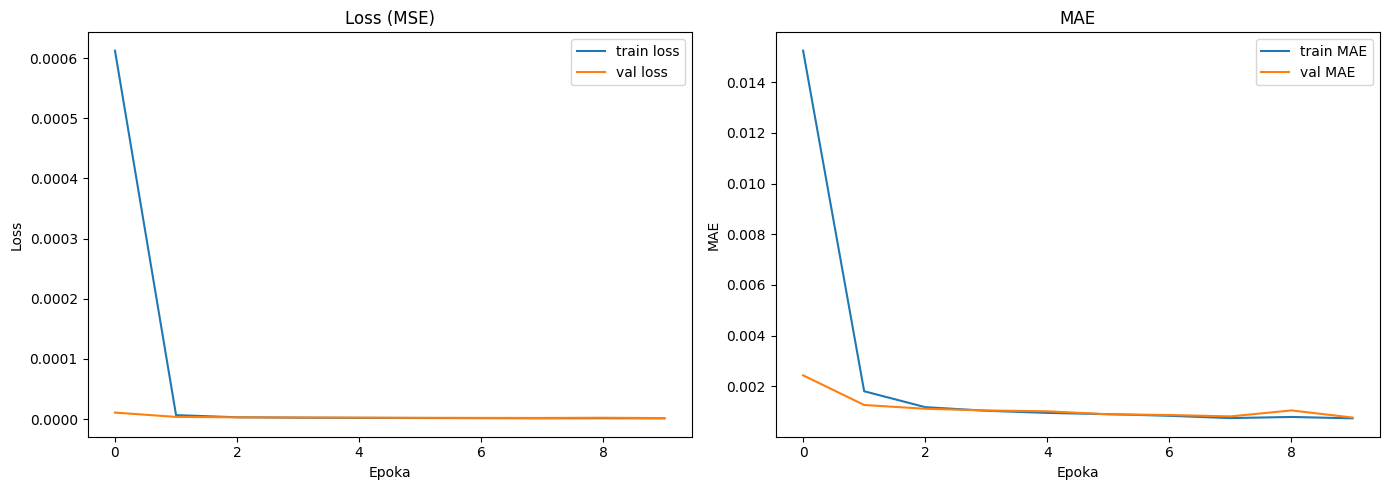

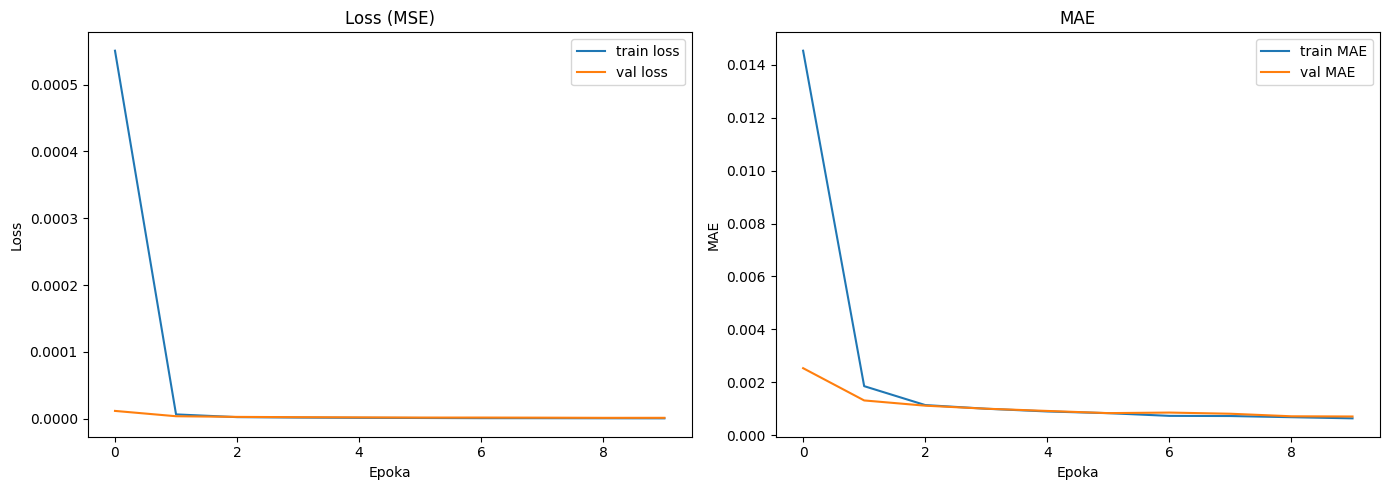

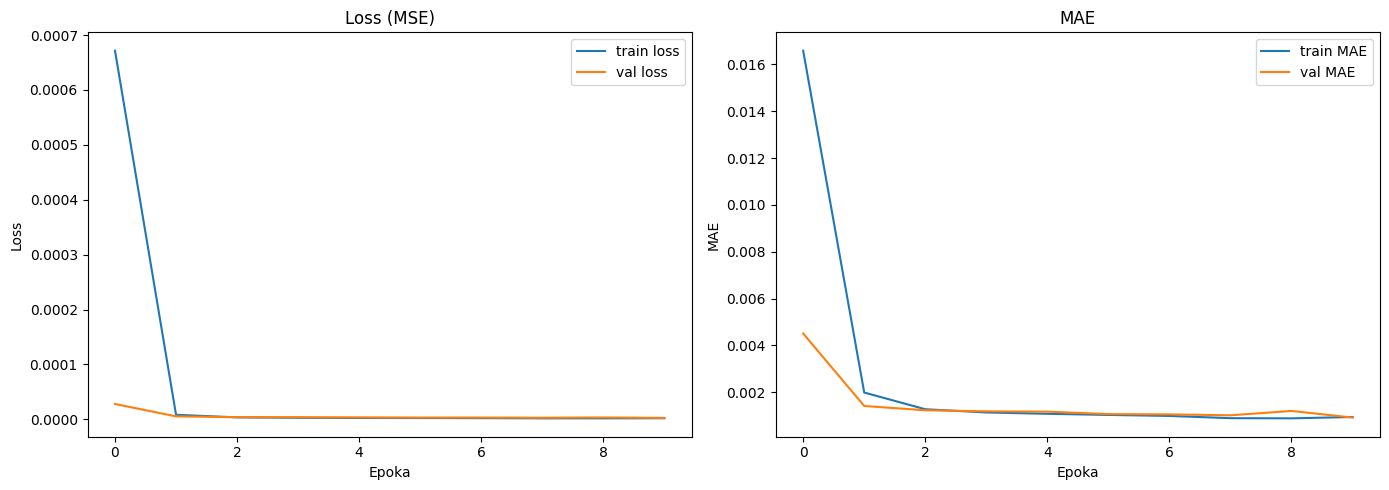

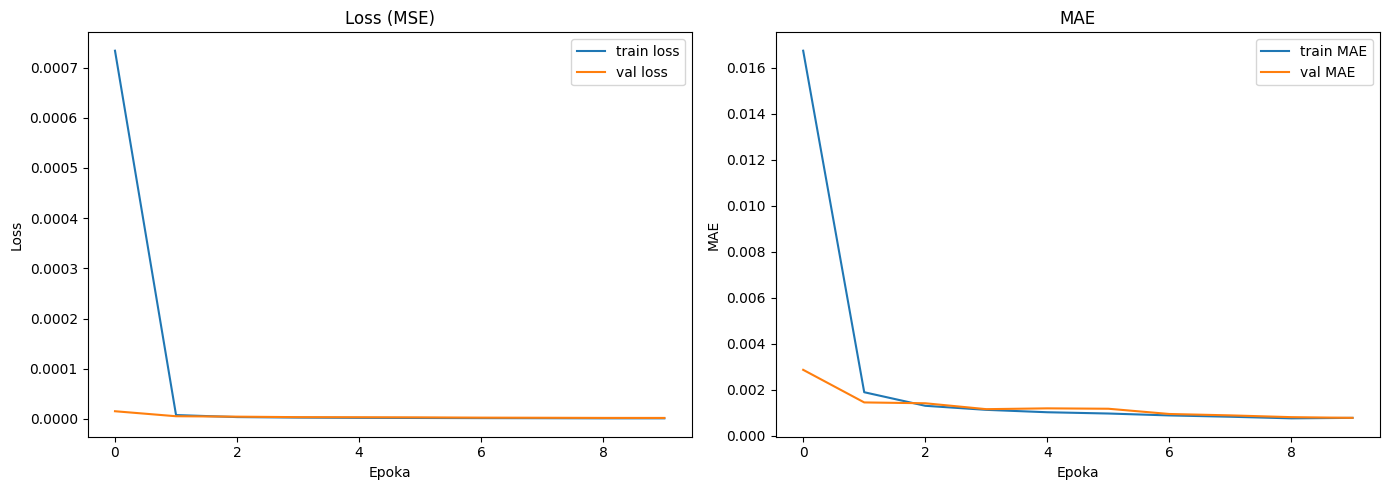

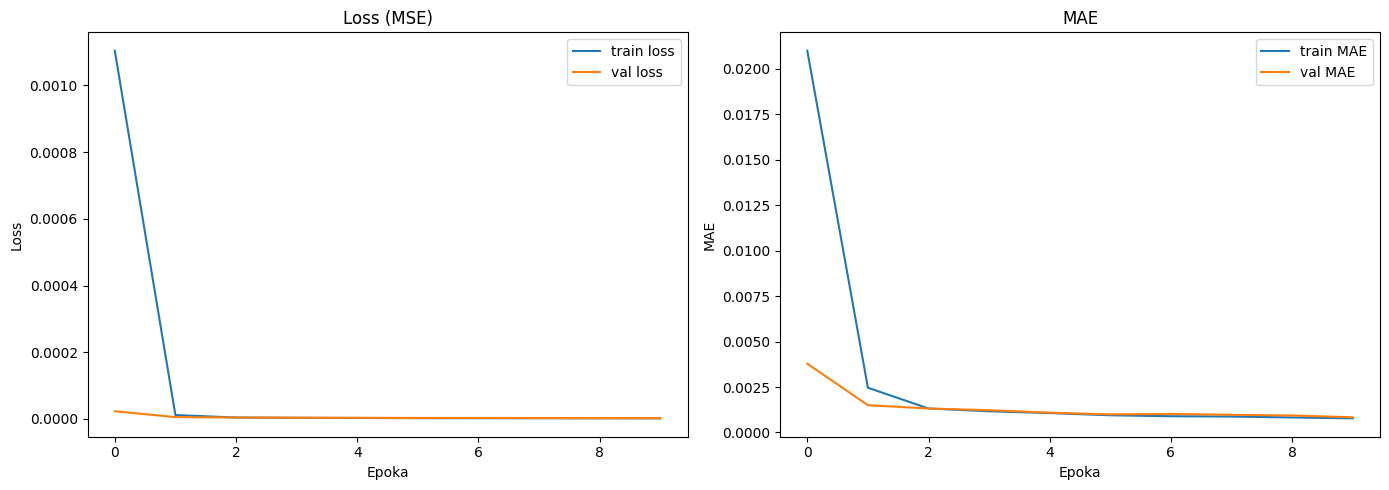

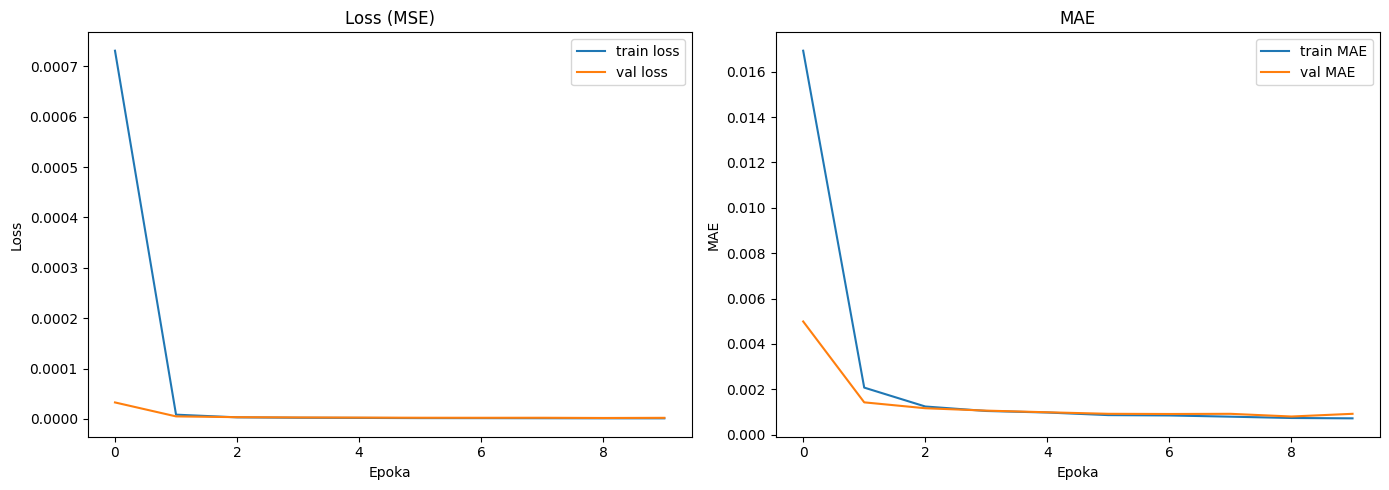

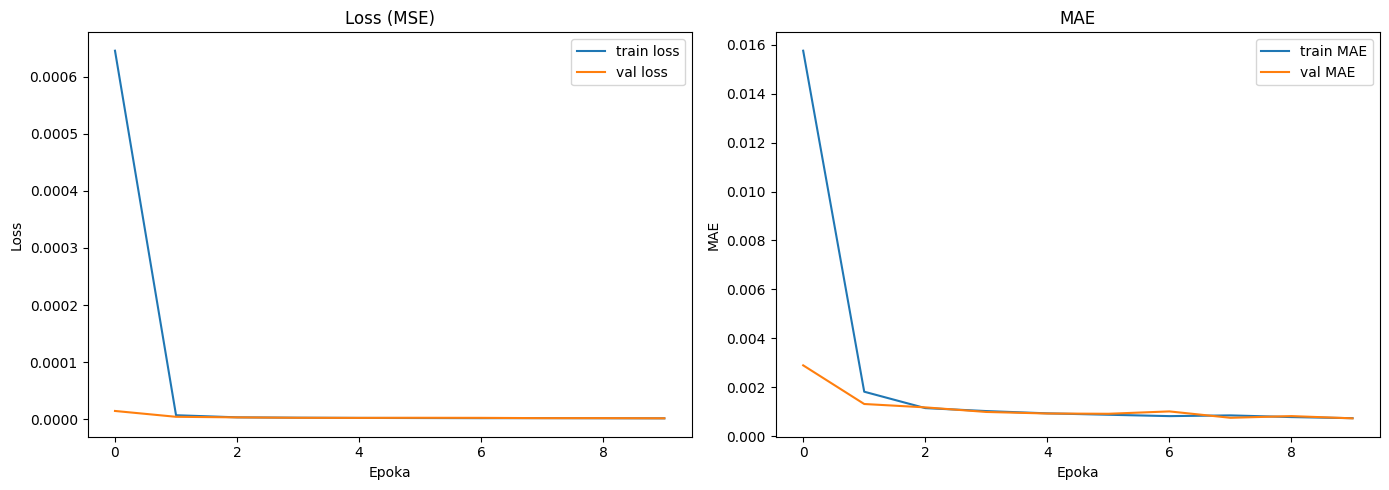

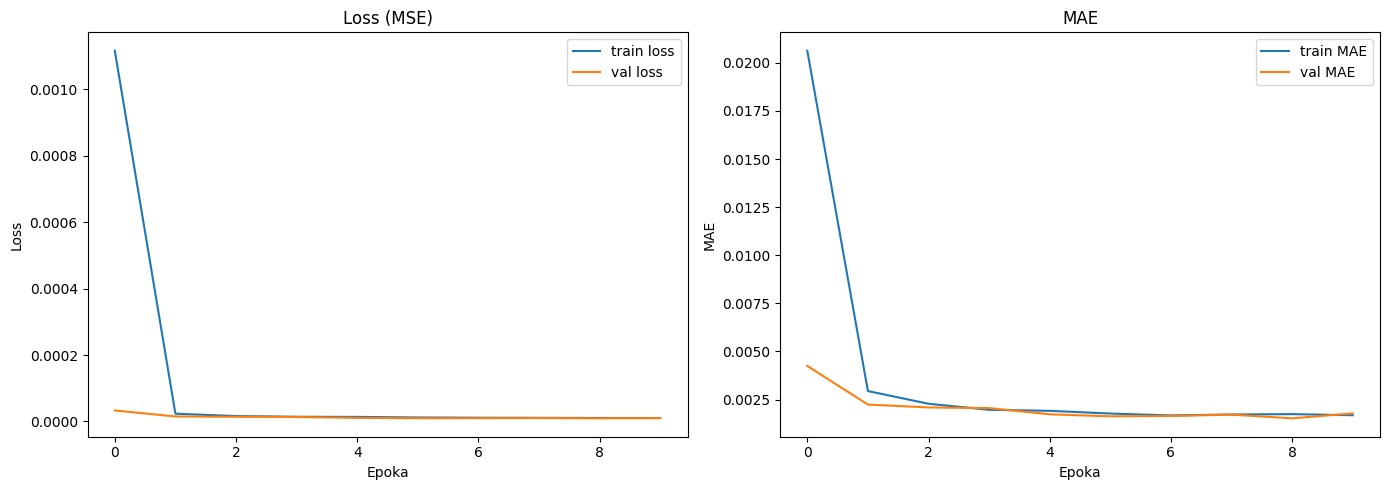

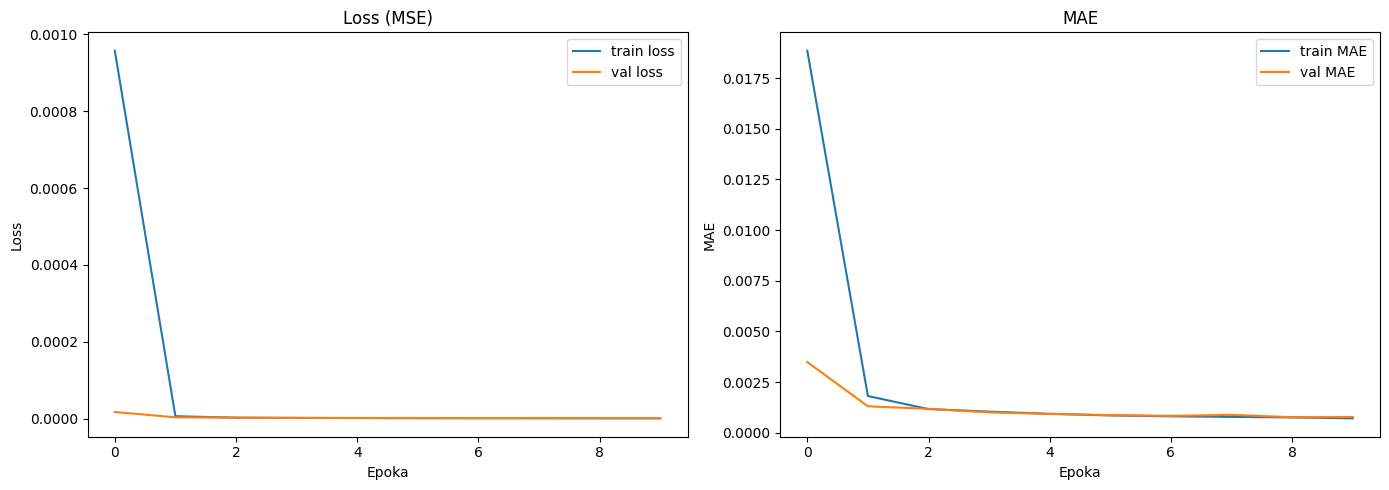

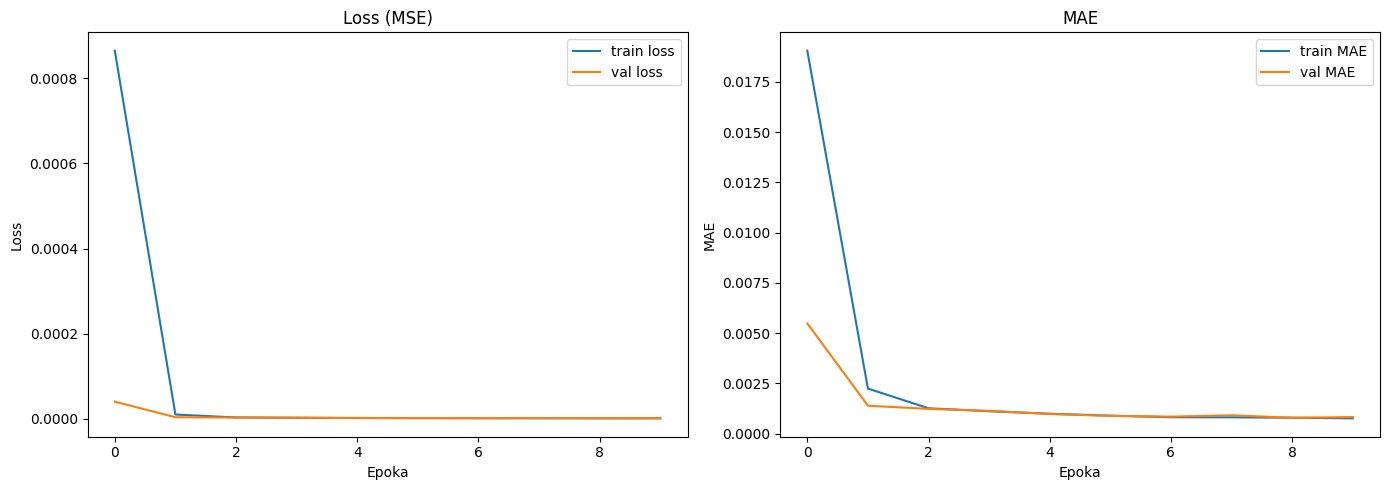

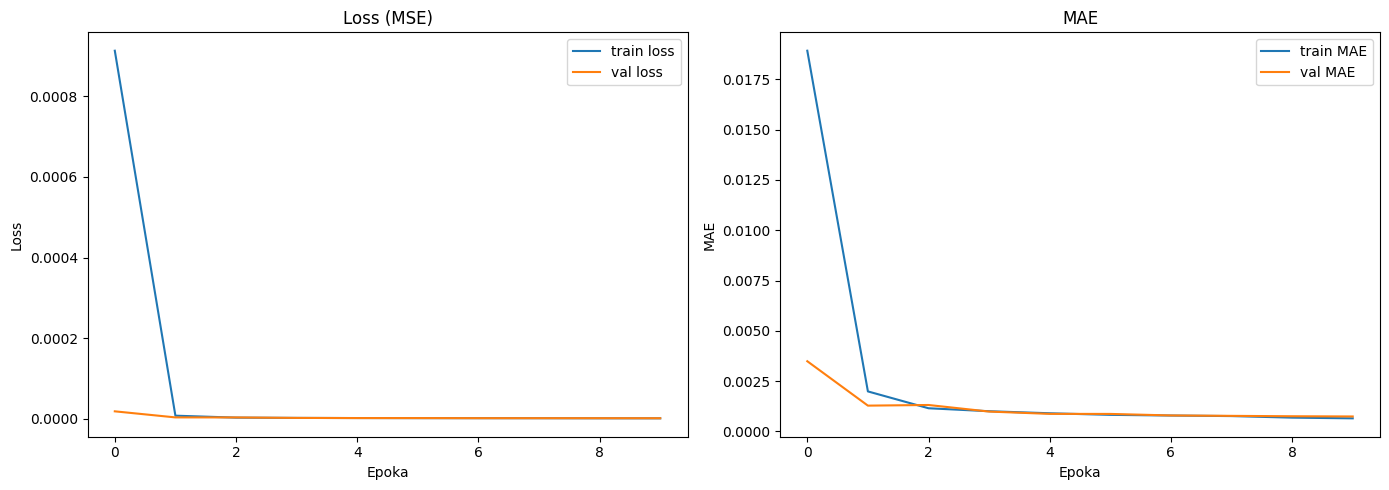

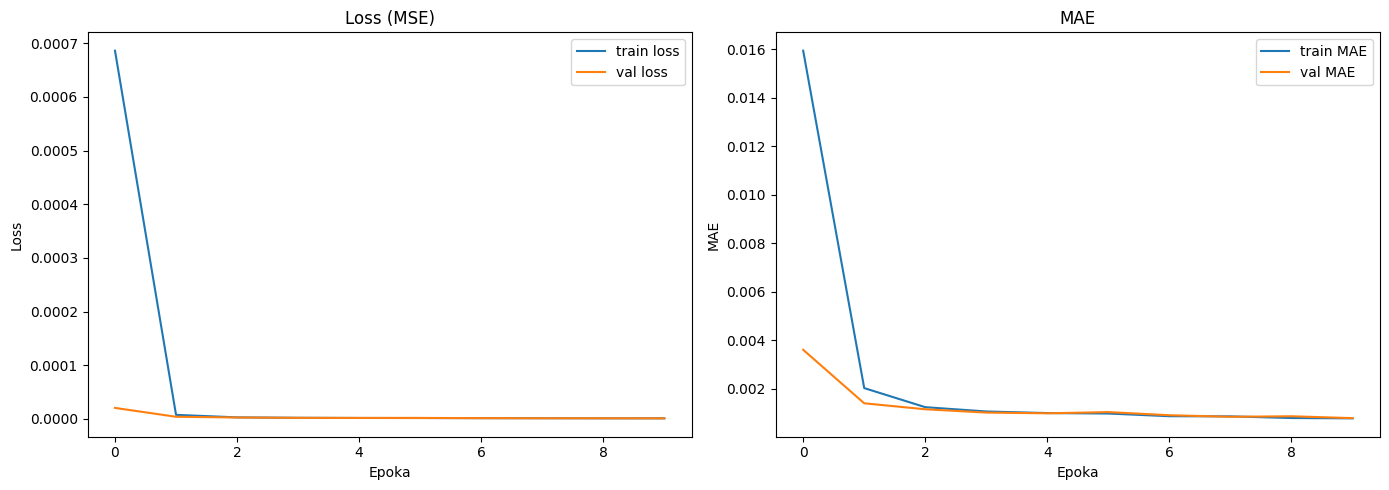

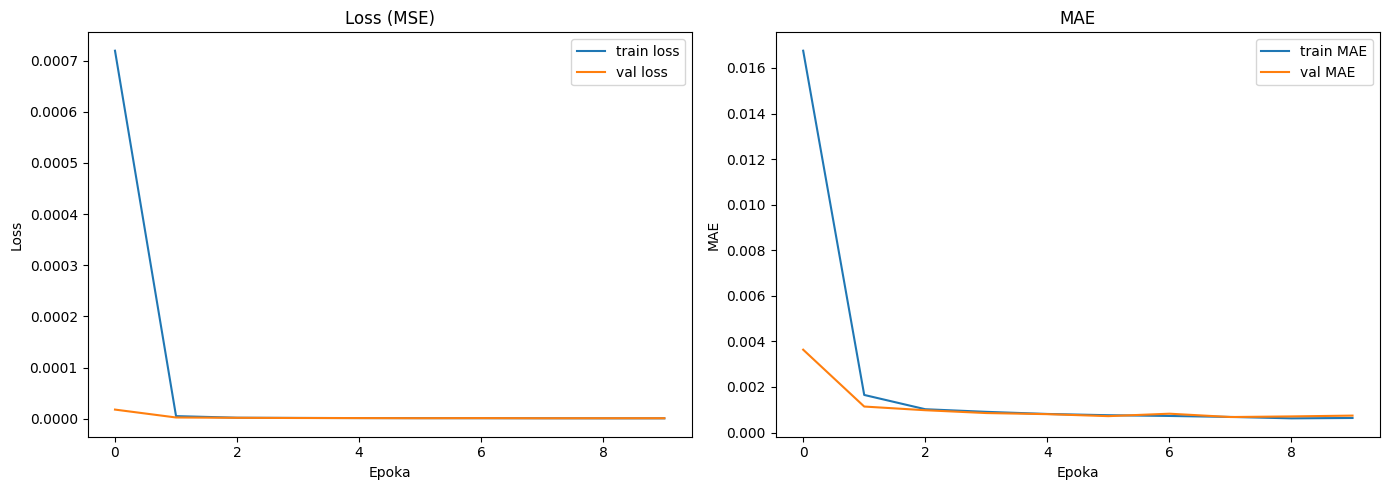

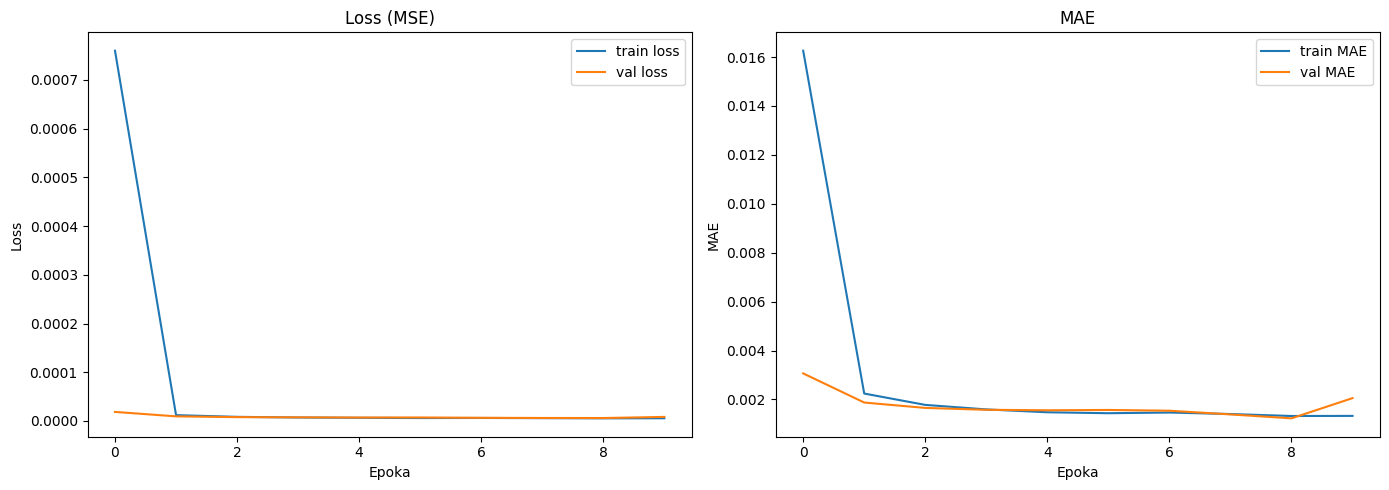

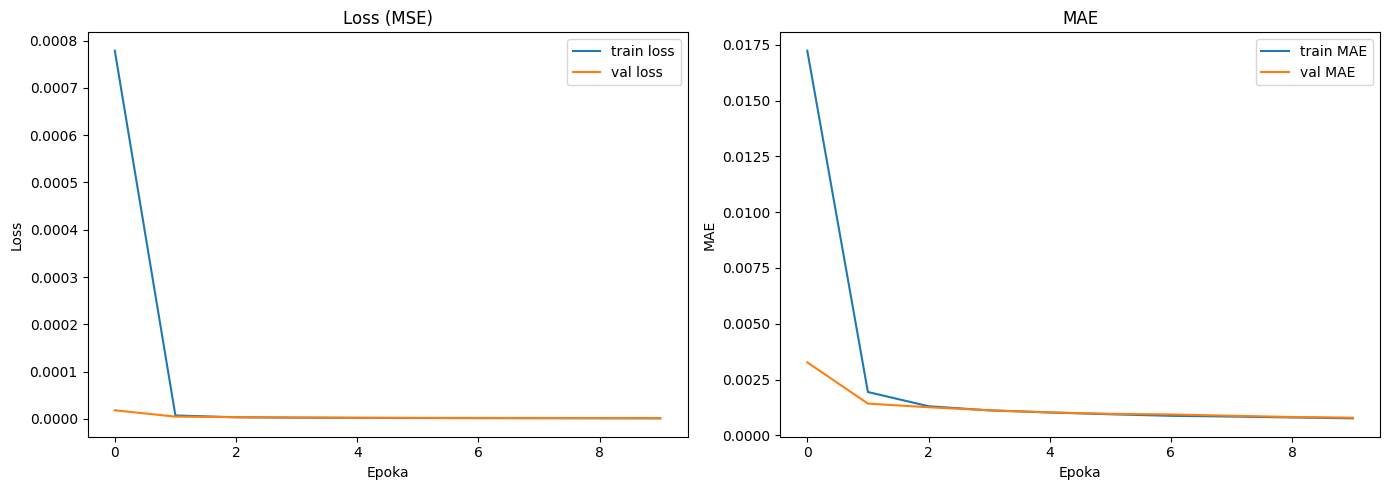

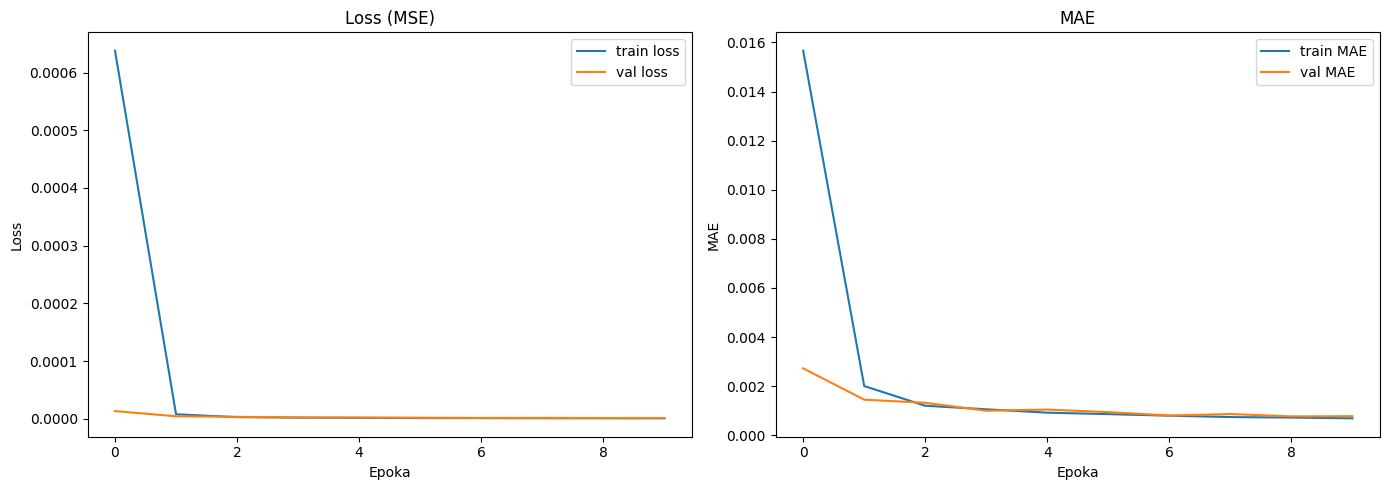

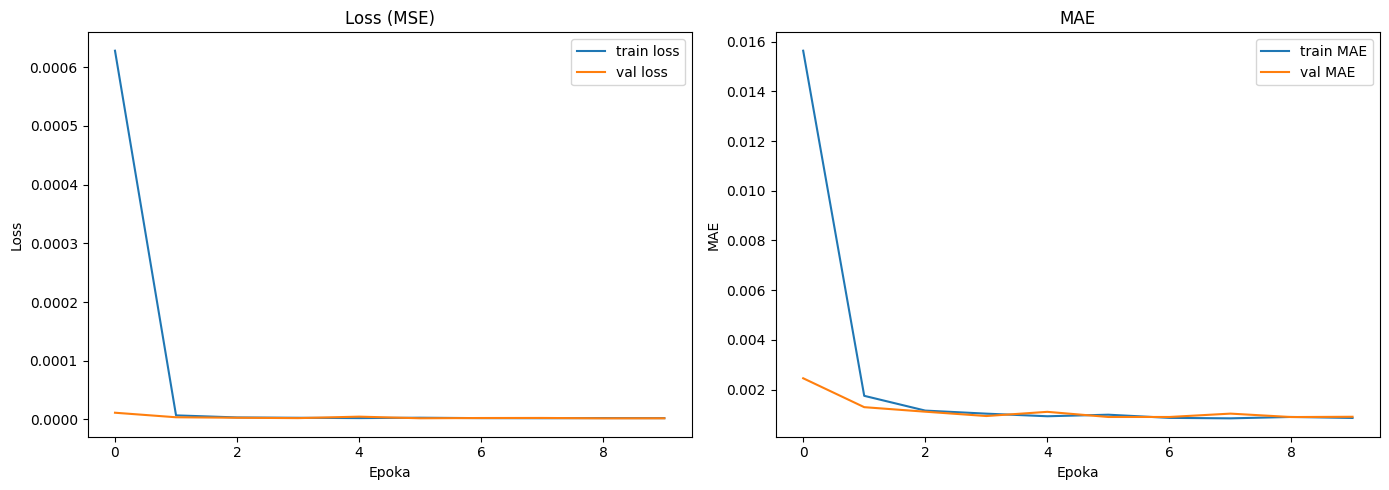

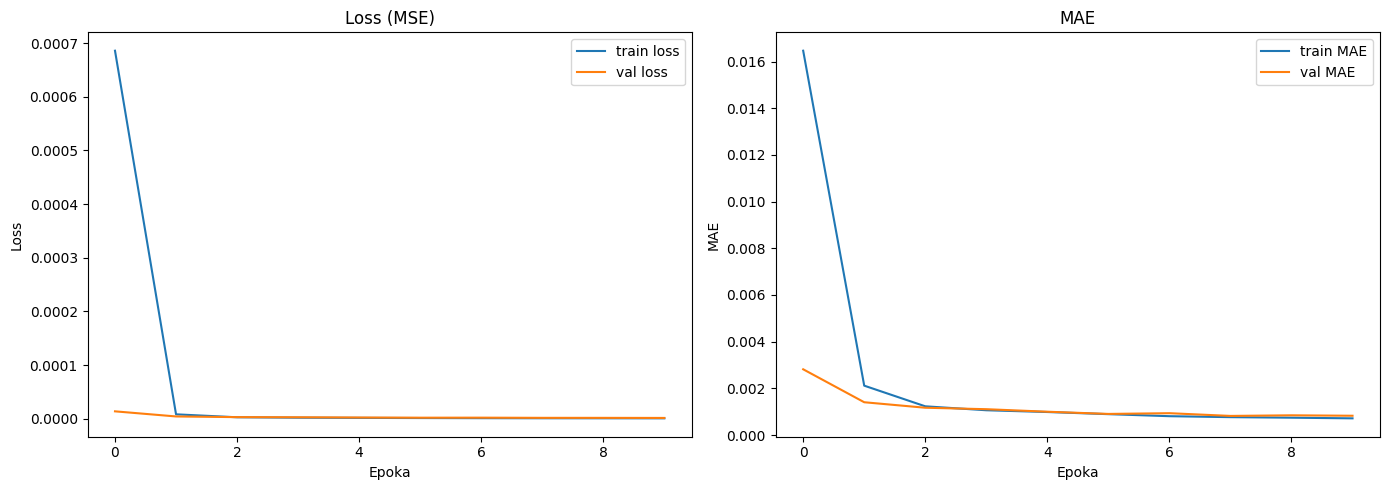

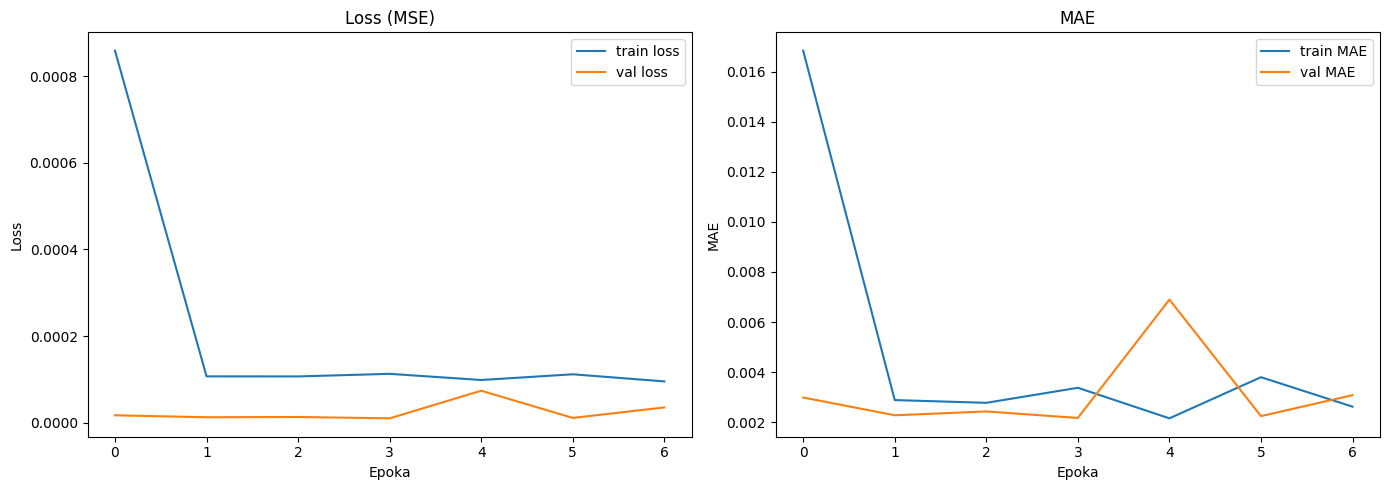

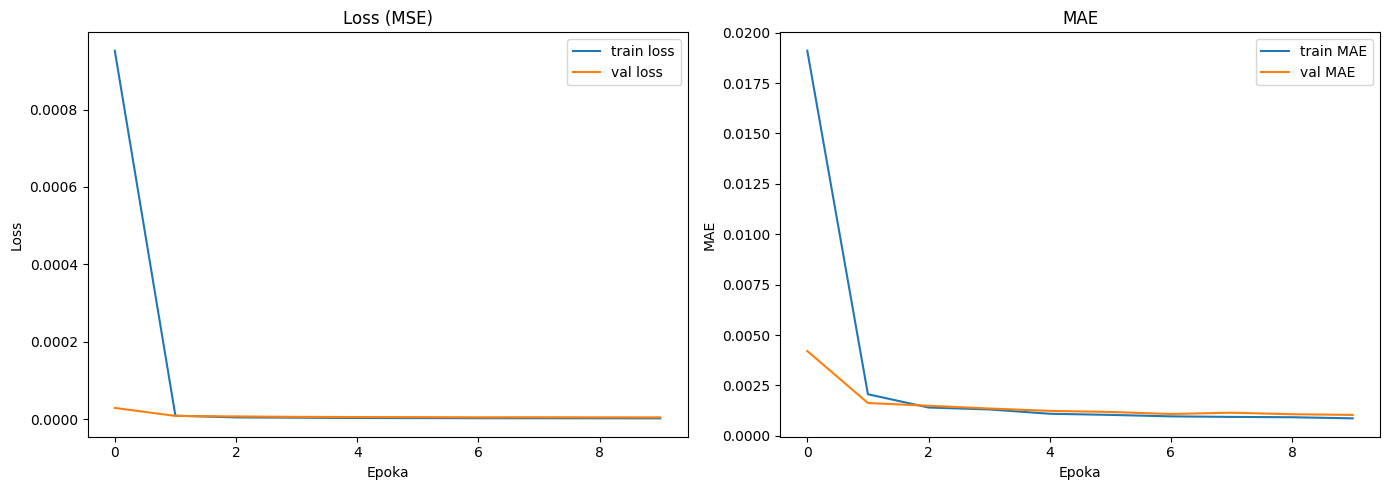

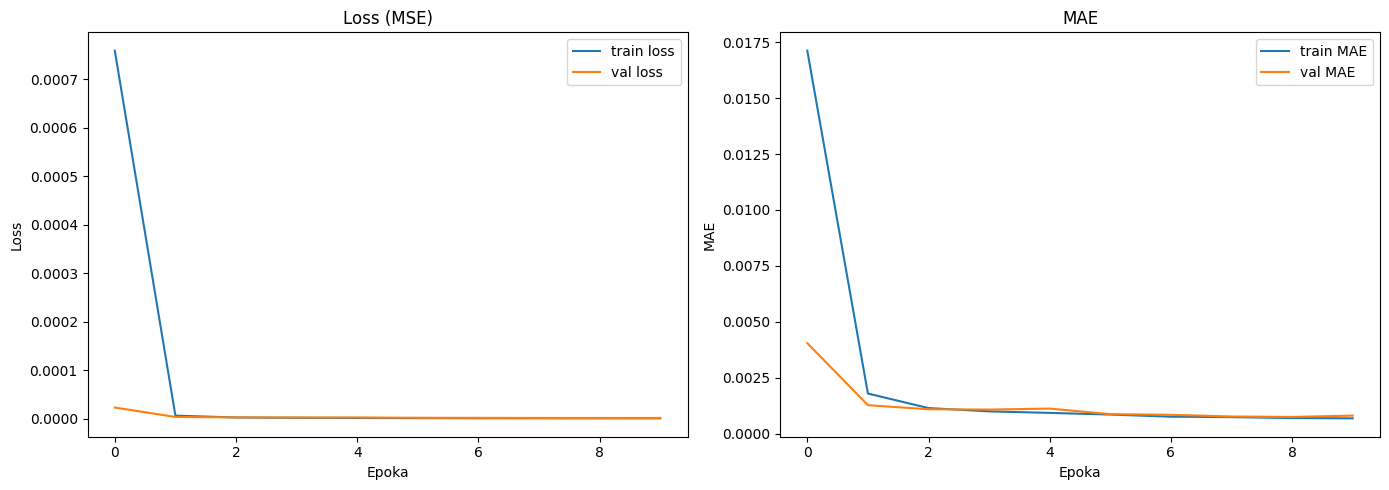

In [11]:
for history in historis:
    plt.figure(figsize=(14,5))
    # ------ Loss ---------
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="val loss")
    plt.title("Loss (MSE)")
    plt.xlabel("Epoka")
    plt.ylabel("Loss")
    plt.legend()

    # ------ MAE ----------
    plt.subplot(1,2,2)
    plt.plot(history.history["mae"], label="train MAE")
    plt.plot(history.history["val_mae"], label="val MAE")
    plt.title("MAE")
    plt.xlabel("Epoka")
    plt.ylabel("MAE")
    plt.legend()

    plt.tight_layout()
    plt.show()